# Training a UniVI model tutorial Jupyter notebook

Andrew Ashford, Pathways + Omics group, 5/1/2024

This Jupyter notebook file is meant to be a tutorial for our multimodal data integration method - UniVI. Your data should be paired multimodal sequencing data such that for each measurement, we have a cell ID of barcode that match across data types. We have some experiments on the horizon to implement unpaired data integration, but those experiments have yet to be performed and extensively tested. At present, the multimodal data needs to be paired measurements.

Your data file(s) should be in .h5ad form so we can read them into AnnData objects for easiest use of our method (shown here).

### Requirements prior to using this workflow

Before using this workflow, we need to use the included manifold_alignment.yml file to create a Conda environment, then install the ipykernel module if not already done. Lastly, we need to use the ipykernel module to generate an environment kernel for use with Jupyter notebooks.

A tutorial on this can be found here:
https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084


### Import modules

In [1]:
# First, use the included UniVI/envs/UniVI_working_environment_v2.yml file to load the environment and use it as 
# a kernel for Jupyter Notebooks. 
#
# A tutorial on this can be found here:
# https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

# Import several commonly-used modules
import os
import anndata
import json
import importlib
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import sparse
from anndata import AnnData
from pathlib import Path

# Use the following module and path to specify where the UniVI module is found
import sys
sys.path.append('../')

# Import UniVI modules - Calling the UniVI functions with UniVI main folder in the same directory of this notebook
from UniVI import _MMVAE
from UniVI._MMVAE import CrossMap
from UniVI.utilities._temp import sub_ad, umap_ad, evalmap, create_comb_anndata_to_eval
from UniVI.utilities._evaluate import EvalMap, predict_celltype
from UniVI.datasets._anndata import _read_csv_to_adata, subsample_anndata, combine_anndata, split_anndata, PrepAnnDataRNA, PrepAnnDataADT
from UniVI.plotting.plots import heatmap_from_mtx, heatmap_sample_idx, gg_point_pair_embed, gg_point_z_activation, gg_point_feature_active, gg_point_embed, gg_point_overlay


### Specify multimodal data file locations

In [2]:
# Load multi-omics data of choice - In this example we'll use the 10x Genomics Multiome (paired scRNA/scATAC) data.
# Specify the directory where the data is located and the filenames
save_path = '/home/groups/precepts/ashforda/UniVI_github_stuff/data/10x_Genomics_Multiome/'

# Specify the filenames of the data to load in
rna_adata = '10x-Multiome-Pbmc10k-RNA.h5ad'
atac_adata = '10x-Multiome-Pbmc10k-ATAC.h5ad'


### Preprocess data using specified file locations

Below are the in-house functions to preprocess each of the data modalities in a way that satisfies the downstream application needs.

#### Start with preprocessing the scRNA data

In [3]:
# Using built-in UniVI RNA preprocessing function that we read in at the beginning of this notebook
preprocessed_adata_rna = PrepAnnDataRNA(
                             filepath_in=save_path + rna_adata,
                        
                             # Can save the preprocessed data as an h5ad file as shown below
                             #filepath_out_h5ad=pbmc_rna_cleaned_data,
                             #save=True,
    
                             save=False,
                             skip_filter=True,
                             show_plot=False,
                             features_to_select=None,
                             missing_impute=False,
                             cells_threshold_min_genes=200,
                             genes_threshold_min_cells=3,
                             obs_threshold_pct_counts_mt = 10, # mt fraction should be less than this
                             percent_outlier = 0.5,  # 0.25 % from each side 
    
                             # Select number of gene features desired
                             n_top_genes = 2000).adata # return as an anndata object


get statistics
normalize and log1p transformation
select genes
by highly variable genes criteria: 2000


In [4]:
# Sanity check the resulting preprocessed data objects
print(preprocessed_adata_rna)
print(preprocessed_adata_rna.layers['counts'])
print(preprocessed_adata_rna.X)


AnnData object with n_obs × n_vars = 9631 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'hvg', 'log1p'
    layers: 'counts', 'lib_normed_log1p', 'z_scaled'
  (0, 1)	1.0
  (0, 7)	1.0
  (0, 43)	6.0
  (0, 73)	1.0
  (0, 75)	3.0
  (0, 77)	3.0
  (0, 85)	1.0
  (0, 86)	2

#### Next, preprocess the scATAC data

In [5]:
# Using same built-in UniVI preprocessing function that we used previously for RNA data
preprocessed_adata_atac = PrepAnnDataRNA(
                              filepath_in=save_path + atac_adata,
    
                              # Can save the preprocessed data as an h5ad file as shown below:
                              #filepath_out_h5ad=pbmc_atac_cleaned_data,
                              #save=True,
    
                              save=False,
                              skip_filter=False,
                              show_plot=False,
                              features_to_select=None, # using 2000 genes                    
                              missing_impute=False,
                              cells_threshold_min_genes=200,
                              genes_threshold_min_cells=0,
                              obs_threshold_pct_counts_mt = 20, # mt fraction should be less than this
                              percent_outlier = 1,  # 0.50 % from each side 
                              target_sum = 1,
                              scale_max_value = 10,

                              # Select ATAC feature count
                              n_top_genes = 2000).adata # return as an anndata object


get statistics
remove outliers: top and bottom 0.5 %
filter out cells and genes with low quality: 
genes<200, cells<0


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


normalize and log1p transformation
select genes
by highly variable genes criteria: 2000


In [6]:
# Sanity check the resulting preprocessed data objects
print(preprocessed_adata_atac)
print(preprocessed_adata_atac.layers['counts'])
print(preprocessed_adata_atac.X)


AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'lib_normed_log1p', 'z_scaled'
  (0, 42)	6.0
  (0, 43)	4.0
  (0, 48)	2.0
  (0, 49)	2.0
  (0, 61)	4.0
  (0, 67)	2.0
  (0, 83)	2.0
  (0, 99)	8.0
  (0, 104)	4.0
  (0, 105)	4.0
  (0, 109)	6.0
  (0, 127)	2.0
  (0, 140)	4.0
  (0, 161)	4.0
  (0, 172)	6.0
  (0, 181)	2.0
  (0, 210)	4.0
  (0, 219)	2.0
 

#### Combine AnnData objects for model training

Can use the intersection cell barcodes to make AnnData objects for each data type that follow the same patterns.

In [29]:
# Get cell barcode intersections between data types
multimodal_data_intersect = preprocessed_adata_rna.obs.index.intersection(preprocessed_adata_atac.obs.index)


In [30]:
# Start with the RNA data object
adata_intersected_rna = preprocessed_adata_rna[multimodal_data_intersect, :].copy()

# Now do the ATAC data object
adata_intersected_atac = preprocessed_adata_atac[multimodal_data_intersect, :].copy()


In [31]:
# Extra sanity checks to make sure the barcodes all match and check final barcode counts
print(len(multimodal_data_intersect))
all(adata_intersected_rna.obs_names == adata_intersected_atac.obs_names)


9437


True

#### Save the resulting AnnData objects for downstream use as needed

In [32]:
# Specify location to save cleaned adata objects to files
preprocessed_rna_adata_location = './data/10x_Genomics_Multiome/preprocessed_AnnData_files/5-1-2024/10x_multiome_PBMC_rna_overlapped_cell_barcodes.h5ad'
preprocessed_atac_adata_location = './data/10x_Genomics_Multiome/preprocessed_AnnData_files/5-1-2024/10x_multiome_PBMC_atac_overlapped_cell_barcodes.h5ad'


In [33]:
# Write both cleaned rna and atac adata files to h5ad files for downstream use
adata_intersected_rna.write_h5ad(preprocessed_rna_adata_location)
adata_intersected_atac.write_h5ad(preprocessed_atac_adata_location)


## Overview of UniVI model

Here is an image of the model overview so I can associate what we're doing with different parts of the model:

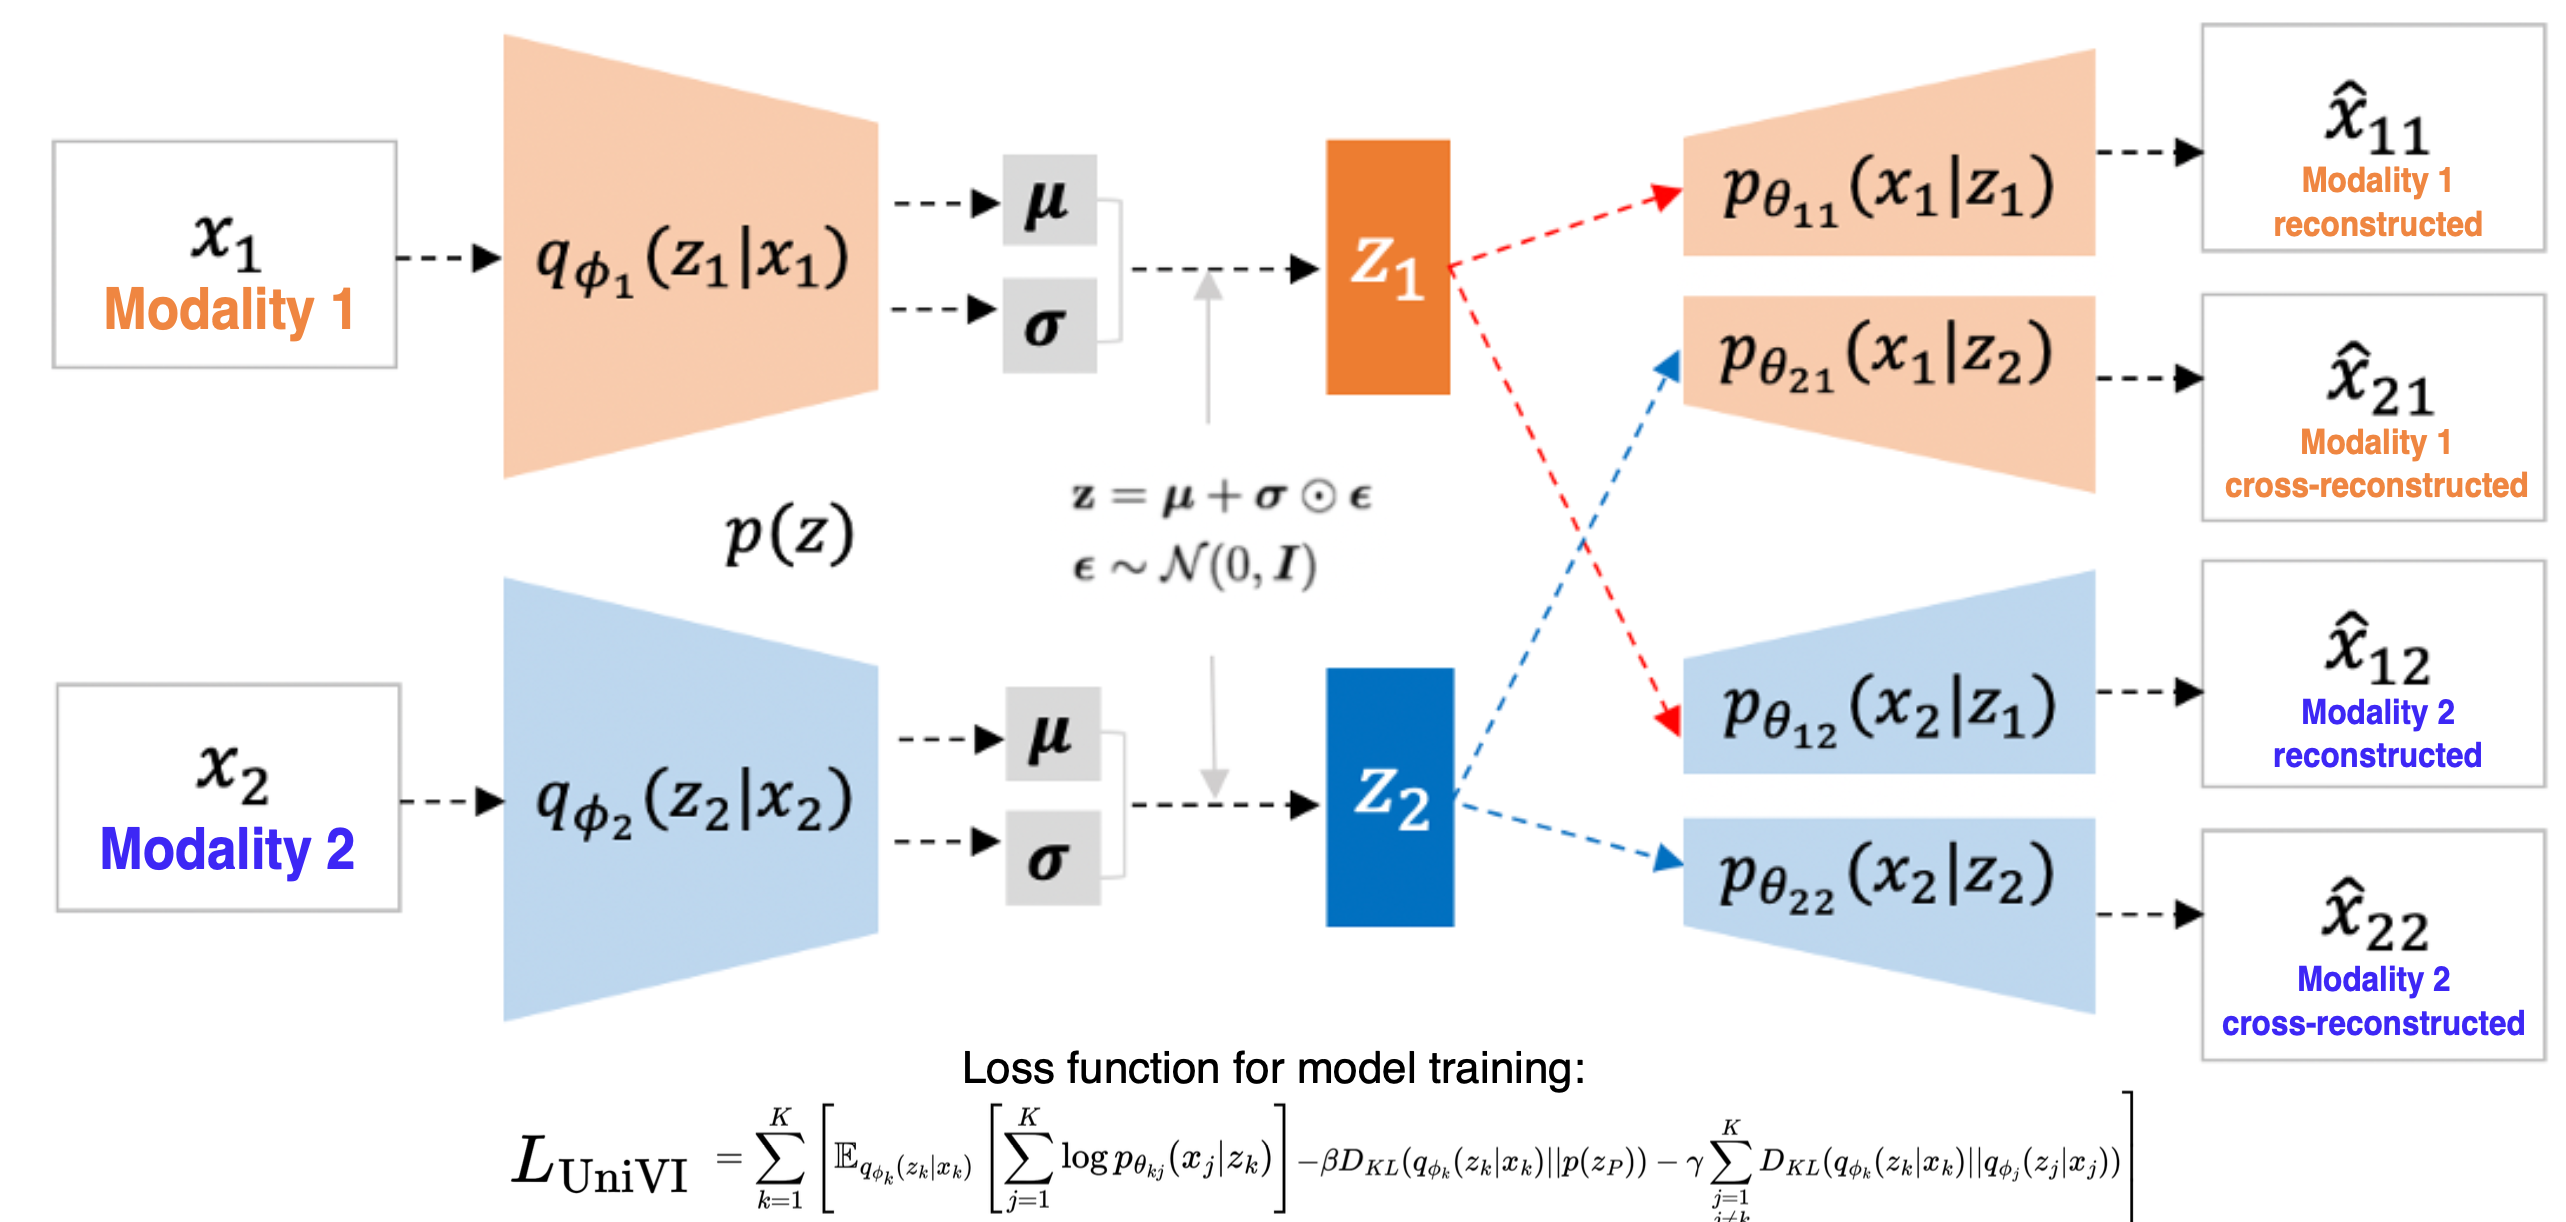

Here is a general legend for the variables in the model:

x1 = single-cell RNA data in this case

x2 = single-cell ATAC peak data in this case

The data gets fed through the dual encoder part of the model, represented by:

𝑞𝜙1(𝑧1│𝑥1) = RNA latent feature encoder

𝑞𝜙2(𝑧2│𝑥2) = Protein latent feature encoder

Once encoded, the data is in the form of Z latent feature distributions, these are represented as:
Mu and sigma - ie the mean and standard deviation of all the latent feature space distributions. In this model, they are computationally in the form of distribution tensors that are of size batch x latent feature size. Typically, if we are accessing this space, we will want to use the "update to best epoch" function which I show below. This will allow us to directly sample from these distribution spaces, otherwise, the latent features "Z" and the sampled features from that run.

Next, each modalities' features goes through dual decoders - one that recreates itself, and one that recreates the opposite modality. For example:

𝑝𝜃11(𝑥1|𝑧1) uses the latent dimensions from the RNA encoder and reconstructs the input RNA data

𝑝𝜃21(𝑥1|𝑧2) uses the latent dimensions from the RNA encoder and reconstructs the input protein data

𝑝𝜃12(𝑥2|𝑧1) uses the latent dimensions from the protein encoder and reconstructs the input RNA data

𝑝𝜃22(𝑥2|𝑧2) uses the latent dimensions from the protein encoder and reconstructs the input protein data


Once decoded, the output space are the recreated input features, but a DISTRIBUTION of them, similar to the latent dimensions. The outputs require sampling in order to generate singular results.

## Specify functions for the main training function

In [42]:
# Define function to train the model(s):
def run(dirpath_home, adata1, adata2, params):
    cm = CrossMap(dirpath_home, adata1, adata2, params)
    cm.learn()
    cm.save_latent_features()
    cm.save()


## Specify hyperparameters

In [5]:
# Specify UniVI parameter file location - In this example we will use "defaults.json"
fpath_default = '../UniVI/parameter_files/defaults_multi.json'


Can specify custom parameters, default is to use the "./scvt/defaults_multi.json" file. The contents of which look like the following:

NOTE: These settings can be changed within this notebook file - shown how to read in above.

{\
&nbsp;&nbsp;&nbsp;&nbsp;"train": {\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dec_model": "nb",\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"loss_func": "m_iwae",\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"n_mc_samples": 1,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"beta": 1,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"seed": 42,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"n_epochs": 2,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"batch_size": 100,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"train_fraction": 0.8,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"val_fraction": 0.1,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"scale_by_n_feature": "False",\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"use_cuda": "True"\
&nbsp;&nbsp;&nbsp;&nbsp;},\
&nbsp;&nbsp;&nbsp;&nbsp;"early_stopping": {\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"patience": 10,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"verbose": "False"\
&nbsp;&nbsp;&nbsp;&nbsp;},\
&nbsp;&nbsp;&nbsp;&nbsp;"model_arch_1": {\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dec_model": "nb",\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dim_features": 2000,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dim_latent": 20,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dim_hidden": 256,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"n_hidden_layers": 5\
&nbsp;&nbsp;&nbsp;&nbsp;},\
&nbsp;&nbsp;&nbsp;&nbsp;"model_arch_2": {\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dec_model": "nb",\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dim_features": 224,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dim_latent": 20,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"dim_hidden": 128,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"n_hidden_layers": 1\
&nbsp;&nbsp;&nbsp;&nbsp;}\
}

We plan to fine-tune additional multimodal data type defaults and include .json files for easy use with a variety of data measurement technologies as they become available.


In [43]:
# Specify additional hyperparameters - will overwrite any params from the default params json file if re-specifying
# a default parameter.

# These should generally not be changed. There are plans to experiment with additional decoder models and 
# potentially loss functions.
data_type_list = ['multi']
dec_model_list = ['gaussian']
loss_func_list = ['m_elbo']

# Specify the whole model training variables.
patience = 30
batch_size_list = [500]
dim_latent_list = [40, 60]
n_mc_samples_list = [20]
beta_value_list = [115, 125, 135, 145]

# NOTE: Features should match the preprocessing functions above feature counts.
# In this case - we selected 2000 most variable RNA features and 2000 most variable ATAC peaks.
m1_features = 2000
m2_features = 2000

m1_n_hidden_layers_list = [3]
m2_n_hidden_layers_list = [5]

m1_dim_hidden = 224
m2_dim_hidden = 224


In [44]:
# Specify the output directory of the trained model
output_dir = '/home/groups/precepts/ashforda/UniVI_github_stuff/output/5-1-2024/trained_models/' # NOTE: Include the final '/' denoting that it's a directory.


In [ ]:
# Specify name to use for your data to name directories for trained model
sid = 'PBMC_multiome'


## Train the model(s)

In [ ]:
# Currently we are training model in a series of for-loops. We have plans to optimize this code to work with
# compute clusters so we can split model training among compute cores.

# The for-loops will iterate through above parameter lists 
for batch_size in batch_size_list:
    for data_type in data_type_list:
        for dec_model in dec_model_list:
            for dim_latent in dim_latent_list:
                for m1_n_hidden_layers in m1_n_hidden_layers_list:
                    for m2_n_hidden_layers in m2_n_hidden_layers_list:
                        for loss_func in loss_func_list:
                            for n_mc_samples in n_mc_samples_list:
                                for beta in beta_value_list:

                                    # NOTE: Below code is setting variables that are already specified above in the
                                    # "Specify hyperparameters" section.
                                    
                                    # Load in default parameters from defaults json file
                                    with open(fpath_default, 'r') as fh:
                                        params = json.load(fh)

                                    # Set modality 1 autoencoder parameters if different from defaults file
                                    params['model_arch_1']['dim_features'] = m1_features
                                    params['model_arch_1']['dim_hidden'] = m1_dim_hidden
                                    params['model_arch_1']['dec_model'] = dec_model
                                    params['model_arch_1']['n_hidden_layers'] = m1_n_hidden_layers
                                    params['model_arch_1']['dim_latent'] = dim_latent
                                    
                                    # Set modality 2 autoencoder parameters if different from defaults file
                                    params['model_arch_2']['dim_features'] = m2_features
                                    params['model_arch_2']['dim_hidden'] = m2_dim_hidden
                                    params['model_arch_2']['dec_model'] = dec_model
                                    params['model_arch_2']['n_hidden_layers'] = m2_n_hidden_layers
                                    params['model_arch_2']['dim_latent'] = dim_latent
                                    
                                    # # Set additional overall model parameters if different from defaults file
                                    params['train']['loss_func'] = loss_func
                                    params['train']['n_mc_samples'] = n_mc_samples
                                    params['train']['beta'] = beta
                                    params['train']['batch_size'] = batch_size
                                    params['train']['n_epochs'] = 800
                                    
                                    # Set patience for model training if different from defaults file
                                    params['early_stopping']['patience'] = patience
                                    
                                    # Specify model output directory name if different from defaults file
                                    model_directory_name = f'{sid}_batch_size_{batch_size}_p{patience}_{data_type}_{dec_model}_z{dim_latent}_l{m1_n_hidden_layers}_l{m2_n_hidden_layers}_{loss_func}_mc{n_mc_samples}_b{beta}_m1_dim_hidden_{m1_dim_hidden}_m2_dim_hidden_{m2_dim_hidden}_m1_features_{m1_features}_m2_features_{m2_features}'
                                    dirpath_home = output_dir + model_directory_name + '/'
                                    
                                    # Use the model training function defined above. Uses the two intersected 
                                    # AnnData objects of each modality.
                                    run(dirpath_home, adata_intersected_rna, adata_intersected_atac, params)


epoch 1: train 171130.781
epoch 1: val   161556.172
using data from modalities
epoch 1: test  161774.203
Validation loss decreased (inf --> 161556.1719).  Saving model ...
=======> val_loss input: 161556.172
=======> best_score: 161556.172
epoch 2: train 159232.897
epoch 2: val   155162.742
using data from modalities
epoch 2: test  155081.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (161556.1719 --> 155162.7422).  Saving model ...
=======> val_loss input: 155162.742
=======> best_score: 155162.742
epoch 3: train 154885.976
epoch 3: val   151799.844
using data from modalities
epoch 3: test  151259.070
Validation loss decreased (155162.7422 --> 151799.8438).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 151799.844
=======> best_score: 151799.844
epoch 4: train 152216.500
epoch 4: val   149013.086
using data from modalities
epoch 4: test  149668.391
Validation loss decreased (151799.8438 --> 149013.0859).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 149013.086
=======> best_score: 149013.086
epoch 5: train 148021.709
epoch 5: val   147046.094
using data from modalities
epoch 5: test  148234.344


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (149013.0859 --> 147046.0938).  Saving model ...
=======> val_loss input: 147046.094
=======> best_score: 147046.094
epoch 6: train 145759.360
epoch 6: val   145199.469
using data from modalities
epoch 6: test  145297.047
Validation loss decreased (147046.0938 --> 145199.4688).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 145199.469
=======> best_score: 145199.469
epoch 7: train 144387.337
epoch 7: val   145733.211
using data from modalities
epoch 7: test  144241.617
EarlyStopping counter: 1 out of 30
=======> val_loss input: 145733.211
=======> best_score: 145199.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 8: train 145113.824
epoch 8: val   143897.375
using data from modalities
epoch 8: test  143397.141
Validation loss decreased (145199.4688 --> 143897.3750).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143897.375
=======> best_score: 143897.375
epoch 9: train 143391.413
epoch 9: val   143139.078
using data from modalities
epoch 9: test  144913.539
Validation loss decreased (143897.3750 --> 143139.0781).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143139.078
=======> best_score: 143139.078
epoch 10: train 143011.045
epoch 10: val   143091.953
using data from modalities
epoch 10: test  142975.836
Validation loss decreased (143139.0781 --> 143091.9531).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143091.953
=======> best_score: 143091.953
epoch 11: train 142656.228
epoch 11: val   142135.641
using data from modalities
epoch 11: test  142600.102
Validation loss decreased (143091.9531 --> 142135.6406).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 142135.641
=======> best_score: 142135.641
epoch 12: train 142168.169
epoch 12: val   142156.641
using data from modalities
epoch 12: test  142060.742
EarlyStopping counter: 1 out of 30
=======> val_loss input: 142156.641
=======> best_score: 142135.641


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 13: train 142088.390
epoch 13: val   142523.328
using data from modalities
epoch 13: test  142068.648


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 142523.328
=======> best_score: 142135.641
epoch 14: train 142070.157
epoch 14: val   141974.828
using data from modalities
epoch 14: test  142178.367
Validation loss decreased (142135.6406 --> 141974.8281).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141974.828
=======> best_score: 141974.828
epoch 15: train 141714.322
epoch 15: val   141917.898
using data from modalities
epoch 15: test  143106.000


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141974.8281 --> 141917.8984).  Saving model ...
=======> val_loss input: 141917.898
=======> best_score: 141917.898
epoch 16: train 141655.650
epoch 16: val   141881.227
using data from modalities
epoch 16: test  142365.859


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141917.8984 --> 141881.2266).  Saving model ...
=======> val_loss input: 141881.227
=======> best_score: 141881.227
epoch 17: train 141424.915
epoch 17: val   141858.320
using data from modalities
epoch 17: test  141757.500
Validation loss decreased (141881.2266 --> 141858.3203).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141858.320
=======> best_score: 141858.320
epoch 18: train 141357.261
epoch 18: val   141618.258
using data from modalities
epoch 18: test  141309.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141858.3203 --> 141618.2578).  Saving model ...
=======> val_loss input: 141618.258
=======> best_score: 141618.258
epoch 19: train 141522.474
epoch 19: val   141560.438
using data from modalities
epoch 19: test  142169.188


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141618.2578 --> 141560.4375).  Saving model ...
=======> val_loss input: 141560.438
=======> best_score: 141560.438
epoch 20: train 141177.976
epoch 20: val   141688.516
using data from modalities
epoch 20: test  141199.594
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141688.516
=======> best_score: 141560.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 21: train 141299.672
epoch 21: val   141533.680
using data from modalities
epoch 21: test  141233.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141560.4375 --> 141533.6797).  Saving model ...
=======> val_loss input: 141533.680
=======> best_score: 141533.680
epoch 22: train 141311.863
epoch 22: val   141694.000
using data from modalities
epoch 22: test  141558.766
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141694.000
=======> best_score: 141533.680


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 23: train 141263.103
epoch 23: val   141468.289
using data from modalities
epoch 23: test  141406.602
Validation loss decreased (141533.6797 --> 141468.2891).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141468.289
=======> best_score: 141468.289
epoch 24: train 140989.844
epoch 24: val   141439.141
using data from modalities
epoch 24: test  141321.914


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141468.2891 --> 141439.1406).  Saving model ...
=======> val_loss input: 141439.141
=======> best_score: 141439.141
epoch 25: train 141138.340
epoch 25: val   141655.953
using data from modalities
epoch 25: test  141569.922
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141655.953
=======> best_score: 141439.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 26: train 141180.574
epoch 26: val   141242.570
using data from modalities
epoch 26: test  141403.734
Validation loss decreased (141439.1406 --> 141242.5703).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141242.570
=======> best_score: 141242.570
epoch 27: train 140777.336
epoch 27: val   141252.141
using data from modalities
epoch 27: test  141239.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 141252.141
=======> best_score: 141242.570
epoch 28: train 140729.751
epoch 28: val   141123.531
using data from modalities
epoch 28: test  141206.023


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141242.5703 --> 141123.5312).  Saving model ...
=======> val_loss input: 141123.531
=======> best_score: 141123.531
epoch 29: train 140829.635
epoch 29: val   141118.461
using data from modalities
epoch 29: test  141039.203


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141123.5312 --> 141118.4609).  Saving model ...
=======> val_loss input: 141118.461
=======> best_score: 141118.461
epoch 30: train 140687.621
epoch 30: val   141119.242
using data from modalities
epoch 30: test  140894.734


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 141119.242
=======> best_score: 141118.461
epoch 31: train 140657.192
epoch 31: val   141131.297
using data from modalities
epoch 31: test  140982.484


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 141131.297
=======> best_score: 141118.461
epoch 32: train 140442.436
epoch 32: val   141051.508
using data from modalities
epoch 32: test  141020.180
Validation loss decreased (141118.4609 --> 141051.5078).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141051.508
=======> best_score: 141051.508
epoch 33: train 140456.201
epoch 33: val   141216.125
using data from modalities
epoch 33: test  141039.812
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141216.125
=======> best_score: 141051.508


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 34: train 140544.803
epoch 34: val   141006.555
using data from modalities
epoch 34: test  141093.305
Validation loss decreased (141051.5078 --> 141006.5547).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141006.555
=======> best_score: 141006.555
epoch 35: train 140424.611
epoch 35: val   140694.531
using data from modalities
epoch 35: test  140684.391
Validation loss decreased (141006.5547 --> 140694.5312).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140694.531
=======> best_score: 140694.531
epoch 36: train 140387.880
epoch 36: val   140629.164
using data from modalities
epoch 36: test  140852.695
Validation loss decreased (140694.5312 --> 140629.1641).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140629.164
=======> best_score: 140629.164
epoch 37: train 140325.613
epoch 37: val   140909.734
using data from modalities
epoch 37: test  140732.750
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140909.734
=======> best_score: 140629.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 38: train 140432.921
epoch 38: val   141061.047
using data from modalities
epoch 38: test  140587.453


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 141061.047
=======> best_score: 140629.164
epoch 39: train 140240.493
epoch 39: val   140802.523
using data from modalities
epoch 39: test  140646.117
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140802.523
=======> best_score: 140629.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 40: train 140278.635
epoch 40: val   141069.047
using data from modalities
epoch 40: test  140934.883
EarlyStopping counter: 4 out of 30
=======> val_loss input: 141069.047
=======> best_score: 140629.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 41: train 140208.189
epoch 41: val   140371.602
using data from modalities
epoch 41: test  140761.078
Validation loss decreased (140629.1641 --> 140371.6016).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140371.602
=======> best_score: 140371.602
epoch 42: train 140157.738
epoch 42: val   140586.562
using data from modalities
epoch 42: test  140763.914
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140586.562
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 43: train 140277.187
epoch 43: val   140804.625
using data from modalities
epoch 43: test  140634.523
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140804.625
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 44: train 140153.406
epoch 44: val   140610.594
using data from modalities
epoch 44: test  140510.523
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140610.594
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 45: train 140039.277
epoch 45: val   140580.000
using data from modalities
epoch 45: test  140558.859
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140580.000
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 46: train 139988.567
epoch 46: val   140677.359
using data from modalities
epoch 46: test  140727.594
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140677.359
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 47: train 140020.509
epoch 47: val   140603.617
using data from modalities
epoch 47: test  140540.172
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140603.617
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 48: train 139776.430
epoch 48: val   140624.391
using data from modalities
epoch 48: test  140535.266
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140624.391
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 49: train 140011.354
epoch 49: val   140548.836
using data from modalities
epoch 49: test  140425.891


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 140548.836
=======> best_score: 140371.602
epoch 50: train 139746.092
epoch 50: val   140391.859
using data from modalities
epoch 50: test  140675.477
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140391.859
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 51: train 139845.425
epoch 51: val   140747.461
using data from modalities
epoch 51: test  140571.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 140747.461
=======> best_score: 140371.602
epoch 52: train 139888.221
epoch 52: val   140482.984
using data from modalities
epoch 52: test  140635.086
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140482.984
=======> best_score: 140371.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 53: train 139812.103
epoch 53: val   140463.133
using data from modalities
epoch 53: test  140513.383


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 140463.133
=======> best_score: 140371.602
epoch 54: train 139766.749
epoch 54: val   140419.672
using data from modalities
epoch 54: test  140347.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 13 out of 30
=======> val_loss input: 140419.672
=======> best_score: 140371.602
epoch 55: train 139846.196
epoch 55: val   140525.844
using data from modalities
epoch 55: test  140377.844


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 140525.844
=======> best_score: 140371.602
epoch 56: train 139871.369
epoch 56: val   140125.812
using data from modalities
epoch 56: test  140344.117


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140371.6016 --> 140125.8125).  Saving model ...
=======> val_loss input: 140125.812
=======> best_score: 140125.812
epoch 57: train 139757.014
epoch 57: val   140380.039
using data from modalities
epoch 57: test  140271.156


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140380.039
=======> best_score: 140125.812
epoch 58: train 139724.887
epoch 58: val   140127.344
using data from modalities
epoch 58: test  140523.461


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140127.344
=======> best_score: 140125.812
epoch 59: train 139666.429
epoch 59: val   140684.469
using data from modalities
epoch 59: test  140121.578


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140684.469
=======> best_score: 140125.812
epoch 60: train 139787.558
epoch 60: val   140427.836
using data from modalities
epoch 60: test  140696.273


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140427.836
=======> best_score: 140125.812
epoch 61: train 139724.923
epoch 61: val   140106.742
using data from modalities
epoch 61: test  140425.641


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140125.8125 --> 140106.7422).  Saving model ...
=======> val_loss input: 140106.742
=======> best_score: 140106.742
epoch 62: train 139712.135
epoch 62: val   140285.180
using data from modalities
epoch 62: test  140322.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140285.180
=======> best_score: 140106.742
epoch 63: train 139616.568
epoch 63: val   140298.219
using data from modalities
epoch 63: test  140203.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140298.219
=======> best_score: 140106.742
epoch 64: train 139516.693
epoch 64: val   140447.102
using data from modalities
epoch 64: test  140017.336


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140447.102
=======> best_score: 140106.742
epoch 65: train 139585.359
epoch 65: val   140230.953
using data from modalities
epoch 65: test  140342.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140230.953
=======> best_score: 140106.742
epoch 66: train 139467.533
epoch 66: val   140353.180
using data from modalities
epoch 66: test  140311.430
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140353.180
=======> best_score: 140106.742


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 67: train 139714.862
epoch 67: val   140090.492
using data from modalities
epoch 67: test  140337.805
Validation loss decreased (140106.7422 --> 140090.4922).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140090.492
=======> best_score: 140090.492
epoch 68: train 139513.482
epoch 68: val   140410.062
using data from modalities
epoch 68: test  140377.961
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140410.062
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 69: train 139692.359
epoch 69: val   140257.516
using data from modalities
epoch 69: test  140472.359
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140257.516
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 70: train 139612.084
epoch 70: val   140262.492
using data from modalities
epoch 70: test  140449.141
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140262.492
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 71: train 139649.118
epoch 71: val   140356.047
using data from modalities
epoch 71: test  140297.203
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140356.047
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 72: train 139597.704
epoch 72: val   140448.383
using data from modalities
epoch 72: test  140359.641


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140448.383
=======> best_score: 140090.492
epoch 73: train 139598.833
epoch 73: val   140273.250
using data from modalities
epoch 73: test  140179.695
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140273.250
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 74: train 139403.173
epoch 74: val   140216.633
using data from modalities
epoch 74: test  140721.836
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140216.633
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 75: train 139352.309
epoch 75: val   140381.969
using data from modalities
epoch 75: test  140305.750
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140381.969
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 76: train 139446.288
epoch 76: val   140298.391
using data from modalities
epoch 76: test  140410.570
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140298.391
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 77: train 139586.517
epoch 77: val   140952.703
using data from modalities
epoch 77: test  140297.375
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140952.703
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 78: train 139416.136
epoch 78: val   140463.289
using data from modalities
epoch 78: test  140305.570


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 140463.289
=======> best_score: 140090.492
epoch 79: train 139387.037
epoch 79: val   140264.734
using data from modalities
epoch 79: test  140575.695


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 140264.734
=======> best_score: 140090.492
epoch 80: train 139331.344
epoch 80: val   140350.008
using data from modalities
epoch 80: test  140146.086
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140350.008
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 81: train 139324.465
epoch 81: val   140401.812
using data from modalities
epoch 81: test  140109.477


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 140401.812
=======> best_score: 140090.492
epoch 82: train 139462.823
epoch 82: val   140262.555
using data from modalities
epoch 82: test  140348.609
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140262.555
=======> best_score: 140090.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 83: train 139366.004
epoch 83: val   140251.367
using data from modalities
epoch 83: test  140266.852


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 16 out of 30
=======> val_loss input: 140251.367
=======> best_score: 140090.492
epoch 84: train 139312.545
epoch 84: val   140117.305
using data from modalities
epoch 84: test  140117.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 17 out of 30
=======> val_loss input: 140117.305
=======> best_score: 140090.492
epoch 85: train 139216.318
epoch 85: val   139980.328
using data from modalities
epoch 85: test  140022.172
Validation loss decreased (140090.4922 --> 139980.3281).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139980.328
=======> best_score: 139980.328
epoch 86: train 139429.664
epoch 86: val   140175.555
using data from modalities
epoch 86: test  140028.461


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140175.555
=======> best_score: 139980.328
epoch 87: train 139302.797
epoch 87: val   140186.750
using data from modalities
epoch 87: test  139917.422


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140186.750
=======> best_score: 139980.328
epoch 88: train 139283.134
epoch 88: val   139982.281
using data from modalities
epoch 88: test  140236.641
EarlyStopping counter: 3 out of 30
=======> val_loss input: 139982.281
=======> best_score: 139980.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 89: train 139285.881
epoch 89: val   140140.461
using data from modalities
epoch 89: test  140285.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140140.461
=======> best_score: 139980.328
epoch 90: train 139401.066
epoch 90: val   140195.164
using data from modalities
epoch 90: test  139935.617
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140195.164
=======> best_score: 139980.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 91: train 139538.361
epoch 91: val   139989.234
using data from modalities
epoch 91: test  140993.211
EarlyStopping counter: 6 out of 30
=======> val_loss input: 139989.234
=======> best_score: 139980.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 92: train 139451.404
epoch 92: val   139960.797
using data from modalities
epoch 92: test  139914.164
Validation loss decreased (139980.3281 --> 139960.7969).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139960.797
=======> best_score: 139960.797
epoch 93: train 139294.169
epoch 93: val   140056.055
using data from modalities
epoch 93: test  140318.234
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140056.055
=======> best_score: 139960.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 94: train 139212.084
epoch 94: val   139984.836
using data from modalities
epoch 94: test  139869.242


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 139984.836
=======> best_score: 139960.797
epoch 95: train 139130.613
epoch 95: val   140435.297
using data from modalities
epoch 95: test  139833.211
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140435.297
=======> best_score: 139960.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 96: train 139197.968
epoch 96: val   140365.859
using data from modalities
epoch 96: test  140095.672


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140365.859
=======> best_score: 139960.797
epoch 97: train 139251.624
epoch 97: val   141524.109
using data from modalities
epoch 97: test  139779.820
EarlyStopping counter: 5 out of 30
=======> val_loss input: 141524.109
=======> best_score: 139960.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 98: train 139126.117
epoch 98: val   140282.125
using data from modalities
epoch 98: test  140180.430
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140282.125
=======> best_score: 139960.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 99: train 139330.200
epoch 99: val   140195.414
using data from modalities
epoch 99: test  140140.812


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 140195.414
=======> best_score: 139960.797
epoch 100: train 139132.724
epoch 100: val   139944.562
using data from modalities
epoch 100: test  139923.359
Validation loss decreased (139960.7969 --> 139944.5625).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139944.562
=======> best_score: 139944.562
epoch 101: train 139126.028
epoch 101: val   140075.180
using data from modalities
epoch 101: test  140115.391
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140075.180
=======> best_score: 139944.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 102: train 139192.316
epoch 102: val   140019.164
using data from modalities
epoch 102: test  140302.227
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140019.164
=======> best_score: 139944.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 103: train 139060.078
epoch 103: val   140014.133
using data from modalities
epoch 103: test  140093.109


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140014.133
=======> best_score: 139944.562
epoch 104: train 139079.951
epoch 104: val   139801.680
using data from modalities
epoch 104: test  140052.234
Validation loss decreased (139944.5625 --> 139801.6797).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139801.680
=======> best_score: 139801.680
epoch 105: train 139109.138
epoch 105: val   140017.359
using data from modalities
epoch 105: test  140247.945


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140017.359
=======> best_score: 139801.680
epoch 106: train 139103.328
epoch 106: val   140618.930
using data from modalities
epoch 106: test  140201.695
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140618.930
=======> best_score: 139801.680


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 107: train 139149.076
epoch 107: val   140021.453
using data from modalities
epoch 107: test  140145.906


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140021.453
=======> best_score: 139801.680
epoch 108: train 138913.657
epoch 108: val   139781.234
using data from modalities
epoch 108: test  141481.227
Validation loss decreased (139801.6797 --> 139781.2344).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139781.234
=======> best_score: 139781.234
epoch 109: train 139146.004
epoch 109: val   140068.414
using data from modalities
epoch 109: test  140157.266


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140068.414
=======> best_score: 139781.234
epoch 110: train 138972.244
epoch 110: val   141508.414
using data from modalities
epoch 110: test  140336.617
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141508.414
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 111: train 139298.104
epoch 111: val   140371.953
using data from modalities
epoch 111: test  140203.969
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140371.953
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 112: train 139220.902
epoch 112: val   140074.438
using data from modalities
epoch 112: test  140305.734
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140074.438
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 113: train 139045.042
epoch 113: val   140283.586
using data from modalities
epoch 113: test  140052.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140283.586
=======> best_score: 139781.234
epoch 114: train 138978.578
epoch 114: val   140226.312
using data from modalities
epoch 114: test  140959.977
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140226.312
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 115: train 139166.386
epoch 115: val   139957.898
using data from modalities
epoch 115: test  140017.664
EarlyStopping counter: 7 out of 30
=======> val_loss input: 139957.898
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 116: train 139721.096
epoch 116: val   140448.844
using data from modalities
epoch 116: test  139811.625


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 140448.844
=======> best_score: 139781.234
epoch 117: train 139032.024
epoch 117: val   140655.430
using data from modalities
epoch 117: test  139884.062
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140655.430
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 118: train 138928.120
epoch 118: val   139901.648
using data from modalities
epoch 118: test  139814.508
EarlyStopping counter: 10 out of 30
=======> val_loss input: 139901.648
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 119: train 139029.923
epoch 119: val   140083.820
using data from modalities
epoch 119: test  139855.141
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140083.820
=======> best_score: 139781.234


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 120: train 139108.341
epoch 120: val   140253.875
using data from modalities
epoch 120: test  139869.703


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 140253.875
=======> best_score: 139781.234
epoch 121: train 139000.607
epoch 121: val   140269.922
using data from modalities
epoch 121: test  139858.734


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 13 out of 30
=======> val_loss input: 140269.922
=======> best_score: 139781.234
epoch 122: train 139104.572
epoch 122: val   139779.852
using data from modalities
epoch 122: test  140187.570
Validation loss decreased (139781.2344 --> 139779.8516).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139779.852
=======> best_score: 139779.852
epoch 123: train 139039.056
epoch 123: val   139714.688
using data from modalities
epoch 123: test  139795.219


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (139779.8516 --> 139714.6875).  Saving model ...
=======> val_loss input: 139714.688
=======> best_score: 139714.688
epoch 124: train 138924.177
epoch 124: val   139915.047
using data from modalities
epoch 124: test  140102.570


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 139915.047
=======> best_score: 139714.688
epoch 125: train 138750.282
epoch 125: val   140011.758
using data from modalities
epoch 125: test  139925.414
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140011.758
=======> best_score: 139714.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 126: train 138960.375
epoch 126: val   139737.398
using data from modalities
epoch 126: test  139776.195
EarlyStopping counter: 3 out of 30
=======> val_loss input: 139737.398
=======> best_score: 139714.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 127: train 139029.304
epoch 127: val   139828.469
using data from modalities
epoch 127: test  139723.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 139828.469
=======> best_score: 139714.688
epoch 128: train 138881.631
epoch 128: val   139914.914
using data from modalities
epoch 128: test  139904.422
EarlyStopping counter: 5 out of 30
=======> val_loss input: 139914.914
=======> best_score: 139714.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 129: train 138958.489
epoch 129: val   140188.477
using data from modalities
epoch 129: test  139981.805


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 140188.477
=======> best_score: 139714.688
epoch 130: train 138875.053
epoch 130: val   140036.172
using data from modalities
epoch 130: test  140036.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 140036.172
=======> best_score: 139714.688
epoch 131: train 139024.465
epoch 131: val   139504.539
using data from modalities
epoch 131: test  139726.930
Validation loss decreased (139714.6875 --> 139504.5391).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139504.539
=======> best_score: 139504.539
epoch 132: train 138890.364
epoch 132: val   139640.664
using data from modalities
epoch 132: test  139711.742
EarlyStopping counter: 1 out of 30
=======> val_loss input: 139640.664
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 133: train 139014.126
epoch 133: val   140013.555
using data from modalities
epoch 133: test  139976.867
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140013.555
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 134: train 138842.302
epoch 134: val   139918.438
using data from modalities
epoch 134: test  140013.664
EarlyStopping counter: 3 out of 30
=======> val_loss input: 139918.438
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 135: train 139028.241
epoch 135: val   140002.406
using data from modalities
epoch 135: test  139770.430
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140002.406
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 136: train 138837.820
epoch 136: val   139743.758
using data from modalities
epoch 136: test  139933.375
EarlyStopping counter: 5 out of 30
=======> val_loss input: 139743.758
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 137: train 138889.144
epoch 137: val   140077.758
using data from modalities
epoch 137: test  139965.086
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140077.758
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 138: train 138775.632
epoch 138: val   140167.633
using data from modalities
epoch 138: test  140009.273


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 140167.633
=======> best_score: 139504.539
epoch 139: train 138866.346
epoch 139: val   140222.852
using data from modalities
epoch 139: test  139829.172
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140222.852
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 140: train 138840.113
epoch 140: val   139885.352
using data from modalities
epoch 140: test  139888.734


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 139885.352
=======> best_score: 139504.539
epoch 141: train 138663.331
epoch 141: val   140294.656
using data from modalities
epoch 141: test  139836.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 140294.656
=======> best_score: 139504.539
epoch 142: train 138729.978
epoch 142: val   140130.508
using data from modalities
epoch 142: test  140395.414
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140130.508
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 143: train 138857.479
epoch 143: val   140084.180
using data from modalities
epoch 143: test  139952.969
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140084.180
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 144: train 139636.711
epoch 144: val   139857.117
using data from modalities
epoch 144: test  140159.602
EarlyStopping counter: 13 out of 30
=======> val_loss input: 139857.117
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 145: train 138815.647
epoch 145: val   140357.031
using data from modalities
epoch 145: test  139834.320


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 140357.031
=======> best_score: 139504.539
epoch 146: train 138845.271
epoch 146: val   140036.953
using data from modalities
epoch 146: test  140030.820
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140036.953
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 147: train 139008.560
epoch 147: val   139964.070
using data from modalities
epoch 147: test  139849.180
EarlyStopping counter: 16 out of 30
=======> val_loss input: 139964.070
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 148: train 138961.994
epoch 148: val   140002.539
using data from modalities
epoch 148: test  139866.562
EarlyStopping counter: 17 out of 30
=======> val_loss input: 140002.539
=======> best_score: 139504.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 149: train 139039.943
epoch 149: val   139848.602
using data from modalities
epoch 149: test  139715.828


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 18 out of 30
=======> val_loss input: 139848.602
=======> best_score: 139504.539
epoch 150: train 138942.276
epoch 150: val   139487.227
using data from modalities
epoch 150: test  139749.859
Validation loss decreased (139504.5391 --> 139487.2266).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139487.227
=======> best_score: 139487.227
epoch 151: train 138810.969
epoch 151: val   140367.102
using data from modalities
epoch 151: test  142090.727
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140367.102
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 152: train 138671.034
epoch 152: val   139936.508
using data from modalities
epoch 152: test  139811.828
EarlyStopping counter: 2 out of 30
=======> val_loss input: 139936.508
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 153: train 139014.438
epoch 153: val   139658.562
using data from modalities
epoch 153: test  140218.312


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 139658.562
=======> best_score: 139487.227
epoch 154: train 138713.262
epoch 154: val   139768.977
using data from modalities
epoch 154: test  140161.250
EarlyStopping counter: 4 out of 30
=======> val_loss input: 139768.977
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 155: train 138717.206
epoch 155: val   140159.242
using data from modalities
epoch 155: test  139810.570


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140159.242
=======> best_score: 139487.227
epoch 156: train 138832.596
epoch 156: val   140063.070
using data from modalities
epoch 156: test  140094.328
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140063.070
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 157: train 138846.296
epoch 157: val   139808.961
using data from modalities
epoch 157: test  140522.070


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 139808.961
=======> best_score: 139487.227
epoch 158: train 138769.076
epoch 158: val   139723.914
using data from modalities
epoch 158: test  140194.859


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 139723.914
=======> best_score: 139487.227
epoch 159: train 139206.706
epoch 159: val   139781.031
using data from modalities
epoch 159: test  139776.516
EarlyStopping counter: 9 out of 30
=======> val_loss input: 139781.031
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 160: train 138689.789
epoch 160: val   139610.531
using data from modalities
epoch 160: test  140042.852
EarlyStopping counter: 10 out of 30
=======> val_loss input: 139610.531
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 161: train 138577.599
epoch 161: val   140127.398
using data from modalities
epoch 161: test  139677.914


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 140127.398
=======> best_score: 139487.227
epoch 162: train 138639.165
epoch 162: val   139805.977
using data from modalities
epoch 162: test  139596.609
EarlyStopping counter: 12 out of 30
=======> val_loss input: 139805.977
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 163: train 138685.034
epoch 163: val   146950.180
using data from modalities
epoch 163: test  139888.945
EarlyStopping counter: 13 out of 30
=======> val_loss input: 146950.180
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 164: train 138934.307
epoch 164: val   139860.305
using data from modalities
epoch 164: test  140455.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 139860.305
=======> best_score: 139487.227
epoch 165: train 138530.222
epoch 165: val   139730.734
using data from modalities
epoch 165: test  140031.648
EarlyStopping counter: 15 out of 30
=======> val_loss input: 139730.734
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 166: train 138697.965
epoch 166: val   140051.875
using data from modalities
epoch 166: test  139667.562
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140051.875
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 167: train 138774.941
epoch 167: val   140066.930
using data from modalities
epoch 167: test  140197.031


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 17 out of 30
=======> val_loss input: 140066.930
=======> best_score: 139487.227
epoch 168: train 138551.465
epoch 168: val   139831.570
using data from modalities
epoch 168: test  140004.188
EarlyStopping counter: 18 out of 30
=======> val_loss input: 139831.570
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 169: train 138810.817
epoch 169: val   139828.445
using data from modalities
epoch 169: test  139999.188
EarlyStopping counter: 19 out of 30
=======> val_loss input: 139828.445
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 170: train 138717.959
epoch 170: val   139828.078
using data from modalities
epoch 170: test  140241.492
EarlyStopping counter: 20 out of 30
=======> val_loss input: 139828.078
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 171: train 138699.382
epoch 171: val   139713.062
using data from modalities
epoch 171: test  140262.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 21 out of 30
=======> val_loss input: 139713.062
=======> best_score: 139487.227
epoch 172: train 138520.000
epoch 172: val   139609.094
using data from modalities
epoch 172: test  139960.047
EarlyStopping counter: 22 out of 30
=======> val_loss input: 139609.094
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 173: train 138598.332
epoch 173: val   140013.336
using data from modalities
epoch 173: test  140633.672
EarlyStopping counter: 23 out of 30
=======> val_loss input: 140013.336
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 174: train 138876.240
epoch 174: val   139986.055
using data from modalities
epoch 174: test  139987.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 24 out of 30
=======> val_loss input: 139986.055
=======> best_score: 139487.227
epoch 175: train 138493.343
epoch 175: val   140060.578
using data from modalities
epoch 175: test  140242.953


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 25 out of 30
=======> val_loss input: 140060.578
=======> best_score: 139487.227
epoch 176: train 138777.808
epoch 176: val   139966.391
using data from modalities
epoch 176: test  139831.719
EarlyStopping counter: 26 out of 30
=======> val_loss input: 139966.391
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 177: train 138585.261
epoch 177: val   140292.938
using data from modalities
epoch 177: test  139883.617


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 27 out of 30
=======> val_loss input: 140292.938
=======> best_score: 139487.227
epoch 178: train 138838.569
epoch 178: val   140440.461
using data from modalities
epoch 178: test  140063.773


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 28 out of 30
=======> val_loss input: 140440.461
=======> best_score: 139487.227
epoch 179: train 138774.709
epoch 179: val   139793.398
using data from modalities
epoch 179: test  139962.000
EarlyStopping counter: 29 out of 30
=======> val_loss input: 139793.398
=======> best_score: 139487.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 180: train 138603.951
epoch 180: val   139948.461
using data from modalities
epoch 180: test  139987.055


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 30 out of 30
=======> val_loss input: 139948.461
=======> best_score: 139487.227
Early stopping at 180/800 => best at 150
====> [LEARNING] Time: 749.339s or 00:12:29

* Loading the best model state from epoch 150
using data from modalities
epoch 1: train 171054.259
epoch 1: val   161825.477
using data from modalities
epoch 1: test  161912.617
Validation loss decreased (inf --> 161825.4766).  Saving model ...
=======> val_loss input: 161825.477
=======> best_score: 161825.477
epoch 2: train 159496.426
epoch 2: val   155179.938
using data from modalities
epoch 2: test  155669.016
Validation loss decreased (161825.4766 --> 155179.9375).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 155179.938
=======> best_score: 155179.938
epoch 3: train 153801.160
epoch 3: val   151470.883
using data from modalities
epoch 3: test  151662.938
Validation loss decreased (155179.9375 --> 151470.8828).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 151470.883
=======> best_score: 151470.883
epoch 4: train 151118.450
epoch 4: val   148992.961
using data from modalities
epoch 4: test  150088.930
Validation loss decreased (151470.8828 --> 148992.9609).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 148992.961
=======> best_score: 148992.961
epoch 5: train 147939.956
epoch 5: val   152168.648
using data from modalities
epoch 5: test  147706.578
EarlyStopping counter: 1 out of 30
=======> val_loss input: 152168.648
=======> best_score: 148992.961


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 6: train 145694.862
epoch 6: val   144882.133
using data from modalities
epoch 6: test  145013.516


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (148992.9609 --> 144882.1328).  Saving model ...
=======> val_loss input: 144882.133
=======> best_score: 144882.133
epoch 7: train 144559.563
epoch 7: val   147350.625
using data from modalities
epoch 7: test  144120.219
EarlyStopping counter: 1 out of 30
=======> val_loss input: 147350.625
=======> best_score: 144882.133


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 8: train 144055.402
epoch 8: val   143617.039
using data from modalities
epoch 8: test  143444.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (144882.1328 --> 143617.0391).  Saving model ...
=======> val_loss input: 143617.039
=======> best_score: 143617.039
epoch 9: train 143524.054
epoch 9: val   143181.680
using data from modalities
epoch 9: test  143780.766
Validation loss decreased (143617.0391 --> 143181.6797).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143181.680
=======> best_score: 143181.680
epoch 10: train 143297.390
epoch 10: val   143362.141
using data from modalities
epoch 10: test  143492.414


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 143362.141
=======> best_score: 143181.680
epoch 11: train 142801.441
epoch 11: val   142787.547
using data from modalities
epoch 11: test  142592.492
Validation loss decreased (143181.6797 --> 142787.5469).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 142787.547
=======> best_score: 142787.547
epoch 12: train 142298.784
epoch 12: val   142206.094
using data from modalities
epoch 12: test  142398.945


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (142787.5469 --> 142206.0938).  Saving model ...
=======> val_loss input: 142206.094
=======> best_score: 142206.094
epoch 13: train 142144.008
epoch 13: val   142853.328
using data from modalities
epoch 13: test  142685.703


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 142853.328
=======> best_score: 142206.094
epoch 14: train 142041.097
epoch 14: val   142414.430
using data from modalities
epoch 14: test  142182.188


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 142414.430
=======> best_score: 142206.094
epoch 15: train 141777.322
epoch 15: val   142017.883
using data from modalities
epoch 15: test  141823.648
Validation loss decreased (142206.0938 --> 142017.8828).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 142017.883
=======> best_score: 142017.883
epoch 16: train 142196.103
epoch 16: val   141646.945
using data from modalities
epoch 16: test  141634.625


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (142017.8828 --> 141646.9453).  Saving model ...
=======> val_loss input: 141646.945
=======> best_score: 141646.945
epoch 17: train 141630.477
epoch 17: val   141950.844
using data from modalities
epoch 17: test  141359.180
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141950.844
=======> best_score: 141646.945


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 18: train 141527.553
epoch 18: val   141457.711
using data from modalities
epoch 18: test  142602.406
Validation loss decreased (141646.9453 --> 141457.7109).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141457.711
=======> best_score: 141457.711
epoch 19: train 141973.874
epoch 19: val   141562.906
using data from modalities
epoch 19: test  141702.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 141562.906
=======> best_score: 141457.711
epoch 20: train 141382.479
epoch 20: val   141684.141
using data from modalities
epoch 20: test  141566.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 141684.141
=======> best_score: 141457.711
epoch 21: train 141273.416
epoch 21: val   142033.523
using data from modalities
epoch 21: test  141362.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 142033.523
=======> best_score: 141457.711
epoch 22: train 141688.192
epoch 22: val   142021.109
using data from modalities
epoch 22: test  141868.203
EarlyStopping counter: 4 out of 30
=======> val_loss input: 142021.109
=======> best_score: 141457.711


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 23: train 141270.621
epoch 23: val   141649.047
using data from modalities
epoch 23: test  141815.359
EarlyStopping counter: 5 out of 30
=======> val_loss input: 141649.047
=======> best_score: 141457.711


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 24: train 141107.080
epoch 24: val   141501.375
using data from modalities
epoch 24: test  141564.727


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 141501.375
=======> best_score: 141457.711
epoch 25: train 141208.167
epoch 25: val   141703.695
using data from modalities
epoch 25: test  141826.156


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 141703.695
=======> best_score: 141457.711
epoch 26: train 141029.638
epoch 26: val   141303.820
using data from modalities
epoch 26: test  141391.945


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141457.7109 --> 141303.8203).  Saving model ...
=======> val_loss input: 141303.820
=======> best_score: 141303.820
epoch 27: train 141095.868
epoch 27: val   141333.891
using data from modalities
epoch 27: test  141418.031
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141333.891
=======> best_score: 141303.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 28: train 140931.112
epoch 28: val   141587.523
using data from modalities
epoch 28: test  141298.281
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141587.523
=======> best_score: 141303.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 29: train 140907.021
epoch 29: val   141419.891
using data from modalities
epoch 29: test  141251.930


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 141419.891
=======> best_score: 141303.820
epoch 30: train 140932.770
epoch 30: val   141427.391
using data from modalities
epoch 30: test  141479.766
EarlyStopping counter: 4 out of 30
=======> val_loss input: 141427.391
=======> best_score: 141303.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 31: train 140828.447
epoch 31: val   141634.969
using data from modalities
epoch 31: test  141322.727
EarlyStopping counter: 5 out of 30
=======> val_loss input: 141634.969
=======> best_score: 141303.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 32: train 140622.122
epoch 32: val   141365.828
using data from modalities
epoch 32: test  141515.281
EarlyStopping counter: 6 out of 30
=======> val_loss input: 141365.828
=======> best_score: 141303.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 33: train 140655.098
epoch 33: val   141075.539
using data from modalities
epoch 33: test  141257.086
Validation loss decreased (141303.8203 --> 141075.5391).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141075.539
=======> best_score: 141075.539
epoch 34: train 140646.236
epoch 34: val   141272.898
using data from modalities
epoch 34: test  141392.375


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 141272.898
=======> best_score: 141075.539
epoch 35: train 140598.073
epoch 35: val   141041.625
using data from modalities
epoch 35: test  141111.008
Validation loss decreased (141075.5391 --> 141041.6250).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141041.625
=======> best_score: 141041.625
epoch 36: train 140481.882
epoch 36: val   140851.594
using data from modalities
epoch 36: test  140820.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141041.6250 --> 140851.5938).  Saving model ...
=======> val_loss input: 140851.594
=======> best_score: 140851.594
epoch 37: train 140564.688
epoch 37: val   141103.945
using data from modalities
epoch 37: test  140932.203


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 141103.945
=======> best_score: 140851.594
epoch 38: train 140519.042
epoch 38: val   141323.289
using data from modalities
epoch 38: test  140875.945
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141323.289
=======> best_score: 140851.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 39: train 140469.733
epoch 39: val   141118.500
using data from modalities
epoch 39: test  141214.609
EarlyStopping counter: 3 out of 30
=======> val_loss input: 141118.500
=======> best_score: 140851.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 40: train 140396.117
epoch 40: val   141257.438
using data from modalities
epoch 40: test  140947.359
EarlyStopping counter: 4 out of 30
=======> val_loss input: 141257.438
=======> best_score: 140851.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 41: train 140335.712
epoch 41: val   140461.211
using data from modalities
epoch 41: test  140875.281


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140851.5938 --> 140461.2109).  Saving model ...
=======> val_loss input: 140461.211
=======> best_score: 140461.211
epoch 42: train 140048.381
epoch 42: val   140892.727
using data from modalities
epoch 42: test  140788.867
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140892.727
=======> best_score: 140461.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 43: train 140300.922
epoch 43: val   140917.836
using data from modalities
epoch 43: test  140845.406


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140917.836
=======> best_score: 140461.211
epoch 44: train 140208.289
epoch 44: val   141092.000
using data from modalities
epoch 44: test  140772.844
EarlyStopping counter: 3 out of 30
=======> val_loss input: 141092.000
=======> best_score: 140461.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 45: train 140113.089
epoch 45: val   140901.664
using data from modalities
epoch 45: test  140849.133


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140901.664
=======> best_score: 140461.211
epoch 46: train 140227.945
epoch 46: val   140758.812
using data from modalities
epoch 46: test  140877.406


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140758.812
=======> best_score: 140461.211
epoch 47: train 140181.657
epoch 47: val   140749.398
using data from modalities
epoch 47: test  140532.852


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 140749.398
=======> best_score: 140461.211
epoch 48: train 140017.107
epoch 48: val   140677.805
using data from modalities
epoch 48: test  140536.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 140677.805
=======> best_score: 140461.211
epoch 49: train 140108.934
epoch 49: val   140612.312
using data from modalities
epoch 49: test  140721.219
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140612.312
=======> best_score: 140461.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 50: train 140069.130
epoch 50: val   140920.180
using data from modalities
epoch 50: test  140873.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 140920.180
=======> best_score: 140461.211
epoch 51: train 140118.276
epoch 51: val   140711.375
using data from modalities
epoch 51: test  140710.352
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140711.375
=======> best_score: 140461.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 52: train 140053.496
epoch 52: val   140695.438
using data from modalities
epoch 52: test  140671.422


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 140695.438
=======> best_score: 140461.211
epoch 53: train 139894.889
epoch 53: val   140604.234
using data from modalities
epoch 53: test  140728.312
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140604.234
=======> best_score: 140461.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 54: train 139885.658
epoch 54: val   140538.758
using data from modalities
epoch 54: test  140512.914


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 13 out of 30
=======> val_loss input: 140538.758
=======> best_score: 140461.211
epoch 55: train 139939.658
epoch 55: val   140677.031
using data from modalities
epoch 55: test  140889.844
EarlyStopping counter: 14 out of 30
=======> val_loss input: 140677.031
=======> best_score: 140461.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 56: train 139987.180
epoch 56: val   140544.859
using data from modalities
epoch 56: test  140457.180


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 15 out of 30
=======> val_loss input: 140544.859
=======> best_score: 140461.211
epoch 57: train 139885.425
epoch 57: val   140922.953
using data from modalities
epoch 57: test  141058.805


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 16 out of 30
=======> val_loss input: 140922.953
=======> best_score: 140461.211
epoch 58: train 139900.264
epoch 58: val   140386.016
using data from modalities
epoch 58: test  140615.102
Validation loss decreased (140461.2109 --> 140386.0156).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140386.016
=======> best_score: 140386.016
epoch 59: train 139912.313
epoch 59: val   140904.055
using data from modalities
epoch 59: test  140538.758


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140904.055
=======> best_score: 140386.016
epoch 60: train 139891.563
epoch 60: val   140397.977
using data from modalities
epoch 60: test  140784.688
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140397.977
=======> best_score: 140386.016


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 61: train 139786.211
epoch 61: val   140334.953
using data from modalities
epoch 61: test  140640.555
Validation loss decreased (140386.0156 --> 140334.9531).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140334.953
=======> best_score: 140334.953
epoch 62: train 139859.836
epoch 62: val   140560.406
using data from modalities
epoch 62: test  140409.898


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140560.406
=======> best_score: 140334.953
epoch 63: train 139718.189
epoch 63: val   140491.391
using data from modalities
epoch 63: test  140546.336
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140491.391
=======> best_score: 140334.953


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 64: train 139771.105
epoch 64: val   140708.336
using data from modalities
epoch 64: test  140647.812
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140708.336
=======> best_score: 140334.953


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 65: train 139688.383
epoch 65: val   140470.039
using data from modalities
epoch 65: test  140545.508


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140470.039
=======> best_score: 140334.953
epoch 66: train 139680.675
epoch 66: val   140803.758
using data from modalities
epoch 66: test  140314.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140803.758
=======> best_score: 140334.953
epoch 67: train 139677.054
epoch 67: val   140342.523
using data from modalities
epoch 67: test  140544.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 140342.523
=======> best_score: 140334.953
epoch 68: train 139766.674
epoch 68: val   140319.055
using data from modalities
epoch 68: test  140584.664


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140334.9531 --> 140319.0547).  Saving model ...
=======> val_loss input: 140319.055
=======> best_score: 140319.055
epoch 69: train 139639.983
epoch 69: val   140650.133
using data from modalities
epoch 69: test  140574.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140650.133
=======> best_score: 140319.055
epoch 70: train 139723.293
epoch 70: val   140861.695
using data from modalities
epoch 70: test  140411.859


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140861.695
=======> best_score: 140319.055
epoch 71: train 139618.278
epoch 71: val   140335.555
using data from modalities
epoch 71: test  140429.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140335.555
=======> best_score: 140319.055
epoch 72: train 139709.927
epoch 72: val   140387.109
using data from modalities
epoch 72: test  140658.055


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140387.109
=======> best_score: 140319.055
epoch 73: train 139554.010
epoch 73: val   140450.305
using data from modalities
epoch 73: test  140399.266


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140450.305
=======> best_score: 140319.055
epoch 74: train 139685.702
epoch 74: val   140377.188
using data from modalities
epoch 74: test  140537.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 140377.188
=======> best_score: 140319.055
epoch 75: train 139477.636
epoch 75: val   140356.180
using data from modalities
epoch 75: test  140367.523
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140356.180
=======> best_score: 140319.055


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 76: train 139529.027
epoch 76: val   140514.594
using data from modalities
epoch 76: test  140166.188
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140514.594
=======> best_score: 140319.055


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 77: train 139468.778
epoch 77: val   140524.984
using data from modalities
epoch 77: test  140262.422


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 140524.984
=======> best_score: 140319.055
epoch 78: train 139468.211
epoch 78: val   140433.781
using data from modalities
epoch 78: test  140462.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 140433.781
=======> best_score: 140319.055
epoch 79: train 139517.889
epoch 79: val   140069.766
using data from modalities
epoch 79: test  140390.617


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140319.0547 --> 140069.7656).  Saving model ...
=======> val_loss input: 140069.766
=======> best_score: 140069.766
epoch 80: train 139410.629
epoch 80: val   140282.391
using data from modalities
epoch 80: test  140029.336
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140282.391
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 81: train 139331.596
epoch 81: val   140604.664
using data from modalities
epoch 81: test  140504.320
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140604.664
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 82: train 139514.913
epoch 82: val   140434.383
using data from modalities
epoch 82: test  140334.484


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140434.383
=======> best_score: 140069.766
epoch 83: train 139340.497
epoch 83: val   140308.289
using data from modalities
epoch 83: test  140434.594
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140308.289
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 84: train 139467.757
epoch 84: val   140086.633
using data from modalities
epoch 84: test  140426.750
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140086.633
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 85: train 139305.874
epoch 85: val   140424.719
using data from modalities
epoch 85: test  140275.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 140424.719
=======> best_score: 140069.766
epoch 86: train 139615.638
epoch 86: val   140454.844
using data from modalities
epoch 86: test  140129.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 140454.844
=======> best_score: 140069.766
epoch 87: train 139429.899
epoch 87: val   140151.516
using data from modalities
epoch 87: test  140229.398
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140151.516
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 88: train 139289.018
epoch 88: val   140262.859
using data from modalities
epoch 88: test  140301.352
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140262.859
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 89: train 139215.072
epoch 89: val   140226.148
using data from modalities
epoch 89: test  140231.617
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140226.148
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 90: train 139346.132
epoch 90: val   140241.047
using data from modalities
epoch 90: test  139909.797
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140241.047
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 91: train 139456.240
epoch 91: val   140071.672
using data from modalities
epoch 91: test  140547.164
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140071.672
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 92: train 139213.098
epoch 92: val   140236.523
using data from modalities
epoch 92: test  140208.617
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140236.523
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 93: train 139237.104
epoch 93: val   140164.547
using data from modalities
epoch 93: test  140261.414


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 140164.547
=======> best_score: 140069.766
epoch 94: train 139238.034
epoch 94: val   140198.211
using data from modalities
epoch 94: test  140222.781
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140198.211
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 95: train 139331.619
epoch 95: val   140183.406
using data from modalities
epoch 95: test  140149.359
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140183.406
=======> best_score: 140069.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 96: train 139411.113
epoch 96: val   140701.617
using data from modalities
epoch 96: test  140391.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 17 out of 30
=======> val_loss input: 140701.617
=======> best_score: 140069.766
epoch 97: train 139149.303
epoch 97: val   140131.945
using data from modalities
epoch 97: test  140135.719


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 18 out of 30
=======> val_loss input: 140131.945
=======> best_score: 140069.766
epoch 98: train 139381.633
epoch 98: val   140024.828
using data from modalities
epoch 98: test  140168.734


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140069.7656 --> 140024.8281).  Saving model ...
=======> val_loss input: 140024.828
=======> best_score: 140024.828
epoch 99: train 139200.994
epoch 99: val   140017.617
using data from modalities
epoch 99: test  139953.945
Validation loss decreased (140024.8281 --> 140017.6172).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140017.617
=======> best_score: 140017.617
epoch 100: train 139338.165
epoch 100: val   139976.594
using data from modalities
epoch 100: test  139860.766
Validation loss decreased (140017.6172 --> 139976.5938).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139976.594
=======> best_score: 139976.594
epoch 101: train 139160.003
epoch 101: val   140018.695
using data from modalities
epoch 101: test  140152.250


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140018.695
=======> best_score: 139976.594
epoch 102: train 139158.821
epoch 102: val   140838.234
using data from modalities
epoch 102: test  140259.664
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140838.234
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 103: train 139172.186
epoch 103: val   140342.203
using data from modalities
epoch 103: test  139883.828


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140342.203
=======> best_score: 139976.594
epoch 104: train 139123.795
epoch 104: val   140189.656
using data from modalities
epoch 104: test  139902.570


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140189.656
=======> best_score: 139976.594
epoch 105: train 139082.171
epoch 105: val   140023.711
using data from modalities
epoch 105: test  140402.469
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140023.711
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 106: train 139409.881
epoch 106: val   140180.414
using data from modalities
epoch 106: test  140961.430
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140180.414
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 107: train 139181.662
epoch 107: val   140115.836
using data from modalities
epoch 107: test  140154.508
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140115.836
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 108: train 139087.972
epoch 108: val   140077.461
using data from modalities
epoch 108: test  140099.117
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140077.461
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 109: train 140807.296
epoch 109: val   139998.484
using data from modalities
epoch 109: test  140216.812


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 139998.484
=======> best_score: 139976.594
epoch 110: train 139135.195
epoch 110: val   139989.539
using data from modalities
epoch 110: test  139970.312
EarlyStopping counter: 10 out of 30
=======> val_loss input: 139989.539
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 111: train 139086.432
epoch 111: val   140017.266
using data from modalities
epoch 111: test  140048.875


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 140017.266
=======> best_score: 139976.594
epoch 112: train 139072.490
epoch 112: val   140106.828
using data from modalities
epoch 112: test  140169.406
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140106.828
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 113: train 138936.507
epoch 113: val   140194.633
using data from modalities
epoch 113: test  140490.641
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140194.633
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 114: train 139032.379
epoch 114: val   140217.992
using data from modalities
epoch 114: test  139710.625
EarlyStopping counter: 14 out of 30
=======> val_loss input: 140217.992
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 115: train 139351.977
epoch 115: val   140128.047
using data from modalities
epoch 115: test  140141.688
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140128.047
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 116: train 139021.457
epoch 116: val   139996.414
using data from modalities
epoch 116: test  140166.633
EarlyStopping counter: 16 out of 30
=======> val_loss input: 139996.414
=======> best_score: 139976.594


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 117: train 139004.112
epoch 117: val   139970.570
using data from modalities
epoch 117: test  139857.828
Validation loss decreased (139976.5938 --> 139970.5703).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139970.570
=======> best_score: 139970.570
epoch 118: train 139424.184
epoch 118: val   139910.992
using data from modalities
epoch 118: test  140034.391
Validation loss decreased (139970.5703 --> 139910.9922).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139910.992
=======> best_score: 139910.992
epoch 119: train 139106.978
epoch 119: val   140269.234
using data from modalities
epoch 119: test  139953.703
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140269.234
=======> best_score: 139910.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 120: train 138980.308
epoch 120: val   140118.219
using data from modalities
epoch 120: test  139605.938
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140118.219
=======> best_score: 139910.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 121: train 138955.701
epoch 121: val   140093.492
using data from modalities
epoch 121: test  140366.719
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140093.492
=======> best_score: 139910.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 122: train 139588.026
epoch 122: val   140136.469
using data from modalities
epoch 122: test  139818.172


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140136.469
=======> best_score: 139910.992
epoch 123: train 139356.226
epoch 123: val   140076.859
using data from modalities
epoch 123: test  140076.500
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140076.859
=======> best_score: 139910.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 124: train 139044.863
epoch 124: val   139896.242
using data from modalities
epoch 124: test  140029.391
Validation loss decreased (139910.9922 --> 139896.2422).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139896.242
=======> best_score: 139896.242
epoch 125: train 138963.552
epoch 125: val   140239.508
using data from modalities
epoch 125: test  140067.812


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140239.508
=======> best_score: 139896.242
epoch 126: train 139118.480
epoch 126: val   139808.008
using data from modalities
epoch 126: test  139880.773
Validation loss decreased (139896.2422 --> 139808.0078).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139808.008
=======> best_score: 139808.008
epoch 127: train 139150.811
epoch 127: val   139895.969
using data from modalities
epoch 127: test  140287.430


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 139895.969
=======> best_score: 139808.008
epoch 128: train 138922.938
epoch 128: val   139719.469
using data from modalities
epoch 128: test  140028.852
Validation loss decreased (139808.0078 --> 139719.4688).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139719.469
=======> best_score: 139719.469
epoch 129: train 138964.102
epoch 129: val   139994.484
using data from modalities
epoch 129: test  140292.461


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 139994.484
=======> best_score: 139719.469
epoch 130: train 138877.504
epoch 130: val   140557.398
using data from modalities
epoch 130: test  140639.438
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140557.398
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 131: train 139099.923
epoch 131: val   139775.828
using data from modalities
epoch 131: test  141216.836


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 139775.828
=======> best_score: 139719.469
epoch 132: train 138902.818
epoch 132: val   139964.500
using data from modalities
epoch 132: test  140435.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 139964.500
=======> best_score: 139719.469
epoch 133: train 138959.263
epoch 133: val   140451.266
using data from modalities
epoch 133: test  140280.805
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140451.266
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 134: train 138864.498
epoch 134: val   139822.055
using data from modalities
epoch 134: test  139967.820
EarlyStopping counter: 6 out of 30
=======> val_loss input: 139822.055
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 135: train 139034.836
epoch 135: val   139875.688
using data from modalities
epoch 135: test  139995.125
EarlyStopping counter: 7 out of 30
=======> val_loss input: 139875.688
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 136: train 139011.731
epoch 136: val   139955.820
using data from modalities
epoch 136: test  139929.062
EarlyStopping counter: 8 out of 30
=======> val_loss input: 139955.820
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 137: train 138985.114
epoch 137: val   139901.969
using data from modalities
epoch 137: test  139905.438
EarlyStopping counter: 9 out of 30
=======> val_loss input: 139901.969
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 138: train 138954.932
epoch 138: val   139958.234
using data from modalities
epoch 138: test  140682.234
EarlyStopping counter: 10 out of 30
=======> val_loss input: 139958.234
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 139: train 138885.400
epoch 139: val   140060.227
using data from modalities
epoch 139: test  140927.719


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 140060.227
=======> best_score: 139719.469
epoch 140: train 139342.096
epoch 140: val   139986.188
using data from modalities
epoch 140: test  140105.727


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 139986.188
=======> best_score: 139719.469
epoch 141: train 138878.515
epoch 141: val   139999.719
using data from modalities
epoch 141: test  140072.406
EarlyStopping counter: 13 out of 30
=======> val_loss input: 139999.719
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 142: train 138959.277
epoch 142: val   139808.680
using data from modalities
epoch 142: test  140308.805


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 139808.680
=======> best_score: 139719.469
epoch 143: train 139000.729
epoch 143: val   140054.375
using data from modalities
epoch 143: test  139794.852
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140054.375
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 144: train 138860.332
epoch 144: val   139837.695
using data from modalities
epoch 144: test  139861.617


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 16 out of 30
=======> val_loss input: 139837.695
=======> best_score: 139719.469
epoch 145: train 138811.423
epoch 145: val   139772.555
using data from modalities
epoch 145: test  139927.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 17 out of 30
=======> val_loss input: 139772.555
=======> best_score: 139719.469
epoch 146: train 138971.814
epoch 146: val   139781.047
using data from modalities
epoch 146: test  140473.328
EarlyStopping counter: 18 out of 30
=======> val_loss input: 139781.047
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 147: train 139014.533
epoch 147: val   139792.953
using data from modalities
epoch 147: test  139794.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 19 out of 30
=======> val_loss input: 139792.953
=======> best_score: 139719.469
epoch 148: train 139031.911
epoch 148: val   139933.773
using data from modalities
epoch 148: test  140457.359


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 20 out of 30
=======> val_loss input: 139933.773
=======> best_score: 139719.469
epoch 149: train 138848.593
epoch 149: val   140220.461
using data from modalities
epoch 149: test  140175.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 21 out of 30
=======> val_loss input: 140220.461
=======> best_score: 139719.469
epoch 150: train 139402.192
epoch 150: val   139853.109
using data from modalities
epoch 150: test  140146.367


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 22 out of 30
=======> val_loss input: 139853.109
=======> best_score: 139719.469
epoch 151: train 138863.223
epoch 151: val   140036.469
using data from modalities
epoch 151: test  140066.711
EarlyStopping counter: 23 out of 30
=======> val_loss input: 140036.469
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 152: train 138976.040
epoch 152: val   139960.188
using data from modalities
epoch 152: test  139794.133
EarlyStopping counter: 24 out of 30
=======> val_loss input: 139960.188
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 153: train 139329.936
epoch 153: val   139939.250
using data from modalities
epoch 153: test  139884.086
EarlyStopping counter: 25 out of 30
=======> val_loss input: 139939.250
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 154: train 139501.727
epoch 154: val   139860.172
using data from modalities
epoch 154: test  139861.164
EarlyStopping counter: 26 out of 30
=======> val_loss input: 139860.172
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 155: train 138867.601
epoch 155: val   140044.789
using data from modalities
epoch 155: test  140232.758


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 27 out of 30
=======> val_loss input: 140044.789
=======> best_score: 139719.469
epoch 156: train 138935.961
epoch 156: val   139922.781
using data from modalities
epoch 156: test  140080.617
EarlyStopping counter: 28 out of 30
=======> val_loss input: 139922.781
=======> best_score: 139719.469


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 157: train 139102.689
epoch 157: val   139730.758
using data from modalities
epoch 157: test  139988.945


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 29 out of 30
=======> val_loss input: 139730.758
=======> best_score: 139719.469
epoch 158: train 138846.149
epoch 158: val   140219.320
using data from modalities
epoch 158: test  140216.953
EarlyStopping counter: 30 out of 30
=======> val_loss input: 140219.320
=======> best_score: 139719.469
Early stopping at 158/800 => best at 128
====> [LEARNING] Time: 688.160s or 00:11:28


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



* Loading the best model state from epoch 128
using data from modalities
epoch 1: train 171209.774
epoch 1: val   162136.484
using data from modalities
epoch 1: test  162095.055
Validation loss decreased (inf --> 162136.4844).  Saving model ...
=======> val_loss input: 162136.484
=======> best_score: 162136.484
epoch 2: train 159670.500
epoch 2: val   155431.602
using data from modalities
epoch 2: test  155989.789
Validation loss decreased (162136.4844 --> 155431.6016).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 155431.602
=======> best_score: 155431.602
epoch 3: train 154713.679
epoch 3: val   151948.148
using data from modalities
epoch 3: test  152503.109
Validation loss decreased (155431.6016 --> 151948.1484).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 151948.148
=======> best_score: 151948.148
epoch 4: train 151283.840
epoch 4: val   149435.125
using data from modalities
epoch 4: test  150223.180


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (151948.1484 --> 149435.1250).  Saving model ...
=======> val_loss input: 149435.125
=======> best_score: 149435.125
epoch 5: train 147850.479
epoch 5: val   147445.289
using data from modalities
epoch 5: test  147289.328
Validation loss decreased (149435.1250 --> 147445.2891).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 147445.289
=======> best_score: 147445.289
epoch 6: train 145728.467
epoch 6: val   145271.398
using data from modalities
epoch 6: test  145809.297
Validation loss decreased (147445.2891 --> 145271.3984).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 145271.398
=======> best_score: 145271.398
epoch 7: train 144739.845
epoch 7: val   144570.359
using data from modalities
epoch 7: test  145155.594
Validation loss decreased (145271.3984 --> 144570.3594).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 144570.359
=======> best_score: 144570.359
epoch 8: train 144038.653
epoch 8: val   143629.352
using data from modalities
epoch 8: test  143734.445
Validation loss decreased (144570.3594 --> 143629.3516).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143629.352
=======> best_score: 143629.352
epoch 9: train 143311.749
epoch 9: val   143261.609
using data from modalities
epoch 9: test  144520.930
Validation loss decreased (143629.3516 --> 143261.6094).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143261.609
=======> best_score: 143261.609
epoch 10: train 142958.761
epoch 10: val   143139.102
using data from modalities
epoch 10: test  142693.820
Validation loss decreased (143261.6094 --> 143139.1016).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143139.102
=======> best_score: 143139.102
epoch 11: train 142743.115
epoch 11: val   142067.875
using data from modalities
epoch 11: test  142402.883
Validation loss decreased (143139.1016 --> 142067.8750).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 142067.875
=======> best_score: 142067.875
epoch 12: train 142172.399
epoch 12: val   142335.297
using data from modalities
epoch 12: test  142228.805
EarlyStopping counter: 1 out of 30
=======> val_loss input: 142335.297
=======> best_score: 142067.875


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 13: train 142141.298
epoch 13: val   142459.344
using data from modalities
epoch 13: test  142214.836
EarlyStopping counter: 2 out of 30
=======> val_loss input: 142459.344
=======> best_score: 142067.875


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 14: train 141880.153
epoch 14: val   142553.344
using data from modalities
epoch 14: test  141888.648
EarlyStopping counter: 3 out of 30
=======> val_loss input: 142553.344
=======> best_score: 142067.875


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 15: train 141722.668
epoch 15: val   142075.445
using data from modalities
epoch 15: test  141941.484
EarlyStopping counter: 4 out of 30
=======> val_loss input: 142075.445
=======> best_score: 142067.875


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 16: train 141744.832
epoch 16: val   141790.930
using data from modalities
epoch 16: test  141805.016
Validation loss decreased (142067.8750 --> 141790.9297).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141790.930
=======> best_score: 141790.930
epoch 17: train 141795.926
epoch 17: val   141789.422
using data from modalities
epoch 17: test  141741.734


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141790.9297 --> 141789.4219).  Saving model ...
=======> val_loss input: 141789.422
=======> best_score: 141789.422
epoch 18: train 141783.287
epoch 18: val   141518.047
using data from modalities
epoch 18: test  141902.742
Validation loss decreased (141789.4219 --> 141518.0469).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141518.047
=======> best_score: 141518.047
epoch 19: train 141631.918
epoch 19: val   141504.141
using data from modalities
epoch 19: test  141548.312


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141518.0469 --> 141504.1406).  Saving model ...
=======> val_loss input: 141504.141
=======> best_score: 141504.141
epoch 20: train 141289.313
epoch 20: val   141636.406
using data from modalities
epoch 20: test  141554.875
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141636.406
=======> best_score: 141504.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 21: train 141356.518
epoch 21: val   141807.188
using data from modalities
epoch 21: test  141435.250


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 141807.188
=======> best_score: 141504.141
epoch 22: train 141278.892
epoch 22: val   141703.703
using data from modalities
epoch 22: test  141731.789


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 141703.703
=======> best_score: 141504.141
epoch 23: train 141274.214
epoch 23: val   141555.203
using data from modalities
epoch 23: test  141518.664


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 141555.203
=======> best_score: 141504.141
epoch 24: train 141072.413
epoch 24: val   141448.141
using data from modalities
epoch 24: test  141166.500
Validation loss decreased (141504.1406 --> 141448.1406).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141448.141
=======> best_score: 141448.141
epoch 25: train 141189.892
epoch 25: val   141294.789
using data from modalities
epoch 25: test  141521.672
Validation loss decreased (141448.1406 --> 141294.7891).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141294.789
=======> best_score: 141294.789
epoch 26: train 141079.900
epoch 26: val   141198.125
using data from modalities
epoch 26: test  141440.172
Validation loss decreased (141294.7891 --> 141198.1250).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141198.125
=======> best_score: 141198.125
epoch 27: train 141118.349
epoch 27: val   141363.711
using data from modalities
epoch 27: test  141368.664
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141363.711
=======> best_score: 141198.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 28: train 141114.309
epoch 28: val   141525.688
using data from modalities
epoch 28: test  141197.430
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141525.688
=======> best_score: 141198.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 29: train 140815.092
epoch 29: val   140999.219
using data from modalities
epoch 29: test  140977.688
Validation loss decreased (141198.1250 --> 140999.2188).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140999.219
=======> best_score: 140999.219
epoch 30: train 140934.151
epoch 30: val   141188.039
using data from modalities
epoch 30: test  141101.078
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141188.039
=======> best_score: 140999.219


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 31: train 140762.844
epoch 31: val   141410.250
using data from modalities
epoch 31: test  141159.203
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141410.250
=======> best_score: 140999.219


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 32: train 140632.204
epoch 32: val   140994.102
using data from modalities
epoch 32: test  140959.867
Validation loss decreased (140999.2188 --> 140994.1016).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140994.102
=======> best_score: 140994.102
epoch 33: train 140626.280
epoch 33: val   141004.883
using data from modalities
epoch 33: test  140891.680


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 141004.883
=======> best_score: 140994.102
epoch 34: train 140525.910
epoch 34: val   140950.570
using data from modalities
epoch 34: test  141169.547
Validation loss decreased (140994.1016 --> 140950.5703).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140950.570
=======> best_score: 140950.570
epoch 35: train 140438.304
epoch 35: val   141240.812
using data from modalities
epoch 35: test  141064.070
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141240.812
=======> best_score: 140950.570


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 36: train 140504.247
epoch 36: val   140919.344
using data from modalities
epoch 36: test  140964.828
Validation loss decreased (140950.5703 --> 140919.3438).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140919.344
=======> best_score: 140919.344
epoch 37: train 140416.038
epoch 37: val   141064.859
using data from modalities
epoch 37: test  140879.234
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141064.859
=======> best_score: 140919.344


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 38: train 140353.788
epoch 38: val   141256.453
using data from modalities
epoch 38: test  140827.492
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141256.453
=======> best_score: 140919.344


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 39: train 140282.260
epoch 39: val   140870.242
using data from modalities
epoch 39: test  141098.734
Validation loss decreased (140919.3438 --> 140870.2422).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140870.242
=======> best_score: 140870.242
epoch 40: train 140277.664
epoch 40: val   141176.125
using data from modalities
epoch 40: test  140959.250
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141176.125
=======> best_score: 140870.242


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 41: train 140182.163
epoch 41: val   140639.586
using data from modalities
epoch 41: test  140731.242
Validation loss decreased (140870.2422 --> 140639.5859).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140639.586
=======> best_score: 140639.586
epoch 42: train 140271.452
epoch 42: val   140793.828
using data from modalities
epoch 42: test  140727.945
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140793.828
=======> best_score: 140639.586


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 43: train 140327.287
epoch 43: val   141055.953
using data from modalities
epoch 43: test  140785.164
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141055.953
=======> best_score: 140639.586


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 44: train 140298.834
epoch 44: val   140949.609
using data from modalities
epoch 44: test  140780.820


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140949.609
=======> best_score: 140639.586
epoch 45: train 140320.599
epoch 45: val   140954.914
using data from modalities
epoch 45: test  141013.953
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140954.914
=======> best_score: 140639.586


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 46: train 140052.878
epoch 46: val   140721.117
using data from modalities
epoch 46: test  140680.383
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140721.117
=======> best_score: 140639.586


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 47: train 140139.592
epoch 47: val   140556.883
using data from modalities
epoch 47: test  140785.961
Validation loss decreased (140639.5859 --> 140556.8828).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140556.883
=======> best_score: 140556.883
epoch 48: train 139964.801
epoch 48: val   140558.633
using data from modalities
epoch 48: test  140711.664
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140558.633
=======> best_score: 140556.883


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 49: train 140030.233
epoch 49: val   140802.102
using data from modalities
epoch 49: test  140492.023
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140802.102
=======> best_score: 140556.883


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 50: train 140009.361
epoch 50: val   140710.289
using data from modalities
epoch 50: test  140784.570
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140710.289
=======> best_score: 140556.883


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 51: train 140025.872
epoch 51: val   140772.305
using data from modalities
epoch 51: test  140756.109


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140772.305
=======> best_score: 140556.883
epoch 52: train 139908.807
epoch 52: val   140749.016
using data from modalities
epoch 52: test  140909.492
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140749.016
=======> best_score: 140556.883


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 53: train 139858.640
epoch 53: val   141204.078
using data from modalities
epoch 53: test  140803.102
EarlyStopping counter: 6 out of 30
=======> val_loss input: 141204.078
=======> best_score: 140556.883


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 54: train 139877.093
epoch 54: val   140605.266
using data from modalities
epoch 54: test  140792.570
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140605.266
=======> best_score: 140556.883


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 55: train 139899.390
epoch 55: val   140406.688
using data from modalities
epoch 55: test  140647.453
Validation loss decreased (140556.8828 --> 140406.6875).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140406.688
=======> best_score: 140406.688
epoch 56: train 139927.843
epoch 56: val   140655.047
using data from modalities
epoch 56: test  140636.109
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140655.047
=======> best_score: 140406.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 57: train 139841.554
epoch 57: val   140423.461
using data from modalities
epoch 57: test  140387.102
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140423.461
=======> best_score: 140406.688


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 58: train 139739.064
epoch 58: val   140308.445
using data from modalities
epoch 58: test  140749.227
Validation loss decreased (140406.6875 --> 140308.4453).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140308.445
=======> best_score: 140308.445
epoch 59: train 139772.037
epoch 59: val   141102.797
using data from modalities
epoch 59: test  140572.844
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141102.797
=======> best_score: 140308.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 60: train 139827.862
epoch 60: val   140519.609
using data from modalities
epoch 60: test  140712.812
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140519.609
=======> best_score: 140308.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 61: train 139785.040
epoch 61: val   140447.875
using data from modalities
epoch 61: test  140644.078


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 140447.875
=======> best_score: 140308.445
epoch 62: train 139634.822
epoch 62: val   140347.594
using data from modalities
epoch 62: test  140410.281


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140347.594
=======> best_score: 140308.445
epoch 63: train 139764.831
epoch 63: val   140433.711
using data from modalities
epoch 63: test  142321.273


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140433.711
=======> best_score: 140308.445
epoch 64: train 139661.395
epoch 64: val   140502.023
using data from modalities
epoch 64: test  140248.969
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140502.023
=======> best_score: 140308.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 65: train 139676.437
epoch 65: val   140311.680
using data from modalities
epoch 65: test  140479.641
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140311.680
=======> best_score: 140308.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 66: train 139620.776
epoch 66: val   140368.375
using data from modalities
epoch 66: test  140449.547
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140368.375
=======> best_score: 140308.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 67: train 139606.438
epoch 67: val   140429.523
using data from modalities
epoch 67: test  140520.766


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 140429.523
=======> best_score: 140308.445
epoch 68: train 139622.216
epoch 68: val   140460.945
using data from modalities
epoch 68: test  140539.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 140460.945
=======> best_score: 140308.445
epoch 69: train 139699.637
epoch 69: val   140550.727
using data from modalities
epoch 69: test  140421.211
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140550.727
=======> best_score: 140308.445


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 70: train 139539.544
epoch 70: val   140205.352
using data from modalities
epoch 70: test  140297.656
Validation loss decreased (140308.4453 --> 140205.3516).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140205.352
=======> best_score: 140205.352
epoch 71: train 139624.040
epoch 71: val   140362.406
using data from modalities
epoch 71: test  140267.688
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140362.406
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 72: train 139531.497
epoch 72: val   140449.984
using data from modalities
epoch 72: test  140287.852
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140449.984
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 73: train 140165.592
epoch 73: val   140525.141
using data from modalities
epoch 73: test  140358.383
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140525.141
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 74: train 139609.047
epoch 74: val   141292.539
using data from modalities
epoch 74: test  141300.367
EarlyStopping counter: 4 out of 30
=======> val_loss input: 141292.539
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 75: train 139452.458
epoch 75: val   140261.102
using data from modalities
epoch 75: test  140404.875
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140261.102
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 76: train 139457.798
epoch 76: val   140651.625
using data from modalities
epoch 76: test  140254.406
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140651.625
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 77: train 139642.353
epoch 77: val   140473.820
using data from modalities
epoch 77: test  140156.719
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140473.820
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 78: train 139413.540
epoch 78: val   140544.781
using data from modalities
epoch 78: test  140095.078


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 140544.781
=======> best_score: 140205.352
epoch 79: train 139421.836
epoch 79: val   140454.648
using data from modalities
epoch 79: test  140236.461
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140454.648
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 80: train 139341.406
epoch 80: val   140218.977
using data from modalities
epoch 80: test  140198.172
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140218.977
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 81: train 139366.230
epoch 81: val   140442.797
using data from modalities
epoch 81: test  140140.703
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140442.797
=======> best_score: 140205.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 82: train 139442.530
epoch 82: val   140627.188
using data from modalities
epoch 82: test  140214.898


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 140627.188
=======> best_score: 140205.352
epoch 83: train 139374.703
epoch 83: val   139960.484
using data from modalities
epoch 83: test  140179.844


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140205.3516 --> 139960.4844).  Saving model ...
=======> val_loss input: 139960.484
=======> best_score: 139960.484
epoch 84: train 139508.407
epoch 84: val   140010.891
using data from modalities
epoch 84: test  140300.273
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140010.891
=======> best_score: 139960.484


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 85: train 139310.355
epoch 85: val   140177.055
using data from modalities
epoch 85: test  140147.773


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140177.055
=======> best_score: 139960.484
epoch 86: train 139266.536
epoch 86: val   140047.320
using data from modalities
epoch 86: test  140324.648
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140047.320
=======> best_score: 139960.484


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 87: train 139201.570
epoch 87: val   140191.062
using data from modalities
epoch 87: test  139997.867
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140191.062
=======> best_score: 139960.484


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 88: train 139337.582
epoch 88: val   139784.633
using data from modalities
epoch 88: test  140042.852


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (139960.4844 --> 139784.6328).  Saving model ...
=======> val_loss input: 139784.633
=======> best_score: 139784.633
epoch 89: train 139216.629
epoch 89: val   140208.125
using data from modalities
epoch 89: test  140029.258
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140208.125
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 90: train 139424.065
epoch 90: val   139889.992
using data from modalities
epoch 90: test  139809.195


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 139889.992
=======> best_score: 139784.633
epoch 91: train 139439.192
epoch 91: val   139976.453
using data from modalities
epoch 91: test  140069.375
EarlyStopping counter: 3 out of 30
=======> val_loss input: 139976.453
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 92: train 139258.532
epoch 92: val   140460.664
using data from modalities
epoch 92: test  140087.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140460.664
=======> best_score: 139784.633
epoch 93: train 139256.486
epoch 93: val   140516.289
using data from modalities
epoch 93: test  141028.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140516.289
=======> best_score: 139784.633
epoch 94: train 139507.966
epoch 94: val   139893.422
using data from modalities
epoch 94: test  139863.633
EarlyStopping counter: 6 out of 30
=======> val_loss input: 139893.422
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 95: train 139220.292
epoch 95: val   140260.641
using data from modalities
epoch 95: test  139805.711
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140260.641
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 96: train 139363.553
epoch 96: val   140092.109
using data from modalities
epoch 96: test  139923.938
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140092.109
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 97: train 139265.711
epoch 97: val   140287.305
using data from modalities
epoch 97: test  139847.445
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140287.305
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 98: train 139185.447
epoch 98: val   140227.477
using data from modalities
epoch 98: test  140138.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 140227.477
=======> best_score: 139784.633
epoch 99: train 139208.231
epoch 99: val   140057.703
using data from modalities
epoch 99: test  140174.930
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140057.703
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 100: train 139146.815
epoch 100: val   140119.211
using data from modalities
epoch 100: test  140179.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 140119.211
=======> best_score: 139784.633
epoch 101: train 139221.298
epoch 101: val   140042.547
using data from modalities
epoch 101: test  140039.375
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140042.547
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 102: train 139232.963
epoch 102: val   141181.156
using data from modalities
epoch 102: test  145600.914
EarlyStopping counter: 14 out of 30
=======> val_loss input: 141181.156
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 103: train 139096.209
epoch 103: val   140244.414
using data from modalities
epoch 103: test  140040.781
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140244.414
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 104: train 138985.133
epoch 104: val   140531.812
using data from modalities
epoch 104: test  140067.016
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140531.812
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 105: train 139090.126
epoch 105: val   140061.062
using data from modalities
epoch 105: test  140423.047


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 17 out of 30
=======> val_loss input: 140061.062
=======> best_score: 139784.633
epoch 106: train 139065.128
epoch 106: val   140105.039
using data from modalities
epoch 106: test  140347.227
EarlyStopping counter: 18 out of 30
=======> val_loss input: 140105.039
=======> best_score: 139784.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 107: train 139146.519
epoch 107: val   140001.844
using data from modalities
epoch 107: test  140165.398


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 19 out of 30
=======> val_loss input: 140001.844
=======> best_score: 139784.633
epoch 108: train 139138.273
epoch 108: val   139576.086
using data from modalities
epoch 108: test  142386.531
Validation loss decreased (139784.6328 --> 139576.0859).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139576.086
=======> best_score: 139576.086
epoch 109: train 139103.054
epoch 109: val   140179.156
using data from modalities
epoch 109: test  140052.352
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140179.156
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 110: train 139238.593
epoch 110: val   140089.039
using data from modalities
epoch 110: test  140075.523
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140089.039
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 111: train 139037.058
epoch 111: val   140128.172
using data from modalities
epoch 111: test  139865.969
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140128.172
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 112: train 139328.336
epoch 112: val   140025.023
using data from modalities
epoch 112: test  140169.164
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140025.023
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 113: train 139083.694
epoch 113: val   139986.211
using data from modalities
epoch 113: test  140278.758
EarlyStopping counter: 5 out of 30
=======> val_loss input: 139986.211
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 114: train 139131.815
epoch 114: val   140167.922
using data from modalities
epoch 114: test  139793.477
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140167.922
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 115: train 139124.205
epoch 115: val   139949.219
using data from modalities
epoch 115: test  140860.336


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 139949.219
=======> best_score: 139576.086
epoch 116: train 139047.707
epoch 116: val   140403.625
using data from modalities
epoch 116: test  140261.758


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 140403.625
=======> best_score: 139576.086
epoch 117: train 139055.029
epoch 117: val   140634.102
using data from modalities
epoch 117: test  140186.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 140634.102
=======> best_score: 139576.086
epoch 118: train 139056.253
epoch 118: val   139889.039
using data from modalities
epoch 118: test  140078.289
EarlyStopping counter: 10 out of 30
=======> val_loss input: 139889.039
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 119: train 139416.967
epoch 119: val   140021.711
using data from modalities
epoch 119: test  140000.875
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140021.711
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 120: train 139116.521
epoch 120: val   140152.445
using data from modalities
epoch 120: test  139743.016
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140152.445
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 121: train 139060.472
epoch 121: val   140075.367
using data from modalities
epoch 121: test  140570.789
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140075.367
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 122: train 139103.442
epoch 122: val   139963.359
using data from modalities
epoch 122: test  140420.953


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 139963.359
=======> best_score: 139576.086
epoch 123: train 139086.335
epoch 123: val   139996.070
using data from modalities
epoch 123: test  140021.234
EarlyStopping counter: 15 out of 30
=======> val_loss input: 139996.070
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 124: train 138962.864
epoch 124: val   140239.070
using data from modalities
epoch 124: test  139740.219
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140239.070
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 125: train 138897.741
epoch 125: val   139873.594
using data from modalities
epoch 125: test  140430.297
EarlyStopping counter: 17 out of 30
=======> val_loss input: 139873.594
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 126: train 138998.693
epoch 126: val   139942.445
using data from modalities
epoch 126: test  140170.391
EarlyStopping counter: 18 out of 30
=======> val_loss input: 139942.445
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 127: train 138852.921
epoch 127: val   139943.969
using data from modalities
epoch 127: test  139897.734
EarlyStopping counter: 19 out of 30
=======> val_loss input: 139943.969
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 128: train 139070.681
epoch 128: val   139952.555
using data from modalities
epoch 128: test  139746.398
EarlyStopping counter: 20 out of 30
=======> val_loss input: 139952.555
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 129: train 138895.696
epoch 129: val   139954.844
using data from modalities
epoch 129: test  140180.000
EarlyStopping counter: 21 out of 30
=======> val_loss input: 139954.844
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 130: train 139020.524
epoch 130: val   140088.961
using data from modalities
epoch 130: test  140013.852
EarlyStopping counter: 22 out of 30
=======> val_loss input: 140088.961
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 131: train 139014.944
epoch 131: val   139845.195
using data from modalities
epoch 131: test  143704.242


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 23 out of 30
=======> val_loss input: 139845.195
=======> best_score: 139576.086
epoch 132: train 139061.469
epoch 132: val   140106.492
using data from modalities
epoch 132: test  139863.266
EarlyStopping counter: 24 out of 30
=======> val_loss input: 140106.492
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 133: train 139150.484
epoch 133: val   139772.492
using data from modalities
epoch 133: test  140364.188
EarlyStopping counter: 25 out of 30
=======> val_loss input: 139772.492
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 134: train 138884.981
epoch 134: val   139974.727
using data from modalities
epoch 134: test  140028.672
EarlyStopping counter: 26 out of 30
=======> val_loss input: 139974.727
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 135: train 138919.801
epoch 135: val   139974.438
using data from modalities
epoch 135: test  139799.406
EarlyStopping counter: 27 out of 30
=======> val_loss input: 139974.438
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 136: train 138895.217
epoch 136: val   140229.273
using data from modalities
epoch 136: test  140437.930
EarlyStopping counter: 28 out of 30
=======> val_loss input: 140229.273
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 137: train 138919.751
epoch 137: val   140270.734
using data from modalities
epoch 137: test  139936.992
EarlyStopping counter: 29 out of 30
=======> val_loss input: 140270.734
=======> best_score: 139576.086


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 138: train 138975.703
epoch 138: val   140832.734
using data from modalities
epoch 138: test  140185.461
EarlyStopping counter: 30 out of 30
=======> val_loss input: 140832.734
=======> best_score: 139576.086
Early stopping at 138/800 => best at 108
====> [LEARNING] Time: 567.773s or 00:09:27


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



* Loading the best model state from epoch 108
using data from modalities
epoch 1: train 171255.838
epoch 1: val   162038.758
using data from modalities
epoch 1: test  162525.703
Validation loss decreased (inf --> 162038.7578).  Saving model ...
=======> val_loss input: 162038.758
=======> best_score: 162038.758
epoch 2: train 159451.508
epoch 2: val   155382.312
using data from modalities
epoch 2: test  155945.242
Validation loss decreased (162038.7578 --> 155382.3125).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 155382.312
=======> best_score: 155382.312
epoch 3: train 154847.074
epoch 3: val   152418.523
using data from modalities
epoch 3: test  151728.156


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (155382.3125 --> 152418.5234).  Saving model ...
=======> val_loss input: 152418.523
=======> best_score: 152418.523
epoch 4: train 151408.706
epoch 4: val   150184.227
using data from modalities
epoch 4: test  150695.602
Validation loss decreased (152418.5234 --> 150184.2266).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 150184.227
=======> best_score: 150184.227
epoch 5: train 147897.889
epoch 5: val   146804.891
using data from modalities
epoch 5: test  147733.633
Validation loss decreased (150184.2266 --> 146804.8906).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 146804.891
=======> best_score: 146804.891
epoch 6: train 145644.312
epoch 6: val   146008.453
using data from modalities
epoch 6: test  145452.508
Validation loss decreased (146804.8906 --> 146008.4531).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 146008.453
=======> best_score: 146008.453
epoch 7: train 144660.328
epoch 7: val   145120.461
using data from modalities
epoch 7: test  145028.312
Validation loss decreased (146008.4531 --> 145120.4609).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 145120.461
=======> best_score: 145120.461
epoch 8: train 144235.106
epoch 8: val   143876.328
using data from modalities
epoch 8: test  143839.391
Validation loss decreased (145120.4609 --> 143876.3281).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 143876.328
=======> best_score: 143876.328
epoch 9: train 143636.722
epoch 9: val   144187.633
using data from modalities
epoch 9: test  144197.555


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 144187.633
=======> best_score: 143876.328
epoch 10: train 143555.551
epoch 10: val   143307.914
using data from modalities
epoch 10: test  143591.047


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (143876.3281 --> 143307.9141).  Saving model ...
=======> val_loss input: 143307.914
=======> best_score: 143307.914
epoch 11: train 143121.947
epoch 11: val   142810.383
using data from modalities
epoch 11: test  143026.750


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (143307.9141 --> 142810.3828).  Saving model ...
=======> val_loss input: 142810.383
=======> best_score: 142810.383
epoch 12: train 142456.146
epoch 12: val   142501.328
using data from modalities
epoch 12: test  142489.125
Validation loss decreased (142810.3828 --> 142501.3281).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 142501.328
=======> best_score: 142501.328
epoch 13: train 142348.082
epoch 13: val   142675.422
using data from modalities
epoch 13: test  142917.367
EarlyStopping counter: 1 out of 30
=======> val_loss input: 142675.422
=======> best_score: 142501.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 14: train 142148.295
epoch 14: val   142318.508
using data from modalities
epoch 14: test  142640.562
Validation loss decreased (142501.3281 --> 142318.5078).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 142318.508
=======> best_score: 142318.508
epoch 15: train 142078.157
epoch 15: val   142381.859
using data from modalities
epoch 15: test  142322.008
EarlyStopping counter: 1 out of 30
=======> val_loss input: 142381.859
=======> best_score: 142318.508


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 16: train 141789.342
epoch 16: val   141909.305
using data from modalities
epoch 16: test  142181.312
Validation loss decreased (142318.5078 --> 141909.3047).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141909.305
=======> best_score: 141909.305
epoch 17: train 141687.676
epoch 17: val   142290.719
using data from modalities
epoch 17: test  142032.180
EarlyStopping counter: 1 out of 30
=======> val_loss input: 142290.719
=======> best_score: 141909.305


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 18: train 141716.925
epoch 18: val   141829.125
using data from modalities
epoch 18: test  142347.508


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141909.3047 --> 141829.1250).  Saving model ...
=======> val_loss input: 141829.125
=======> best_score: 141829.125
epoch 19: train 141663.405
epoch 19: val   141863.984
using data from modalities
epoch 19: test  142438.430
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141863.984
=======> best_score: 141829.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 20: train 141487.663
epoch 20: val   142195.781
using data from modalities
epoch 20: test  141671.961


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 142195.781
=======> best_score: 141829.125
epoch 21: train 141535.153
epoch 21: val   142163.961
using data from modalities
epoch 21: test  141934.477
EarlyStopping counter: 3 out of 30
=======> val_loss input: 142163.961
=======> best_score: 141829.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 22: train 141431.887
epoch 22: val   142082.969
using data from modalities
epoch 22: test  141715.672
EarlyStopping counter: 4 out of 30
=======> val_loss input: 142082.969
=======> best_score: 141829.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 23: train 141465.672
epoch 23: val   141994.195
using data from modalities
epoch 23: test  142079.914
EarlyStopping counter: 5 out of 30
=======> val_loss input: 141994.195
=======> best_score: 141829.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 24: train 141203.121
epoch 24: val   141663.984
using data from modalities
epoch 24: test  141625.281
Validation loss decreased (141829.1250 --> 141663.9844).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141663.984
=======> best_score: 141663.984
epoch 25: train 141287.848
epoch 25: val   141678.359
using data from modalities
epoch 25: test  141838.250
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141678.359
=======> best_score: 141663.984


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 26: train 141186.540
epoch 26: val   141543.250
using data from modalities
epoch 26: test  141912.234
Validation loss decreased (141663.9844 --> 141543.2500).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141543.250
=======> best_score: 141543.250
epoch 27: train 141088.390
epoch 27: val   141698.508
using data from modalities
epoch 27: test  141787.867
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141698.508
=======> best_score: 141543.250


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 28: train 141017.975
epoch 28: val   142018.461
using data from modalities
epoch 28: test  141417.359


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 142018.461
=======> best_score: 141543.250
epoch 29: train 140940.551
epoch 29: val   141609.766
using data from modalities
epoch 29: test  141562.492
EarlyStopping counter: 3 out of 30
=======> val_loss input: 141609.766
=======> best_score: 141543.250


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 30: train 140935.322
epoch 30: val   141651.125
using data from modalities
epoch 30: test  141416.297
EarlyStopping counter: 4 out of 30
=======> val_loss input: 141651.125
=======> best_score: 141543.250


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 31: train 140862.831
epoch 31: val   141939.578
using data from modalities
epoch 31: test  141558.109
EarlyStopping counter: 5 out of 30
=======> val_loss input: 141939.578
=======> best_score: 141543.250


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 32: train 140744.131
epoch 32: val   141276.578
using data from modalities
epoch 32: test  141485.375
Validation loss decreased (141543.2500 --> 141276.5781).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 141276.578
=======> best_score: 141276.578
epoch 33: train 140729.049
epoch 33: val   141428.312
using data from modalities
epoch 33: test  141339.234
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141428.312
=======> best_score: 141276.578


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 34: train 140591.527
epoch 34: val   141490.930
using data from modalities
epoch 34: test  141277.961


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 141490.930
=======> best_score: 141276.578
epoch 35: train 140625.439
epoch 35: val   141019.656
using data from modalities
epoch 35: test  141332.781


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (141276.5781 --> 141019.6562).  Saving model ...
=======> val_loss input: 141019.656
=======> best_score: 141019.656
epoch 36: train 140579.881
epoch 36: val   141154.773
using data from modalities
epoch 36: test  141160.531
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141154.773
=======> best_score: 141019.656


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 37: train 140441.593
epoch 37: val   140941.164
using data from modalities
epoch 37: test  141215.570
Validation loss decreased (141019.6562 --> 140941.1641).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140941.164
=======> best_score: 140941.164
epoch 38: train 140541.662
epoch 38: val   141307.312
using data from modalities
epoch 38: test  140950.156
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141307.312
=======> best_score: 140941.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 39: train 140355.984
epoch 39: val   141318.133
using data from modalities
epoch 39: test  141424.367
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141318.133
=======> best_score: 140941.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 40: train 140414.098
epoch 40: val   141202.758
using data from modalities
epoch 40: test  141102.016
EarlyStopping counter: 3 out of 30
=======> val_loss input: 141202.758
=======> best_score: 140941.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 41: train 140258.306
epoch 41: val   140992.000
using data from modalities
epoch 41: test  141054.555
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140992.000
=======> best_score: 140941.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 42: train 140249.136
epoch 42: val   140943.211
using data from modalities
epoch 42: test  141049.555
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140943.211
=======> best_score: 140941.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 43: train 140438.324
epoch 43: val   140928.359
using data from modalities
epoch 43: test  140825.195
Validation loss decreased (140941.1641 --> 140928.3594).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140928.359
=======> best_score: 140928.359
epoch 44: train 140316.628
epoch 44: val   141195.930
using data from modalities
epoch 44: test  141032.703
EarlyStopping counter: 1 out of 30
=======> val_loss input: 141195.930
=======> best_score: 140928.359


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 45: train 140355.331
epoch 45: val   141141.453
using data from modalities
epoch 45: test  141001.766
EarlyStopping counter: 2 out of 30
=======> val_loss input: 141141.453
=======> best_score: 140928.359


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 46: train 140150.342
epoch 46: val   140745.148
using data from modalities
epoch 46: test  140794.891


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (140928.3594 --> 140745.1484).  Saving model ...
=======> val_loss input: 140745.148
=======> best_score: 140745.148
epoch 47: train 140259.439
epoch 47: val   140914.648
using data from modalities
epoch 47: test  140625.109
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140914.648
=======> best_score: 140745.148


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 48: train 140062.695
epoch 48: val   140578.500
using data from modalities
epoch 48: test  140573.281
Validation loss decreased (140745.1484 --> 140578.5000).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140578.500
=======> best_score: 140578.500
epoch 49: train 140001.807
epoch 49: val   140530.328
using data from modalities
epoch 49: test  140737.461
Validation loss decreased (140578.5000 --> 140530.3281).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140530.328
=======> best_score: 140530.328
epoch 50: train 139970.695
epoch 50: val   140747.023
using data from modalities
epoch 50: test  140818.398


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140747.023
=======> best_score: 140530.328
epoch 51: train 139947.925
epoch 51: val   140993.586
using data from modalities
epoch 51: test  140887.266


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 140993.586
=======> best_score: 140530.328
epoch 52: train 139957.447
epoch 52: val   140847.398
using data from modalities
epoch 52: test  140655.203
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140847.398
=======> best_score: 140530.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 53: train 139954.839
epoch 53: val   140683.125
using data from modalities
epoch 53: test  140905.109
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140683.125
=======> best_score: 140530.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 54: train 140072.771
epoch 54: val   140862.227
using data from modalities
epoch 54: test  140701.180


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 140862.227
=======> best_score: 140530.328
epoch 55: train 139936.254
epoch 55: val   140578.727
using data from modalities
epoch 55: test  140585.969
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140578.727
=======> best_score: 140530.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 56: train 140005.628
epoch 56: val   140653.227
using data from modalities
epoch 56: test  140633.758
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140653.227
=======> best_score: 140530.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 57: train 139843.325
epoch 57: val   140922.562
using data from modalities
epoch 57: test  140748.875
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140922.562
=======> best_score: 140530.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 58: train 139891.991
epoch 58: val   140420.016
using data from modalities
epoch 58: test  140525.492
Validation loss decreased (140530.3281 --> 140420.0156).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140420.016
=======> best_score: 140420.016
epoch 59: train 139807.659
epoch 59: val   142087.812
using data from modalities
epoch 59: test  140408.523
EarlyStopping counter: 1 out of 30
=======> val_loss input: 142087.812
=======> best_score: 140420.016


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 60: train 139735.906
epoch 60: val   140615.211
using data from modalities
epoch 60: test  140884.438
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140615.211
=======> best_score: 140420.016


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 61: train 139743.911
epoch 61: val   140367.336
using data from modalities
epoch 61: test  140592.719
Validation loss decreased (140420.0156 --> 140367.3359).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140367.336
=======> best_score: 140367.336
epoch 62: train 139753.254
epoch 62: val   140477.148
using data from modalities
epoch 62: test  140661.711


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140477.148
=======> best_score: 140367.336
epoch 63: train 139694.583
epoch 63: val   140368.219
using data from modalities
epoch 63: test  144564.961
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140368.219
=======> best_score: 140367.336


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 64: train 139717.779
epoch 64: val   140661.961
using data from modalities
epoch 64: test  140609.141
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140661.961
=======> best_score: 140367.336


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 65: train 139752.255
epoch 65: val   140366.297
using data from modalities
epoch 65: test  140342.070
Validation loss decreased (140367.3359 --> 140366.2969).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140366.297
=======> best_score: 140366.297
epoch 66: train 139580.089
epoch 66: val   140747.305
using data from modalities
epoch 66: test  140738.867


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140747.305
=======> best_score: 140366.297
epoch 67: train 139906.819
epoch 67: val   140288.586
using data from modalities
epoch 67: test  140544.023
Validation loss decreased (140366.2969 --> 140288.5859).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140288.586
=======> best_score: 140288.586
epoch 68: train 139514.502
epoch 68: val   140314.016
using data from modalities
epoch 68: test  140513.398
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140314.016
=======> best_score: 140288.586


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 69: train 139639.543
epoch 69: val   140249.297
using data from modalities
epoch 69: test  140517.211
Validation loss decreased (140288.5859 --> 140249.2969).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140249.297
=======> best_score: 140249.297
epoch 70: train 139596.481
epoch 70: val   140414.500
using data from modalities
epoch 70: test  140539.203
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140414.500
=======> best_score: 140249.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 71: train 139519.279
epoch 71: val   140472.047
using data from modalities
epoch 71: test  140210.148
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140472.047
=======> best_score: 140249.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 72: train 139650.597
epoch 72: val   140399.102
using data from modalities
epoch 72: test  140171.609
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140399.102
=======> best_score: 140249.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 73: train 139565.752
epoch 73: val   140522.164
using data from modalities
epoch 73: test  140252.391
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140522.164
=======> best_score: 140249.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 74: train 139562.145
epoch 74: val   140021.523
using data from modalities
epoch 74: test  140466.539
Validation loss decreased (140249.2969 --> 140021.5234).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140021.523
=======> best_score: 140021.523
epoch 75: train 139539.373
epoch 75: val   140391.930
using data from modalities
epoch 75: test  140408.469
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140391.930
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 76: train 139556.857
epoch 76: val   140335.742
using data from modalities
epoch 76: test  140257.242
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140335.742
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 77: train 139688.095
epoch 77: val   140339.969
using data from modalities
epoch 77: test  140081.203
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140339.969
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 78: train 139415.014
epoch 78: val   140295.977
using data from modalities
epoch 78: test  140365.719


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 140295.977
=======> best_score: 140021.523
epoch 79: train 139497.324
epoch 79: val   140105.594
using data from modalities
epoch 79: test  140530.461
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140105.594
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 80: train 139362.477
epoch 80: val   140249.359
using data from modalities
epoch 80: test  140015.844
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140249.359
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 81: train 139533.357
epoch 81: val   140509.883
using data from modalities
epoch 81: test  140146.625
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140509.883
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 82: train 139398.434
epoch 82: val   140335.297
using data from modalities
epoch 82: test  140118.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 140335.297
=======> best_score: 140021.523
epoch 83: train 139318.770
epoch 83: val   140475.945
using data from modalities
epoch 83: test  140250.383
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140475.945
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 84: train 139421.196
epoch 84: val   140263.688
using data from modalities
epoch 84: test  140431.086
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140263.688
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 85: train 139581.524
epoch 85: val   140339.453
using data from modalities
epoch 85: test  140305.219
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140339.453
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 86: train 139414.181
epoch 86: val   140293.812
using data from modalities
epoch 86: test  140233.242
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140293.812
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 87: train 139307.404
epoch 87: val   140277.242
using data from modalities
epoch 87: test  140330.742
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140277.242
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 88: train 139337.431
epoch 88: val   140487.117
using data from modalities
epoch 88: test  140439.789
EarlyStopping counter: 14 out of 30
=======> val_loss input: 140487.117
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 89: train 139339.232
epoch 89: val   140292.430
using data from modalities
epoch 89: test  140271.773
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140292.430
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 90: train 139486.225
epoch 90: val   140464.352
using data from modalities
epoch 90: test  140333.484
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140464.352
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 91: train 139392.025
epoch 91: val   140615.633
using data from modalities
epoch 91: test  140419.062
EarlyStopping counter: 17 out of 30
=======> val_loss input: 140615.633
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 92: train 139378.374
epoch 92: val   140068.445
using data from modalities
epoch 92: test  140185.070
EarlyStopping counter: 18 out of 30
=======> val_loss input: 140068.445
=======> best_score: 140021.523


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 93: train 139344.552
epoch 93: val   140002.211
using data from modalities
epoch 93: test  140271.852
Validation loss decreased (140021.5234 --> 140002.2109).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 140002.211
=======> best_score: 140002.211
epoch 94: train 139303.718
epoch 94: val   140351.352
using data from modalities
epoch 94: test  140058.711
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140351.352
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 95: train 139288.261
epoch 95: val   140486.953
using data from modalities
epoch 95: test  140385.945
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140486.953
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 96: train 139343.976
epoch 96: val   140263.070
using data from modalities
epoch 96: test  140214.031
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140263.070
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 97: train 139361.928
epoch 97: val   140655.742
using data from modalities
epoch 97: test  140248.914
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140655.742
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 98: train 139271.416
epoch 98: val   140248.547
using data from modalities
epoch 98: test  140242.836
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140248.547
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 99: train 139253.843
epoch 99: val   140543.914
using data from modalities
epoch 99: test  140726.086
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140543.914
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 100: train 139191.351
epoch 100: val   140339.227
using data from modalities
epoch 100: test  140356.828
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140339.227
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 101: train 139416.948
epoch 101: val   140338.086
using data from modalities
epoch 101: test  140346.680
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140338.086
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 102: train 139252.932
epoch 102: val   140484.203
using data from modalities
epoch 102: test  140923.367
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140484.203
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 103: train 139090.987
epoch 103: val   140396.531
using data from modalities
epoch 103: test  140084.047
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140396.531
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 104: train 139040.786
epoch 104: val   140596.672
using data from modalities
epoch 104: test  140213.562
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140596.672
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 105: train 139150.287
epoch 105: val   140458.930
using data from modalities
epoch 105: test  140290.242
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140458.930
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 106: train 139559.796
epoch 106: val   140222.969
using data from modalities
epoch 106: test  140463.773
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140222.969
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 107: train 139276.312
epoch 107: val   140407.258
using data from modalities
epoch 107: test  140239.750
EarlyStopping counter: 14 out of 30
=======> val_loss input: 140407.258
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 108: train 139221.061
epoch 108: val   140181.438
using data from modalities
epoch 108: test  139985.914
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140181.438
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 109: train 139172.756
epoch 109: val   140393.914
using data from modalities
epoch 109: test  140225.125
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140393.914
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 110: train 139188.213
epoch 110: val   140240.250
using data from modalities
epoch 110: test  140084.367
EarlyStopping counter: 17 out of 30
=======> val_loss input: 140240.250
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 111: train 139182.435
epoch 111: val   144447.102
using data from modalities
epoch 111: test  140399.180
EarlyStopping counter: 18 out of 30
=======> val_loss input: 144447.102
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 112: train 139113.339
epoch 112: val   140187.242
using data from modalities
epoch 112: test  140394.797
EarlyStopping counter: 19 out of 30
=======> val_loss input: 140187.242
=======> best_score: 140002.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 113: train 139105.773
epoch 113: val   139929.289
using data from modalities
epoch 113: test  140994.344
Validation loss decreased (140002.2109 --> 139929.2891).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139929.289
=======> best_score: 139929.289
epoch 114: train 139064.624
epoch 114: val   140258.445
using data from modalities
epoch 114: test  140213.758
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140258.445
=======> best_score: 139929.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 115: train 139182.502
epoch 115: val   140168.922
using data from modalities
epoch 115: test  140531.016
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140168.922
=======> best_score: 139929.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 116: train 139114.773
epoch 116: val   140134.242
using data from modalities
epoch 116: test  140372.852
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140134.242
=======> best_score: 139929.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 117: train 139166.622
epoch 117: val   140247.117
using data from modalities
epoch 117: test  140219.180
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140247.117
=======> best_score: 139929.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 118: train 139227.115
epoch 118: val   139839.297
using data from modalities
epoch 118: test  140269.336
Validation loss decreased (139929.2891 --> 139839.2969).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139839.297
=======> best_score: 139839.297
epoch 119: train 139374.268
epoch 119: val   140532.578
using data from modalities
epoch 119: test  140130.945
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140532.578
=======> best_score: 139839.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 120: train 139506.774
epoch 120: val   140427.039
using data from modalities
epoch 120: test  140594.109
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140427.039
=======> best_score: 139839.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 121: train 139193.300
epoch 121: val   140453.781
using data from modalities
epoch 121: test  140157.148
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140453.781
=======> best_score: 139839.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 122: train 139077.370
epoch 122: val   140165.555
using data from modalities
epoch 122: test  139941.219
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140165.555
=======> best_score: 139839.297


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 123: train 139142.200
epoch 123: val   139831.797
using data from modalities
epoch 123: test  139943.914


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (139839.2969 --> 139831.7969).  Saving model ...
=======> val_loss input: 139831.797
=======> best_score: 139831.797
epoch 124: train 138997.527
epoch 124: val   140384.531
using data from modalities
epoch 124: test  140062.164
EarlyStopping counter: 1 out of 30
=======> val_loss input: 140384.531
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 125: train 139107.912
epoch 125: val   140454.023
using data from modalities
epoch 125: test  140366.320
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140454.023
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 126: train 139231.424
epoch 126: val   140095.945
using data from modalities
epoch 126: test  140240.203
EarlyStopping counter: 3 out of 30
=======> val_loss input: 140095.945
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 127: train 139231.734
epoch 127: val   140050.781
using data from modalities
epoch 127: test  140274.336
EarlyStopping counter: 4 out of 30
=======> val_loss input: 140050.781
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 128: train 139103.573
epoch 128: val   140080.094
using data from modalities
epoch 128: test  139976.086
EarlyStopping counter: 5 out of 30
=======> val_loss input: 140080.094
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 129: train 139017.399
epoch 129: val   140148.531
using data from modalities
epoch 129: test  140196.312
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140148.531
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 130: train 139066.226
epoch 130: val   140349.789
using data from modalities
epoch 130: test  139956.672
EarlyStopping counter: 7 out of 30
=======> val_loss input: 140349.789
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 131: train 139057.761
epoch 131: val   139970.281
using data from modalities
epoch 131: test  140538.578
EarlyStopping counter: 8 out of 30
=======> val_loss input: 139970.281
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 132: train 139047.082
epoch 132: val   140039.938
using data from modalities
epoch 132: test  140198.141
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140039.938
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 133: train 138857.613
epoch 133: val   139941.172
using data from modalities
epoch 133: test  140078.750
EarlyStopping counter: 10 out of 30
=======> val_loss input: 139941.172
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 134: train 138988.006
epoch 134: val   140049.609
using data from modalities
epoch 134: test  140040.375
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140049.609
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 135: train 139040.448
epoch 135: val   139849.242
using data from modalities
epoch 135: test  140592.156
EarlyStopping counter: 12 out of 30
=======> val_loss input: 139849.242
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 136: train 139036.138
epoch 136: val   139992.625
using data from modalities
epoch 136: test  140281.938
EarlyStopping counter: 13 out of 30
=======> val_loss input: 139992.625
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 137: train 138816.577
epoch 137: val   140338.039
using data from modalities
epoch 137: test  140332.859
EarlyStopping counter: 14 out of 30
=======> val_loss input: 140338.039
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 138: train 138935.313
epoch 138: val   140173.898
using data from modalities
epoch 138: test  140044.234
EarlyStopping counter: 15 out of 30
=======> val_loss input: 140173.898
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 139: train 138942.497
epoch 139: val   139881.773
using data from modalities
epoch 139: test  140199.828
EarlyStopping counter: 16 out of 30
=======> val_loss input: 139881.773
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 140: train 139269.434
epoch 140: val   140020.906
using data from modalities
epoch 140: test  140213.664
EarlyStopping counter: 17 out of 30
=======> val_loss input: 140020.906
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 141: train 138897.324
epoch 141: val   140674.461
using data from modalities
epoch 141: test  140141.977
EarlyStopping counter: 18 out of 30
=======> val_loss input: 140674.461
=======> best_score: 139831.797


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 142: train 138900.745
epoch 142: val   139824.938
using data from modalities
epoch 142: test  140160.492
Validation loss decreased (139831.7969 --> 139824.9375).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 139824.938
=======> best_score: 139824.938
epoch 143: train 138937.364
epoch 143: val   140284.664
using data from modalities
epoch 143: test  140032.430


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 140284.664
=======> best_score: 139824.938
epoch 144: train 138958.986
epoch 144: val   140164.070
using data from modalities
epoch 144: test  140970.695
EarlyStopping counter: 2 out of 30
=======> val_loss input: 140164.070
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 145: train 138979.188
epoch 145: val   139977.891
using data from modalities
epoch 145: test  142334.820
EarlyStopping counter: 3 out of 30
=======> val_loss input: 139977.891
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 146: train 138882.548
epoch 146: val   139937.156
using data from modalities
epoch 146: test  140346.203
EarlyStopping counter: 4 out of 30
=======> val_loss input: 139937.156
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 147: train 138896.497
epoch 147: val   141793.766
using data from modalities
epoch 147: test  139905.922
EarlyStopping counter: 5 out of 30
=======> val_loss input: 141793.766
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 148: train 138872.362
epoch 148: val   140548.508
using data from modalities
epoch 148: test  140414.867
EarlyStopping counter: 6 out of 30
=======> val_loss input: 140548.508
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 149: train 138924.894
epoch 149: val   139964.414
using data from modalities
epoch 149: test  140102.156
EarlyStopping counter: 7 out of 30
=======> val_loss input: 139964.414
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 150: train 138878.709
epoch 150: val   140247.820
using data from modalities
epoch 150: test  140285.500
EarlyStopping counter: 8 out of 30
=======> val_loss input: 140247.820
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 151: train 139090.102
epoch 151: val   140443.773
using data from modalities
epoch 151: test  140248.617
EarlyStopping counter: 9 out of 30
=======> val_loss input: 140443.773
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 152: train 138864.771
epoch 152: val   140240.805
using data from modalities
epoch 152: test  140144.992
EarlyStopping counter: 10 out of 30
=======> val_loss input: 140240.805
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 153: train 138992.916
epoch 153: val   140022.969
using data from modalities
epoch 153: test  140054.242
EarlyStopping counter: 11 out of 30
=======> val_loss input: 140022.969
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 154: train 139072.717
epoch 154: val   140207.453
using data from modalities
epoch 154: test  140287.797
EarlyStopping counter: 12 out of 30
=======> val_loss input: 140207.453
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 155: train 138731.205
epoch 155: val   140347.883
using data from modalities
epoch 155: test  139860.203
EarlyStopping counter: 13 out of 30
=======> val_loss input: 140347.883
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 156: train 138891.993
epoch 156: val   140921.281
using data from modalities
epoch 156: test  140246.164
EarlyStopping counter: 14 out of 30
=======> val_loss input: 140921.281
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 157: train 138834.696
epoch 157: val   140009.297
using data from modalities
epoch 157: test  140563.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 15 out of 30
=======> val_loss input: 140009.297
=======> best_score: 139824.938
epoch 158: train 140005.301
epoch 158: val   140279.250
using data from modalities
epoch 158: test  140074.867
EarlyStopping counter: 16 out of 30
=======> val_loss input: 140279.250
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 159: train 138897.766
epoch 159: val   140486.164
using data from modalities
epoch 159: test  140273.375
EarlyStopping counter: 17 out of 30
=======> val_loss input: 140486.164
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 160: train 138818.405
epoch 160: val   140288.828
using data from modalities
epoch 160: test  140572.469
EarlyStopping counter: 18 out of 30
=======> val_loss input: 140288.828
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 161: train 138733.522
epoch 161: val   139875.375
using data from modalities
epoch 161: test  140010.031
EarlyStopping counter: 19 out of 30
=======> val_loss input: 139875.375
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 162: train 138869.222
epoch 162: val   139984.125
using data from modalities
epoch 162: test  139997.961
EarlyStopping counter: 20 out of 30
=======> val_loss input: 139984.125
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 163: train 138738.479
epoch 163: val   139878.344
using data from modalities
epoch 163: test  140036.461
EarlyStopping counter: 21 out of 30
=======> val_loss input: 139878.344
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 164: train 138842.229
epoch 164: val   139932.305
using data from modalities
epoch 164: test  140196.742
EarlyStopping counter: 22 out of 30
=======> val_loss input: 139932.305
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 165: train 138753.397
epoch 165: val   139845.523
using data from modalities
epoch 165: test  139895.023
EarlyStopping counter: 23 out of 30
=======> val_loss input: 139845.523
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 166: train 138872.657
epoch 166: val   140393.102
using data from modalities
epoch 166: test  140075.398
EarlyStopping counter: 24 out of 30
=======> val_loss input: 140393.102
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 167: train 160572.893
epoch 167: val   140267.000
using data from modalities
epoch 167: test  140582.523
EarlyStopping counter: 25 out of 30
=======> val_loss input: 140267.000
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 168: train 138823.187
epoch 168: val   140008.898
using data from modalities
epoch 168: test  143094.164


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 26 out of 30
=======> val_loss input: 140008.898
=======> best_score: 139824.938
epoch 169: train 138860.760
epoch 169: val   140149.578
using data from modalities
epoch 169: test  139899.844
EarlyStopping counter: 27 out of 30
=======> val_loss input: 140149.578
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 170: train 138886.995
epoch 170: val   141322.195
using data from modalities
epoch 170: test  140356.008


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 28 out of 30
=======> val_loss input: 141322.195
=======> best_score: 139824.938
epoch 171: train 138727.136
epoch 171: val   140357.789
using data from modalities
epoch 171: test  140194.148
EarlyStopping counter: 29 out of 30
=======> val_loss input: 140357.789
=======> best_score: 139824.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 172: train 138711.771
epoch 172: val   140374.180
using data from modalities
epoch 172: test  140462.297
EarlyStopping counter: 30 out of 30
=======> val_loss input: 140374.180
=======> best_score: 139824.938
Early stopping at 172/800 => best at 142
====> [LEARNING] Time: 699.593s or 00:11:39


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



* Loading the best model state from epoch 142
using data from modalities
epoch 1: train 143334.516
epoch 1: val   135907.789
using data from modalities
epoch 1: test  135327.938
Validation loss decreased (inf --> 135907.7891).  Saving model ...
=======> val_loss input: 135907.789
=======> best_score: 135907.789
epoch 2: train 133581.879
epoch 2: val   130264.973
using data from modalities
epoch 2: test  130201.113
Validation loss decreased (135907.7891 --> 130264.9727).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 130264.973
=======> best_score: 130264.973
epoch 3: train 129389.340
epoch 3: val   126037.797
using data from modalities
epoch 3: test  126427.988


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (130264.9727 --> 126037.7969).  Saving model ...
=======> val_loss input: 126037.797
=======> best_score: 126037.797
epoch 4: train 126419.697
epoch 4: val   125737.465
using data from modalities
epoch 4: test  124630.992


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (126037.7969 --> 125737.4648).  Saving model ...
=======> val_loss input: 125737.465
=======> best_score: 125737.465
epoch 5: train 124295.615
epoch 5: val   122859.559
using data from modalities
epoch 5: test  123130.465
Validation loss decreased (125737.4648 --> 122859.5586).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 122859.559
=======> best_score: 122859.559
epoch 6: train 122694.035
epoch 6: val   121812.305
using data from modalities
epoch 6: test  122279.746
Validation loss decreased (122859.5586 --> 121812.3047).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 121812.305
=======> best_score: 121812.305
epoch 7: train 121620.579
epoch 7: val   121241.766
using data from modalities
epoch 7: test  121745.527
Validation loss decreased (121812.3047 --> 121241.7656).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 121241.766
=======> best_score: 121241.766
epoch 8: train 120979.969
epoch 8: val   120981.844
using data from modalities
epoch 8: test  120739.594
Validation loss decreased (121241.7656 --> 120981.8438).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 120981.844
=======> best_score: 120981.844
epoch 9: train 121009.525
epoch 9: val   120632.500
using data from modalities
epoch 9: test  120520.004
Validation loss decreased (120981.8438 --> 120632.5000).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 120632.500
=======> best_score: 120632.500
epoch 10: train 119839.298
epoch 10: val   121118.809
using data from modalities
epoch 10: test  119591.391
EarlyStopping counter: 1 out of 30
=======> val_loss input: 121118.809
=======> best_score: 120632.500


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 11: train 119991.869
epoch 11: val   119507.086
using data from modalities
epoch 11: test  119631.801
Validation loss decreased (120632.5000 --> 119507.0859).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119507.086
=======> best_score: 119507.086
epoch 12: train 119253.821
epoch 12: val   119459.402
using data from modalities
epoch 12: test  119537.148
Validation loss decreased (119507.0859 --> 119459.4023).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119459.402
=======> best_score: 119459.402
epoch 13: train 119033.702
epoch 13: val   119379.012
using data from modalities
epoch 13: test  118913.625
Validation loss decreased (119459.4023 --> 119379.0117).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119379.012
=======> best_score: 119379.012
epoch 14: train 118824.365
epoch 14: val   118774.852
using data from modalities
epoch 14: test  118770.922
Validation loss decreased (119379.0117 --> 118774.8516).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118774.852
=======> best_score: 118774.852
epoch 15: train 118736.780
epoch 15: val   118687.156
using data from modalities
epoch 15: test  118526.223
Validation loss decreased (118774.8516 --> 118687.1562).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118687.156
=======> best_score: 118687.156
epoch 16: train 118575.562
epoch 16: val   118589.262
using data from modalities
epoch 16: test  118919.121
Validation loss decreased (118687.1562 --> 118589.2617).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118589.262
=======> best_score: 118589.262
epoch 17: train 118568.438
epoch 17: val   118992.086
using data from modalities
epoch 17: test  118451.758
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118992.086
=======> best_score: 118589.262


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 18: train 118443.434
epoch 18: val   118767.672
using data from modalities
epoch 18: test  118784.309
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118767.672
=======> best_score: 118589.262


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 19: train 118510.567
epoch 19: val   118494.820
using data from modalities
epoch 19: test  118480.445
Validation loss decreased (118589.2617 --> 118494.8203).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118494.820
=======> best_score: 118494.820
epoch 20: train 118379.394
epoch 20: val   118380.270
using data from modalities
epoch 20: test  118463.660
Validation loss decreased (118494.8203 --> 118380.2695).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118380.270
=======> best_score: 118380.270
epoch 21: train 118239.972
epoch 21: val   118260.117
using data from modalities
epoch 21: test  118336.930
Validation loss decreased (118380.2695 --> 118260.1172).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118260.117
=======> best_score: 118260.117
epoch 22: train 118319.477
epoch 22: val   118383.367
using data from modalities
epoch 22: test  118892.383
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118383.367
=======> best_score: 118260.117


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 23: train 118180.069
epoch 23: val   118375.035
using data from modalities
epoch 23: test  118119.523
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118375.035
=======> best_score: 118260.117


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 24: train 118109.727
epoch 24: val   118253.863
using data from modalities
epoch 24: test  118432.016
Validation loss decreased (118260.1172 --> 118253.8633).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118253.863
=======> best_score: 118253.863
epoch 25: train 117911.524
epoch 25: val   118117.289
using data from modalities
epoch 25: test  118522.969
Validation loss decreased (118253.8633 --> 118117.2891).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118117.289
=======> best_score: 118117.289
epoch 26: train 118040.832
epoch 26: val   118065.453
using data from modalities
epoch 26: test  118275.664
Validation loss decreased (118117.2891 --> 118065.4531).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118065.453
=======> best_score: 118065.453
epoch 27: train 117999.395
epoch 27: val   117962.027
using data from modalities
epoch 27: test  118342.781
Validation loss decreased (118065.4531 --> 117962.0273).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117962.027
=======> best_score: 117962.027
epoch 28: train 118198.647
epoch 28: val   118210.371
using data from modalities
epoch 28: test  118207.902
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118210.371
=======> best_score: 117962.027


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 29: train 117884.018
epoch 29: val   118275.441
using data from modalities
epoch 29: test  118311.941
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118275.441
=======> best_score: 117962.027


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 30: train 117796.409
epoch 30: val   118473.008
using data from modalities
epoch 30: test  118410.160
EarlyStopping counter: 3 out of 30
=======> val_loss input: 118473.008
=======> best_score: 117962.027


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 31: train 117746.921
epoch 31: val   117993.629
using data from modalities
epoch 31: test  120462.434
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117993.629
=======> best_score: 117962.027


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 32: train 117658.274
epoch 32: val   118581.008
using data from modalities
epoch 32: test  117911.441
EarlyStopping counter: 5 out of 30
=======> val_loss input: 118581.008
=======> best_score: 117962.027


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 33: train 117734.365
epoch 33: val   117914.773
using data from modalities
epoch 33: test  117944.406
Validation loss decreased (117962.0273 --> 117914.7734).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117914.773
=======> best_score: 117914.773
epoch 34: train 117612.109
epoch 34: val   117917.180
using data from modalities
epoch 34: test  117892.707
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117917.180
=======> best_score: 117914.773


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 35: train 117637.755
epoch 35: val   117881.707
using data from modalities
epoch 35: test  117899.980
Validation loss decreased (117914.7734 --> 117881.7070).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117881.707
=======> best_score: 117881.707
epoch 36: train 117441.042
epoch 36: val   118177.203
using data from modalities
epoch 36: test  118081.141
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118177.203
=======> best_score: 117881.707


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 37: train 117569.536
epoch 37: val   117988.223
using data from modalities
epoch 37: test  117840.746
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117988.223
=======> best_score: 117881.707


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 38: train 117328.714
epoch 38: val   117860.625
using data from modalities
epoch 38: test  118156.266
Validation loss decreased (117881.7070 --> 117860.6250).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117860.625
=======> best_score: 117860.625
epoch 39: train 117400.853
epoch 39: val   117820.387
using data from modalities
epoch 39: test  118215.883
Validation loss decreased (117860.6250 --> 117820.3867).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117820.387
=======> best_score: 117820.387
epoch 40: train 117320.455
epoch 40: val   117646.004
using data from modalities
epoch 40: test  117564.098
Validation loss decreased (117820.3867 --> 117646.0039).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117646.004
=======> best_score: 117646.004
epoch 41: train 117402.668
epoch 41: val   117771.941
using data from modalities
epoch 41: test  117981.246
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117771.941
=======> best_score: 117646.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 42: train 117226.929
epoch 42: val   118001.387
using data from modalities
epoch 42: test  117920.496
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118001.387
=======> best_score: 117646.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 43: train 117190.428
epoch 43: val   117653.137
using data from modalities
epoch 43: test  117744.902
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117653.137
=======> best_score: 117646.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 44: train 117269.387
epoch 44: val   117875.934
using data from modalities
epoch 44: test  117598.137
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117875.934
=======> best_score: 117646.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 45: train 117200.745
epoch 45: val   117693.051
using data from modalities
epoch 45: test  117492.734
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117693.051
=======> best_score: 117646.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 46: train 117255.780
epoch 46: val   117803.629
using data from modalities
epoch 46: test  117629.738
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117803.629
=======> best_score: 117646.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 47: train 117213.263
epoch 47: val   117489.188
using data from modalities
epoch 47: test  117826.000
Validation loss decreased (117646.0039 --> 117489.1875).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117489.188
=======> best_score: 117489.188
epoch 48: train 117212.078
epoch 48: val   117629.414
using data from modalities
epoch 48: test  117621.734
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117629.414
=======> best_score: 117489.188


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 49: train 117047.717
epoch 49: val   117762.672
using data from modalities
epoch 49: test  117767.844
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117762.672
=======> best_score: 117489.188


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 50: train 117132.945
epoch 50: val   117541.793
using data from modalities
epoch 50: test  117813.852
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117541.793
=======> best_score: 117489.188


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 51: train 117181.354
epoch 51: val   117557.605
using data from modalities
epoch 51: test  117568.387
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117557.605
=======> best_score: 117489.188


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 52: train 117215.195
epoch 52: val   117452.910
using data from modalities
epoch 52: test  117562.027
Validation loss decreased (117489.1875 --> 117452.9102).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117452.910
=======> best_score: 117452.910
epoch 53: train 117077.741
epoch 53: val   117722.840
using data from modalities
epoch 53: test  117743.434
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117722.840
=======> best_score: 117452.910


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 54: train 117217.379
epoch 54: val   117363.051
using data from modalities
epoch 54: test  117550.250
Validation loss decreased (117452.9102 --> 117363.0508).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117363.051
=======> best_score: 117363.051
epoch 55: train 116996.199
epoch 55: val   117479.109
using data from modalities
epoch 55: test  117289.680
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117479.109
=======> best_score: 117363.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 56: train 116885.223
epoch 56: val   117511.512
using data from modalities
epoch 56: test  117191.992
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117511.512
=======> best_score: 117363.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 57: train 116970.277
epoch 57: val   117594.348
using data from modalities
epoch 57: test  117351.051
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117594.348
=======> best_score: 117363.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 58: train 116872.815
epoch 58: val   117505.188
using data from modalities
epoch 58: test  117411.105
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117505.188
=======> best_score: 117363.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 59: train 116897.482
epoch 59: val   117686.297
using data from modalities
epoch 59: test  117140.594
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117686.297
=======> best_score: 117363.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 60: train 116809.877
epoch 60: val   117454.438
using data from modalities
epoch 60: test  117437.230
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117454.438
=======> best_score: 117363.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 61: train 116852.473
epoch 61: val   117557.234
using data from modalities
epoch 61: test  117142.867


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 117557.234
=======> best_score: 117363.051
epoch 62: train 116813.000
epoch 62: val   117330.477
using data from modalities
epoch 62: test  117167.398
Validation loss decreased (117363.0508 --> 117330.4766).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117330.477
=======> best_score: 117330.477
epoch 63: train 116832.596
epoch 63: val   117244.973
using data from modalities
epoch 63: test  117733.410
Validation loss decreased (117330.4766 --> 117244.9727).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117244.973
=======> best_score: 117244.973
epoch 64: train 116776.039
epoch 64: val   117583.930
using data from modalities
epoch 64: test  117127.852
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117583.930
=======> best_score: 117244.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 65: train 116954.579
epoch 65: val   117389.828
using data from modalities
epoch 65: test  117241.309
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117389.828
=======> best_score: 117244.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 66: train 116928.069
epoch 66: val   117300.809
using data from modalities
epoch 66: test  117300.980
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117300.809
=======> best_score: 117244.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 67: train 116829.605
epoch 67: val   117539.840
using data from modalities
epoch 67: test  117477.805
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117539.840
=======> best_score: 117244.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 68: train 116718.018
epoch 68: val   117593.719
using data from modalities
epoch 68: test  117519.887
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117593.719
=======> best_score: 117244.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 69: train 116834.216
epoch 69: val   117198.184
using data from modalities
epoch 69: test  117426.352
Validation loss decreased (117244.9727 --> 117198.1836).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117198.184
=======> best_score: 117198.184
epoch 70: train 116672.021
epoch 70: val   117450.109
using data from modalities
epoch 70: test  117496.383
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117450.109
=======> best_score: 117198.184


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 71: train 116702.231
epoch 71: val   117465.984
using data from modalities
epoch 71: test  117591.293
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117465.984
=======> best_score: 117198.184


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 72: train 116694.629
epoch 72: val   117372.703
using data from modalities
epoch 72: test  117248.484
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117372.703
=======> best_score: 117198.184


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 73: train 116958.131
epoch 73: val   117309.559
using data from modalities
epoch 73: test  117471.719
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117309.559
=======> best_score: 117198.184


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 74: train 116627.138
epoch 74: val   117234.613
using data from modalities
epoch 74: test  117293.422
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117234.613
=======> best_score: 117198.184


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 75: train 116728.232
epoch 75: val   117453.281
using data from modalities
epoch 75: test  117151.660
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117453.281
=======> best_score: 117198.184


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 76: train 116609.730
epoch 76: val   117134.684
using data from modalities
epoch 76: test  117274.172
Validation loss decreased (117198.1836 --> 117134.6836).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117134.684
=======> best_score: 117134.684
epoch 77: train 116597.948
epoch 77: val   117210.254
using data from modalities
epoch 77: test  117084.973
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117210.254
=======> best_score: 117134.684


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 78: train 116883.800
epoch 78: val   117371.293
using data from modalities
epoch 78: test  120070.121
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117371.293
=======> best_score: 117134.684


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 79: train 116687.800
epoch 79: val   117254.336
using data from modalities
epoch 79: test  117096.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 117254.336
=======> best_score: 117134.684
epoch 80: train 116516.875
epoch 80: val   117076.613
using data from modalities
epoch 80: test  117208.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117134.6836 --> 117076.6133).  Saving model ...
=======> val_loss input: 117076.613
=======> best_score: 117076.613
epoch 81: train 116580.527
epoch 81: val   117016.730
using data from modalities
epoch 81: test  117016.152
Validation loss decreased (117076.6133 --> 117016.7305).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117016.730
=======> best_score: 117016.730
epoch 82: train 116653.977
epoch 82: val   118125.738
using data from modalities
epoch 82: test  117150.953
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118125.738
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 83: train 116597.139
epoch 83: val   117294.176
using data from modalities
epoch 83: test  117120.320
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117294.176
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 84: train 116519.424
epoch 84: val   117445.859
using data from modalities
epoch 84: test  117293.242
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117445.859
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 85: train 116671.455
epoch 85: val   117540.648
using data from modalities
epoch 85: test  117515.762
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117540.648
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 86: train 116451.246
epoch 86: val   117318.051
using data from modalities
epoch 86: test  117158.531
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117318.051
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 87: train 116451.642
epoch 87: val   117139.898
using data from modalities
epoch 87: test  117159.684
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117139.898
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 88: train 116598.950
epoch 88: val   117290.164
using data from modalities
epoch 88: test  117591.516
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117290.164
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 89: train 116612.554
epoch 89: val   117043.336
using data from modalities
epoch 89: test  117132.656
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117043.336
=======> best_score: 117016.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 90: train 116508.385
epoch 90: val   116908.965
using data from modalities
epoch 90: test  116893.688
Validation loss decreased (117016.7305 --> 116908.9648).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 116908.965
=======> best_score: 116908.965
epoch 91: train 116331.858
epoch 91: val   117159.387
using data from modalities
epoch 91: test  117150.305
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117159.387
=======> best_score: 116908.965


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 92: train 116548.246
epoch 92: val   117239.141
using data from modalities
epoch 92: test  117180.109


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 117239.141
=======> best_score: 116908.965
epoch 93: train 116362.771
epoch 93: val   117545.844
using data from modalities
epoch 93: test  117210.574
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117545.844
=======> best_score: 116908.965


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 94: train 116585.167
epoch 94: val   117252.434
using data from modalities
epoch 94: test  117300.285
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117252.434
=======> best_score: 116908.965


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 95: train 116630.839
epoch 95: val   116782.141
using data from modalities
epoch 95: test  116992.418


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (116908.9648 --> 116782.1406).  Saving model ...
=======> val_loss input: 116782.141
=======> best_score: 116782.141
epoch 96: train 116516.471
epoch 96: val   117085.293
using data from modalities
epoch 96: test  117231.020
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117085.293
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 97: train 116522.265
epoch 97: val   116920.965
using data from modalities
epoch 97: test  116993.230
EarlyStopping counter: 2 out of 30
=======> val_loss input: 116920.965
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 98: train 116671.579
epoch 98: val   117483.699
using data from modalities
epoch 98: test  117056.750
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117483.699
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 99: train 116617.708
epoch 99: val   117295.168
using data from modalities
epoch 99: test  117172.527
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117295.168
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 100: train 116466.469
epoch 100: val   117277.359
using data from modalities
epoch 100: test  117597.832
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117277.359
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 101: train 116459.667
epoch 101: val   117137.875
using data from modalities
epoch 101: test  117763.441
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117137.875
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 102: train 116407.338
epoch 102: val   117252.934
using data from modalities
epoch 102: test  117225.508
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117252.934
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 103: train 116371.465
epoch 103: val   116998.828
using data from modalities
epoch 103: test  117363.156
EarlyStopping counter: 8 out of 30
=======> val_loss input: 116998.828
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 104: train 116635.776
epoch 104: val   117096.414
using data from modalities
epoch 104: test  116898.027
EarlyStopping counter: 9 out of 30
=======> val_loss input: 117096.414
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 105: train 116434.666
epoch 105: val   117260.285
using data from modalities
epoch 105: test  117028.312


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 117260.285
=======> best_score: 116782.141
epoch 106: train 116373.562
epoch 106: val   118020.266
using data from modalities
epoch 106: test  116888.176
EarlyStopping counter: 11 out of 30
=======> val_loss input: 118020.266
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 107: train 116402.219
epoch 107: val   116890.926
using data from modalities
epoch 107: test  116846.922
EarlyStopping counter: 12 out of 30
=======> val_loss input: 116890.926
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 108: train 116492.292
epoch 108: val   118499.387
using data from modalities
epoch 108: test  117031.312
EarlyStopping counter: 13 out of 30
=======> val_loss input: 118499.387
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 109: train 116373.351
epoch 109: val   117209.312
using data from modalities
epoch 109: test  117394.145


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 14 out of 30
=======> val_loss input: 117209.312
=======> best_score: 116782.141
epoch 110: train 116311.619
epoch 110: val   117128.363
using data from modalities
epoch 110: test  117124.473
EarlyStopping counter: 15 out of 30
=======> val_loss input: 117128.363
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 111: train 116524.591
epoch 111: val   116877.691
using data from modalities
epoch 111: test  117089.367
EarlyStopping counter: 16 out of 30
=======> val_loss input: 116877.691
=======> best_score: 116782.141


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 112: train 116858.751
epoch 112: val   116623.562
using data from modalities
epoch 112: test  117352.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (116782.1406 --> 116623.5625).  Saving model ...
=======> val_loss input: 116623.562
=======> best_score: 116623.562
epoch 113: train 116336.061
epoch 113: val   117460.430
using data from modalities
epoch 113: test  117066.609
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117460.430
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 114: train 116373.506
epoch 114: val   117292.281
using data from modalities
epoch 114: test  117094.801


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 117292.281
=======> best_score: 116623.562
epoch 115: train 116438.844
epoch 115: val   116795.805
using data from modalities
epoch 115: test  117410.887
EarlyStopping counter: 3 out of 30
=======> val_loss input: 116795.805
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 116: train 116237.630
epoch 116: val   117322.812
using data from modalities
epoch 116: test  117067.473
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117322.812
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 117: train 116331.917
epoch 117: val   117171.738
using data from modalities
epoch 117: test  116987.695


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 117171.738
=======> best_score: 116623.562
epoch 118: train 116423.921
epoch 118: val   117212.215
using data from modalities
epoch 118: test  116783.430


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 117212.215
=======> best_score: 116623.562
epoch 119: train 116357.042
epoch 119: val   117086.844
using data from modalities
epoch 119: test  117013.297
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117086.844
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 120: train 116283.486
epoch 120: val   117251.637
using data from modalities
epoch 120: test  117285.270


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 117251.637
=======> best_score: 116623.562
epoch 121: train 116336.329
epoch 121: val   117279.867
using data from modalities
epoch 121: test  116922.035
EarlyStopping counter: 9 out of 30
=======> val_loss input: 117279.867
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 122: train 116421.064
epoch 122: val   117737.613
using data from modalities
epoch 122: test  116689.457
EarlyStopping counter: 10 out of 30
=======> val_loss input: 117737.613
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 123: train 116367.621
epoch 123: val   117034.047
using data from modalities
epoch 123: test  117071.137


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 117034.047
=======> best_score: 116623.562
epoch 124: train 116509.771
epoch 124: val   117107.562
using data from modalities
epoch 124: test  118203.402


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 12 out of 30
=======> val_loss input: 117107.562
=======> best_score: 116623.562
epoch 125: train 116563.582
epoch 125: val   116952.551
using data from modalities
epoch 125: test  117053.344


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 13 out of 30
=======> val_loss input: 116952.551
=======> best_score: 116623.562
epoch 126: train 116272.486
epoch 126: val   117215.199
using data from modalities
epoch 126: test  116867.172
EarlyStopping counter: 14 out of 30
=======> val_loss input: 117215.199
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 127: train 116154.320
epoch 127: val   117313.582
using data from modalities
epoch 127: test  116978.949
EarlyStopping counter: 15 out of 30
=======> val_loss input: 117313.582
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 128: train 116405.210
epoch 128: val   116933.965
using data from modalities
epoch 128: test  117428.117
EarlyStopping counter: 16 out of 30
=======> val_loss input: 116933.965
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 129: train 116534.286
epoch 129: val   117142.863
using data from modalities
epoch 129: test  117104.758
EarlyStopping counter: 17 out of 30
=======> val_loss input: 117142.863
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 130: train 116276.110
epoch 130: val   116888.156
using data from modalities
epoch 130: test  116963.719
EarlyStopping counter: 18 out of 30
=======> val_loss input: 116888.156
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 131: train 116222.877
epoch 131: val   117153.004
using data from modalities
epoch 131: test  116817.320


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 19 out of 30
=======> val_loss input: 117153.004
=======> best_score: 116623.562
epoch 132: train 116281.965
epoch 132: val   117211.016
using data from modalities
epoch 132: test  117157.973
EarlyStopping counter: 20 out of 30
=======> val_loss input: 117211.016
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 133: train 116277.042
epoch 133: val   117470.715
using data from modalities
epoch 133: test  117190.781
EarlyStopping counter: 21 out of 30
=======> val_loss input: 117470.715
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 134: train 116237.731
epoch 134: val   117015.906
using data from modalities
epoch 134: test  116988.336
EarlyStopping counter: 22 out of 30
=======> val_loss input: 117015.906
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 135: train 116163.959
epoch 135: val   116850.391
using data from modalities
epoch 135: test  117003.199


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 23 out of 30
=======> val_loss input: 116850.391
=======> best_score: 116623.562
epoch 136: train 116219.358
epoch 136: val   118398.043
using data from modalities
epoch 136: test  117268.449
EarlyStopping counter: 24 out of 30
=======> val_loss input: 118398.043
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 137: train 116104.623
epoch 137: val   117122.871
using data from modalities
epoch 137: test  117274.531
EarlyStopping counter: 25 out of 30
=======> val_loss input: 117122.871
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 138: train 116393.480
epoch 138: val   117159.746
using data from modalities
epoch 138: test  116824.332


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 26 out of 30
=======> val_loss input: 117159.746
=======> best_score: 116623.562
epoch 139: train 116222.828
epoch 139: val   116945.637
using data from modalities
epoch 139: test  117133.352


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 27 out of 30
=======> val_loss input: 116945.637
=======> best_score: 116623.562
epoch 140: train 116476.492
epoch 140: val   117068.320
using data from modalities
epoch 140: test  118103.230
EarlyStopping counter: 28 out of 30
=======> val_loss input: 117068.320
=======> best_score: 116623.562


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 141: train 116138.643
epoch 141: val   116851.539
using data from modalities
epoch 141: test  116976.938


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 29 out of 30
=======> val_loss input: 116851.539
=======> best_score: 116623.562
epoch 142: train 116267.520
epoch 142: val   116870.414
using data from modalities
epoch 142: test  117230.664
EarlyStopping counter: 30 out of 30
=======> val_loss input: 116870.414
=======> best_score: 116623.562
Early stopping at 142/800 => best at 112
====> [LEARNING] Time: 594.450s or 00:09:54


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



* Loading the best model state from epoch 112
using data from modalities
epoch 1: train 143557.791
epoch 1: val   136131.836
using data from modalities
epoch 1: test  135304.625
Validation loss decreased (inf --> 136131.8359).  Saving model ...
=======> val_loss input: 136131.836
=======> best_score: 136131.836
epoch 2: train 133496.075
epoch 2: val   130253.297
using data from modalities
epoch 2: test  129629.684
Validation loss decreased (136131.8359 --> 130253.2969).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 130253.297
=======> best_score: 130253.297
epoch 3: train 129149.299
epoch 3: val   125884.246
using data from modalities
epoch 3: test  126321.934


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (130253.2969 --> 125884.2461).  Saving model ...
=======> val_loss input: 125884.246
=======> best_score: 125884.246
epoch 4: train 126906.990
epoch 4: val   125509.727
using data from modalities
epoch 4: test  125527.570


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (125884.2461 --> 125509.7266).  Saving model ...
=======> val_loss input: 125509.727
=======> best_score: 125509.727
epoch 5: train 124140.287
epoch 5: val   123278.746
using data from modalities
epoch 5: test  123797.645
Validation loss decreased (125509.7266 --> 123278.7461).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 123278.746
=======> best_score: 123278.746
epoch 6: train 122760.605
epoch 6: val   122598.062
using data from modalities
epoch 6: test  121759.922


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (123278.7461 --> 122598.0625).  Saving model ...
=======> val_loss input: 122598.062
=======> best_score: 122598.062
epoch 7: train 121352.172
epoch 7: val   121166.422
using data from modalities
epoch 7: test  121158.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (122598.0625 --> 121166.4219).  Saving model ...
=======> val_loss input: 121166.422
=======> best_score: 121166.422
epoch 8: train 120823.578
epoch 8: val   120045.152
using data from modalities
epoch 8: test  120116.160
Validation loss decreased (121166.4219 --> 120045.1523).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 120045.152
=======> best_score: 120045.152
epoch 9: train 120092.436
epoch 9: val   119937.656
using data from modalities
epoch 9: test  119633.988
Validation loss decreased (120045.1523 --> 119937.6562).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119937.656
=======> best_score: 119937.656
epoch 10: train 119705.828
epoch 10: val   120116.414
using data from modalities
epoch 10: test  119662.824


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 120116.414
=======> best_score: 119937.656
epoch 11: train 119522.343
epoch 11: val   119231.660
using data from modalities
epoch 11: test  119534.547


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (119937.6562 --> 119231.6602).  Saving model ...
=======> val_loss input: 119231.660
=======> best_score: 119231.660
epoch 12: train 118984.226
epoch 12: val   119018.539
using data from modalities
epoch 12: test  119645.172


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (119231.6602 --> 119018.5391).  Saving model ...
=======> val_loss input: 119018.539
=======> best_score: 119018.539
epoch 13: train 118837.181
epoch 13: val   119177.992
using data from modalities
epoch 13: test  119177.691
EarlyStopping counter: 1 out of 30
=======> val_loss input: 119177.992
=======> best_score: 119018.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 14: train 118936.875
epoch 14: val   118783.531
using data from modalities
epoch 14: test  118727.289
Validation loss decreased (119018.5391 --> 118783.5312).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118783.531
=======> best_score: 118783.531
epoch 15: train 118766.096
epoch 15: val   118780.988
using data from modalities
epoch 15: test  118777.480
Validation loss decreased (118783.5312 --> 118780.9883).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118780.988
=======> best_score: 118780.988
epoch 16: train 118413.501
epoch 16: val   118597.156
using data from modalities
epoch 16: test  118753.891
Validation loss decreased (118780.9883 --> 118597.1562).  Saving model ...
=======> val_loss input: 118597.156
=======> best_score: 118597.156


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 17: train 118469.721
epoch 17: val   119405.367
using data from modalities
epoch 17: test  118735.898
EarlyStopping counter: 1 out of 30
=======> val_loss input: 119405.367
=======> best_score: 118597.156


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 18: train 118316.792
epoch 18: val   118729.754
using data from modalities
epoch 18: test  118729.340
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118729.754
=======> best_score: 118597.156


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 19: train 118421.306
epoch 19: val   118445.809
using data from modalities
epoch 19: test  118747.973
Validation loss decreased (118597.1562 --> 118445.8086).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118445.809
=======> best_score: 118445.809
epoch 20: train 118329.982
epoch 20: val   118596.137
using data from modalities
epoch 20: test  118445.594
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118596.137
=======> best_score: 118445.809


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 21: train 118528.865
epoch 21: val   118365.637
using data from modalities
epoch 21: test  118243.469
Validation loss decreased (118445.8086 --> 118365.6367).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118365.637
=======> best_score: 118365.637
epoch 22: train 118085.101
epoch 22: val   118539.730
using data from modalities
epoch 22: test  118405.836
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118539.730
=======> best_score: 118365.637


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 23: train 118230.283
epoch 23: val   118421.535
using data from modalities
epoch 23: test  118425.238
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118421.535
=======> best_score: 118365.637


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 24: train 118086.115
epoch 24: val   118200.605
using data from modalities
epoch 24: test  118178.625
Validation loss decreased (118365.6367 --> 118200.6055).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118200.605
=======> best_score: 118200.605
epoch 25: train 117977.851
epoch 25: val   118106.555
using data from modalities
epoch 25: test  118217.902


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (118200.6055 --> 118106.5547).  Saving model ...
=======> val_loss input: 118106.555
=======> best_score: 118106.555
epoch 26: train 118087.453
epoch 26: val   118250.133
using data from modalities
epoch 26: test  118174.531
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118250.133
=======> best_score: 118106.555


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 27: train 118005.943
epoch 27: val   118028.500
using data from modalities
epoch 27: test  118282.820
Validation loss decreased (118106.5547 --> 118028.5000).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118028.500
=======> best_score: 118028.500
epoch 28: train 117958.821
epoch 28: val   118099.496
using data from modalities
epoch 28: test  118289.660
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118099.496
=======> best_score: 118028.500


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 29: train 117872.018
epoch 29: val   118243.887
using data from modalities
epoch 29: test  118261.832


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 118243.887
=======> best_score: 118028.500
epoch 30: train 117860.469
epoch 30: val   119236.379
using data from modalities
epoch 30: test  117968.711
EarlyStopping counter: 3 out of 30
=======> val_loss input: 119236.379
=======> best_score: 118028.500


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 31: train 117780.769
epoch 31: val   118056.145
using data from modalities
epoch 31: test  119828.938
EarlyStopping counter: 4 out of 30
=======> val_loss input: 118056.145
=======> best_score: 118028.500


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 32: train 117733.425
epoch 32: val   118399.363
using data from modalities
epoch 32: test  117957.121
EarlyStopping counter: 5 out of 30
=======> val_loss input: 118399.363
=======> best_score: 118028.500


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 33: train 117661.492
epoch 33: val   118132.738
using data from modalities
epoch 33: test  118117.609
EarlyStopping counter: 6 out of 30
=======> val_loss input: 118132.738
=======> best_score: 118028.500


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 34: train 117689.493
epoch 34: val   117877.984
using data from modalities
epoch 34: test  117976.133
Validation loss decreased (118028.5000 --> 117877.9844).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117877.984
=======> best_score: 117877.984
epoch 35: train 117527.306
epoch 35: val   118192.145
using data from modalities
epoch 35: test  117940.062
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118192.145
=======> best_score: 117877.984


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 36: train 117519.056
epoch 36: val   117870.711
using data from modalities
epoch 36: test  117961.609
Validation loss decreased (117877.9844 --> 117870.7109).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117870.711
=======> best_score: 117870.711
epoch 37: train 117474.048
epoch 37: val   118070.145
using data from modalities
epoch 37: test  117935.152
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118070.145
=======> best_score: 117870.711


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 38: train 117430.609
epoch 38: val   117839.109
using data from modalities
epoch 38: test  117778.000
Validation loss decreased (117870.7109 --> 117839.1094).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117839.109
=======> best_score: 117839.109
epoch 39: train 117431.119
epoch 39: val   117984.277
using data from modalities
epoch 39: test  118058.359
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117984.277
=======> best_score: 117839.109


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 40: train 117258.982
epoch 40: val   117573.391
using data from modalities
epoch 40: test  117618.492
Validation loss decreased (117839.1094 --> 117573.3906).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117573.391
=======> best_score: 117573.391
epoch 41: train 117382.613
epoch 41: val   117926.363
using data from modalities
epoch 41: test  117878.547
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117926.363
=======> best_score: 117573.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 42: train 117349.992
epoch 42: val   117800.965
using data from modalities
epoch 42: test  117869.078
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117800.965
=======> best_score: 117573.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 43: train 117396.341
epoch 43: val   117824.785
using data from modalities
epoch 43: test  117667.969
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117824.785
=======> best_score: 117573.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 44: train 117267.231
epoch 44: val   117830.277
using data from modalities
epoch 44: test  117514.750
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117830.277
=======> best_score: 117573.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 45: train 117329.956
epoch 45: val   117831.391
using data from modalities
epoch 45: test  117926.719
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117831.391
=======> best_score: 117573.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 46: train 117396.268
epoch 46: val   117723.066
using data from modalities
epoch 46: test  117693.156
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117723.066
=======> best_score: 117573.391


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 47: train 117315.759
epoch 47: val   117517.039
using data from modalities
epoch 47: test  117697.836
Validation loss decreased (117573.3906 --> 117517.0391).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117517.039
=======> best_score: 117517.039
epoch 48: train 117246.917
epoch 48: val   117796.219
using data from modalities
epoch 48: test  117434.680
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117796.219
=======> best_score: 117517.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 49: train 117150.879
epoch 49: val   117673.004
using data from modalities
epoch 49: test  117544.215
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117673.004
=======> best_score: 117517.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 50: train 116951.019
epoch 50: val   117792.070
using data from modalities
epoch 50: test  117645.191
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117792.070
=======> best_score: 117517.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 51: train 117139.480
epoch 51: val   117708.238
using data from modalities
epoch 51: test  117863.520
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117708.238
=======> best_score: 117517.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 52: train 117107.975
epoch 52: val   117691.496
using data from modalities
epoch 52: test  117533.906
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117691.496
=======> best_score: 117517.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 53: train 117074.103
epoch 53: val   117976.168
using data from modalities
epoch 53: test  117673.406
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117976.168
=======> best_score: 117517.039


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 54: train 117037.104
epoch 54: val   117449.559
using data from modalities
epoch 54: test  117685.141
Validation loss decreased (117517.0391 --> 117449.5586).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117449.559
=======> best_score: 117449.559
epoch 55: train 117088.567
epoch 55: val   117281.258
using data from modalities
epoch 55: test  117570.812
Validation loss decreased (117449.5586 --> 117281.2578).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117281.258
=======> best_score: 117281.258
epoch 56: train 116986.331
epoch 56: val   117617.836
using data from modalities
epoch 56: test  117458.004
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117617.836
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 57: train 116982.674
epoch 57: val   117756.254
using data from modalities
epoch 57: test  117424.402
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117756.254
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 58: train 116879.674
epoch 58: val   117323.047
using data from modalities
epoch 58: test  117351.383
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117323.047
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 59: train 116937.146
epoch 59: val   117283.152
using data from modalities
epoch 59: test  117294.926
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117283.152
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 60: train 116887.990
epoch 60: val   117336.977
using data from modalities
epoch 60: test  117341.406
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117336.977
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 61: train 116993.141
epoch 61: val   117712.504
using data from modalities
epoch 61: test  117528.250
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117712.504
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 62: train 116940.104
epoch 62: val   117292.707
using data from modalities
epoch 62: test  117290.500
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117292.707
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 63: train 116944.325
epoch 63: val   117428.188
using data from modalities
epoch 63: test  117472.496
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117428.188
=======> best_score: 117281.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 64: train 116887.195
epoch 64: val   117200.012
using data from modalities
epoch 64: test  117367.793
Validation loss decreased (117281.2578 --> 117200.0117).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117200.012
=======> best_score: 117200.012
epoch 65: train 116816.624
epoch 65: val   117386.738
using data from modalities
epoch 65: test  117683.250
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117386.738
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 66: train 116897.784
epoch 66: val   117370.355
using data from modalities
epoch 66: test  117332.516
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117370.355
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 67: train 116916.015
epoch 67: val   117348.234
using data from modalities
epoch 67: test  117517.672
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117348.234
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 68: train 116788.479
epoch 68: val   117301.234
using data from modalities
epoch 68: test  117555.027
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117301.234
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 69: train 116809.897
epoch 69: val   117493.797
using data from modalities
epoch 69: test  117386.211
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117493.797
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 70: train 116798.083
epoch 70: val   117597.125
using data from modalities
epoch 70: test  117677.227


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 117597.125
=======> best_score: 117200.012
epoch 71: train 116827.969
epoch 71: val   117415.875
using data from modalities
epoch 71: test  117833.531
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117415.875
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 72: train 116821.883
epoch 72: val   117262.074
using data from modalities
epoch 72: test  117384.508


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 117262.074
=======> best_score: 117200.012
epoch 73: train 116723.557
epoch 73: val   117325.578
using data from modalities
epoch 73: test  117330.543


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 117325.578
=======> best_score: 117200.012
epoch 74: train 116835.649
epoch 74: val   117340.594
using data from modalities
epoch 74: test  117119.113


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 117340.594
=======> best_score: 117200.012
epoch 75: train 116668.378
epoch 75: val   117890.652
using data from modalities
epoch 75: test  117563.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 11 out of 30
=======> val_loss input: 117890.652
=======> best_score: 117200.012
epoch 76: train 117059.307
epoch 76: val   117596.355
using data from modalities
epoch 76: test  117679.656
EarlyStopping counter: 12 out of 30
=======> val_loss input: 117596.355
=======> best_score: 117200.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 77: train 116924.690
epoch 77: val   117160.379
using data from modalities
epoch 77: test  117283.363
Validation loss decreased (117200.0117 --> 117160.3789).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117160.379
=======> best_score: 117160.379
epoch 78: train 116733.446
epoch 78: val   117564.160
using data from modalities
epoch 78: test  117266.215
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117564.160
=======> best_score: 117160.379


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 79: train 116812.607
epoch 79: val   117293.934
using data from modalities
epoch 79: test  117182.125
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117293.934
=======> best_score: 117160.379


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 80: train 116644.876
epoch 80: val   117547.762
using data from modalities
epoch 80: test  117195.410
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117547.762
=======> best_score: 117160.379


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 81: train 116767.522
epoch 81: val   117257.734
using data from modalities
epoch 81: test  117516.480
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117257.734
=======> best_score: 117160.379


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 82: train 116651.952
epoch 82: val   117498.137
using data from modalities
epoch 82: test  117377.410


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 5 out of 30
=======> val_loss input: 117498.137
=======> best_score: 117160.379
epoch 83: train 116714.562
epoch 83: val   117496.020
using data from modalities
epoch 83: test  117238.102


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 117496.020
=======> best_score: 117160.379
epoch 84: train 117043.577
epoch 84: val   117213.957
using data from modalities
epoch 84: test  117517.172


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 117213.957
=======> best_score: 117160.379
epoch 85: train 116635.787
epoch 85: val   117553.199
using data from modalities
epoch 85: test  117162.051


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 117553.199
=======> best_score: 117160.379
epoch 86: train 116763.721
epoch 86: val   117188.371
using data from modalities
epoch 86: test  117722.004


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 117188.371
=======> best_score: 117160.379
epoch 87: train 116547.301
epoch 87: val   117121.676
using data from modalities
epoch 87: test  117261.719


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117160.3789 --> 117121.6758).  Saving model ...
=======> val_loss input: 117121.676
=======> best_score: 117121.676
epoch 88: train 116596.423
epoch 88: val   117292.504
using data from modalities
epoch 88: test  117532.398
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117292.504
=======> best_score: 117121.676


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 89: train 116848.517
epoch 89: val   117327.984
using data from modalities
epoch 89: test  117358.871
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117327.984
=======> best_score: 117121.676


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 90: train 116727.884
epoch 90: val   117153.895
using data from modalities
epoch 90: test  117083.098
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117153.895
=======> best_score: 117121.676


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 91: train 116711.553
epoch 91: val   117153.543
using data from modalities
epoch 91: test  117156.223
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117153.543
=======> best_score: 117121.676


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 92: train 116616.028
epoch 92: val   117493.641
using data from modalities
epoch 92: test  117078.477
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117493.641
=======> best_score: 117121.676


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 93: train 116488.232
epoch 93: val   117269.969
using data from modalities
epoch 93: test  117164.461


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 6 out of 30
=======> val_loss input: 117269.969
=======> best_score: 117121.676
epoch 94: train 116486.843
epoch 94: val   117478.273
using data from modalities
epoch 94: test  117169.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 117478.273
=======> best_score: 117121.676
epoch 95: train 117360.038
epoch 95: val   117362.086
using data from modalities
epoch 95: test  117108.980
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117362.086
=======> best_score: 117121.676


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 96: train 116621.482
epoch 96: val   117059.906
using data from modalities
epoch 96: test  117438.125


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117121.6758 --> 117059.9062).  Saving model ...
=======> val_loss input: 117059.906
=======> best_score: 117059.906
epoch 97: train 116617.766
epoch 97: val   117297.047
using data from modalities
epoch 97: test  117582.590
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117297.047
=======> best_score: 117059.906


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 98: train 116675.112
epoch 98: val   118864.113
using data from modalities
epoch 98: test  117043.832


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 118864.113
=======> best_score: 117059.906
epoch 99: train 116702.075
epoch 99: val   118129.324
using data from modalities
epoch 99: test  117220.137


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 118129.324
=======> best_score: 117059.906
epoch 100: train 116444.552
epoch 100: val   117206.637
using data from modalities
epoch 100: test  117329.848
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117206.637
=======> best_score: 117059.906


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 101: train 117056.955
epoch 101: val   117229.469
using data from modalities
epoch 101: test  117017.711
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117229.469
=======> best_score: 117059.906


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 102: train 116517.010
epoch 102: val   117160.531
using data from modalities
epoch 102: test  117207.008
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117160.531
=======> best_score: 117059.906


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 103: train 116621.005
epoch 103: val   117065.336
using data from modalities
epoch 103: test  117207.488


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 117065.336
=======> best_score: 117059.906
epoch 104: train 116523.361
epoch 104: val   116924.613
using data from modalities
epoch 104: test  116941.832
Validation loss decreased (117059.9062 --> 116924.6133).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 116924.613
=======> best_score: 116924.613
epoch 105: train 116566.098
epoch 105: val   117423.000
using data from modalities
epoch 105: test  117063.371
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117423.000
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 106: train 116489.908
epoch 106: val   117260.234
using data from modalities
epoch 106: test  117102.258
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117260.234
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 107: train 116472.120
epoch 107: val   117092.602
using data from modalities
epoch 107: test  117117.020
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117092.602
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 108: train 116576.393
epoch 108: val   117188.258
using data from modalities
epoch 108: test  117307.258
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117188.258
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 109: train 116482.326
epoch 109: val   117277.328
using data from modalities
epoch 109: test  117148.398
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117277.328
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 110: train 116772.083
epoch 110: val   117380.078
using data from modalities
epoch 110: test  117122.473
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117380.078
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 111: train 116811.781
epoch 111: val   117536.547
using data from modalities
epoch 111: test  117270.871
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117536.547
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 112: train 116770.430
epoch 112: val   117266.441
using data from modalities
epoch 112: test  117034.969
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117266.441
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 113: train 116323.832
epoch 113: val   117376.973
using data from modalities
epoch 113: test  117241.562
EarlyStopping counter: 9 out of 30
=======> val_loss input: 117376.973
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 114: train 116441.197
epoch 114: val   117028.492
using data from modalities
epoch 114: test  117256.277
EarlyStopping counter: 10 out of 30
=======> val_loss input: 117028.492
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 115: train 116521.845
epoch 115: val   117405.512
using data from modalities
epoch 115: test  117102.199
EarlyStopping counter: 11 out of 30
=======> val_loss input: 117405.512
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 116: train 116344.146
epoch 116: val   117254.176
using data from modalities
epoch 116: test  117000.520
EarlyStopping counter: 12 out of 30
=======> val_loss input: 117254.176
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 117: train 116522.145
epoch 117: val   117176.445
using data from modalities
epoch 117: test  117041.312
EarlyStopping counter: 13 out of 30
=======> val_loss input: 117176.445
=======> best_score: 116924.613


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 118: train 116414.648
epoch 118: val   116887.309
using data from modalities
epoch 118: test  116999.930
Validation loss decreased (116924.6133 --> 116887.3086).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 116887.309
=======> best_score: 116887.309
epoch 119: train 116407.193
epoch 119: val   117102.609
using data from modalities
epoch 119: test  117135.297
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117102.609
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 120: train 116537.307
epoch 120: val   117278.016
using data from modalities
epoch 120: test  117591.602


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 117278.016
=======> best_score: 116887.309
epoch 121: train 116287.013
epoch 121: val   117124.098
using data from modalities
epoch 121: test  117044.723
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117124.098
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 122: train 116387.915
epoch 122: val   117161.148
using data from modalities
epoch 122: test  117208.352
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117161.148
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 123: train 116249.757
epoch 123: val   117315.652
using data from modalities
epoch 123: test  117436.910
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117315.652
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 124: train 116396.941
epoch 124: val   116957.074
using data from modalities
epoch 124: test  117126.996
EarlyStopping counter: 6 out of 30
=======> val_loss input: 116957.074
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 125: train 116425.766
epoch 125: val   117186.820
using data from modalities
epoch 125: test  117009.062


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 117186.820
=======> best_score: 116887.309
epoch 126: train 116407.274
epoch 126: val   117282.461
using data from modalities
epoch 126: test  116972.035
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117282.461
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 127: train 116324.924
epoch 127: val   117058.566
using data from modalities
epoch 127: test  117048.680
EarlyStopping counter: 9 out of 30
=======> val_loss input: 117058.566
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 128: train 116402.086
epoch 128: val   117124.430
using data from modalities
epoch 128: test  117118.789
EarlyStopping counter: 10 out of 30
=======> val_loss input: 117124.430
=======> best_score: 116887.309


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 129: train 116425.653
epoch 129: val   116822.473
using data from modalities
epoch 129: test  117030.430
Validation loss decreased (116887.3086 --> 116822.4727).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 116822.473
=======> best_score: 116822.473
epoch 130: train 116183.534
epoch 130: val   116884.117
using data from modalities
epoch 130: test  117113.387


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 116884.117
=======> best_score: 116822.473
epoch 131: train 116516.811
epoch 131: val   117090.672
using data from modalities
epoch 131: test  117054.629
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117090.672
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 132: train 116460.875
epoch 132: val   117161.758
using data from modalities
epoch 132: test  117116.285
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117161.758
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 133: train 116298.858
epoch 133: val   117058.957
using data from modalities
epoch 133: test  117111.832
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117058.957
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 134: train 116298.830
epoch 134: val   117097.363
using data from modalities
epoch 134: test  117034.754
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117097.363
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 135: train 116144.500
epoch 135: val   117471.703
using data from modalities
epoch 135: test  117188.641
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117471.703
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 136: train 116413.301
epoch 136: val   116876.129
using data from modalities
epoch 136: test  117108.324
EarlyStopping counter: 7 out of 30
=======> val_loss input: 116876.129
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 137: train 116371.598
epoch 137: val   117068.379
using data from modalities
epoch 137: test  117189.926
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117068.379
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 138: train 116268.898
epoch 138: val   116993.160
using data from modalities
epoch 138: test  117167.469
EarlyStopping counter: 9 out of 30
=======> val_loss input: 116993.160
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 139: train 116429.316
epoch 139: val   117305.695
using data from modalities
epoch 139: test  117141.633


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 10 out of 30
=======> val_loss input: 117305.695
=======> best_score: 116822.473
epoch 140: train 116330.324
epoch 140: val   117175.379
using data from modalities
epoch 140: test  118070.348
EarlyStopping counter: 11 out of 30
=======> val_loss input: 117175.379
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 141: train 116307.910
epoch 141: val   117070.652
using data from modalities
epoch 141: test  116978.902
EarlyStopping counter: 12 out of 30
=======> val_loss input: 117070.652
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 142: train 116375.077
epoch 142: val   117194.176
using data from modalities
epoch 142: test  117031.230
EarlyStopping counter: 13 out of 30
=======> val_loss input: 117194.176
=======> best_score: 116822.473


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 143: train 116549.243
epoch 143: val   116758.668
using data from modalities
epoch 143: test  117238.000
Validation loss decreased (116822.4727 --> 116758.6680).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 116758.668
=======> best_score: 116758.668
epoch 144: train 116204.341
epoch 144: val   116914.617
using data from modalities
epoch 144: test  117114.094
EarlyStopping counter: 1 out of 30
=======> val_loss input: 116914.617
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 145: train 116355.520
epoch 145: val   117129.098
using data from modalities
epoch 145: test  117126.379
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117129.098
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 146: train 116332.842
epoch 146: val   117121.547
using data from modalities
epoch 146: test  117159.094
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117121.547
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 147: train 116326.790
epoch 147: val   117015.293
using data from modalities
epoch 147: test  117119.637
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117015.293
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 148: train 116146.141
epoch 148: val   116942.645
using data from modalities
epoch 148: test  117310.332
EarlyStopping counter: 5 out of 30
=======> val_loss input: 116942.645
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 149: train 116250.218
epoch 149: val   118237.871
using data from modalities
epoch 149: test  117406.082
EarlyStopping counter: 6 out of 30
=======> val_loss input: 118237.871
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 150: train 116428.636
epoch 150: val   117182.629
using data from modalities
epoch 150: test  117286.086
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117182.629
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 151: train 116268.014
epoch 151: val   117042.773
using data from modalities
epoch 151: test  117224.289


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 8 out of 30
=======> val_loss input: 117042.773
=======> best_score: 116758.668
epoch 152: train 116155.789
epoch 152: val   117416.676
using data from modalities
epoch 152: test  117858.668
EarlyStopping counter: 9 out of 30
=======> val_loss input: 117416.676
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 153: train 116267.828
epoch 153: val   117155.363
using data from modalities
epoch 153: test  117323.875
EarlyStopping counter: 10 out of 30
=======> val_loss input: 117155.363
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 154: train 116810.334
epoch 154: val   117133.621
using data from modalities
epoch 154: test  117171.184
EarlyStopping counter: 11 out of 30
=======> val_loss input: 117133.621
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 155: train 116300.443
epoch 155: val   117334.207
using data from modalities
epoch 155: test  116738.465
EarlyStopping counter: 12 out of 30
=======> val_loss input: 117334.207
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 156: train 116216.044
epoch 156: val   117110.395
using data from modalities
epoch 156: test  117362.305
EarlyStopping counter: 13 out of 30
=======> val_loss input: 117110.395
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 157: train 116283.393
epoch 157: val   116995.746
using data from modalities
epoch 157: test  117069.285
EarlyStopping counter: 14 out of 30
=======> val_loss input: 116995.746
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 158: train 116238.391
epoch 158: val   117290.668
using data from modalities
epoch 158: test  117047.641
EarlyStopping counter: 15 out of 30
=======> val_loss input: 117290.668
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 159: train 116179.864
epoch 159: val   116960.086
using data from modalities
epoch 159: test  117271.363


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 16 out of 30
=======> val_loss input: 116960.086
=======> best_score: 116758.668
epoch 160: train 116230.859
epoch 160: val   117097.500
using data from modalities
epoch 160: test  117195.332


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 17 out of 30
=======> val_loss input: 117097.500
=======> best_score: 116758.668
epoch 161: train 116276.292
epoch 161: val   116965.734
using data from modalities
epoch 161: test  117263.930


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 18 out of 30
=======> val_loss input: 116965.734
=======> best_score: 116758.668
epoch 162: train 116219.095
epoch 162: val   117292.324
using data from modalities
epoch 162: test  117330.945
EarlyStopping counter: 19 out of 30
=======> val_loss input: 117292.324
=======> best_score: 116758.668


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 163: train 116188.533
epoch 163: val   116746.438
using data from modalities
epoch 163: test  117537.668
Validation loss decreased (116758.6680 --> 116746.4375).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 116746.438
=======> best_score: 116746.438
epoch 164: train 116206.188
epoch 164: val   116897.977
using data from modalities
epoch 164: test  116972.625


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 116897.977
=======> best_score: 116746.438
epoch 165: train 116191.189
epoch 165: val   117416.734
using data from modalities
epoch 165: test  117155.910
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117416.734
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 166: train 116087.396
epoch 166: val   117044.949
using data from modalities
epoch 166: test  116926.383
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117044.949
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 167: train 116816.441
epoch 167: val   119623.289
using data from modalities
epoch 167: test  117634.328


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 4 out of 30
=======> val_loss input: 119623.289
=======> best_score: 116746.438
epoch 168: train 116135.222
epoch 168: val   117124.863
using data from modalities
epoch 168: test  118098.223
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117124.863
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 169: train 116190.502
epoch 169: val   117080.172
using data from modalities
epoch 169: test  117121.910
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117080.172
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 170: train 116218.025
epoch 170: val   117635.234
using data from modalities
epoch 170: test  117015.926
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117635.234
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 171: train 116237.840
epoch 171: val   117259.695
using data from modalities
epoch 171: test  116906.223
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117259.695
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 172: train 116324.362
epoch 172: val   117277.637
using data from modalities
epoch 172: test  117335.875


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 9 out of 30
=======> val_loss input: 117277.637
=======> best_score: 116746.438
epoch 173: train 116210.923
epoch 173: val   117071.172
using data from modalities
epoch 173: test  117253.273
EarlyStopping counter: 10 out of 30
=======> val_loss input: 117071.172
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 174: train 116150.378
epoch 174: val   117071.133
using data from modalities
epoch 174: test  117248.816
EarlyStopping counter: 11 out of 30
=======> val_loss input: 117071.133
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 175: train 116219.928
epoch 175: val   124479.797
using data from modalities
epoch 175: test  117171.102
EarlyStopping counter: 12 out of 30
=======> val_loss input: 124479.797
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 176: train 116182.838
epoch 176: val   116966.500
using data from modalities
epoch 176: test  117768.145
EarlyStopping counter: 13 out of 30
=======> val_loss input: 116966.500
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 177: train 116398.899
epoch 177: val   117209.551
using data from modalities
epoch 177: test  117313.652
EarlyStopping counter: 14 out of 30
=======> val_loss input: 117209.551
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 178: train 116484.880
epoch 178: val   117238.543
using data from modalities
epoch 178: test  117019.594
EarlyStopping counter: 15 out of 30
=======> val_loss input: 117238.543
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 179: train 116335.657
epoch 179: val   117144.441
using data from modalities
epoch 179: test  117085.395
EarlyStopping counter: 16 out of 30
=======> val_loss input: 117144.441
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 180: train 116096.259
epoch 180: val   117145.707
using data from modalities
epoch 180: test  117326.656
EarlyStopping counter: 17 out of 30
=======> val_loss input: 117145.707
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 181: train 116076.297
epoch 181: val   117029.395
using data from modalities
epoch 181: test  117239.066


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 18 out of 30
=======> val_loss input: 117029.395
=======> best_score: 116746.438
epoch 182: train 116308.246
epoch 182: val   117242.406
using data from modalities
epoch 182: test  117167.930
EarlyStopping counter: 19 out of 30
=======> val_loss input: 117242.406
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 183: train 116270.525
epoch 183: val   117233.305
using data from modalities
epoch 183: test  117225.938
EarlyStopping counter: 20 out of 30
=======> val_loss input: 117233.305
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 184: train 116160.521
epoch 184: val   117297.383
using data from modalities
epoch 184: test  117127.656
EarlyStopping counter: 21 out of 30
=======> val_loss input: 117297.383
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 185: train 116019.925
epoch 185: val   117039.562
using data from modalities
epoch 185: test  117498.453
EarlyStopping counter: 22 out of 30
=======> val_loss input: 117039.562
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 186: train 116311.685
epoch 186: val   117060.289
using data from modalities
epoch 186: test  116908.738
EarlyStopping counter: 23 out of 30
=======> val_loss input: 117060.289
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 187: train 116146.697
epoch 187: val   117137.781
using data from modalities
epoch 187: test  117279.656
EarlyStopping counter: 24 out of 30
=======> val_loss input: 117137.781
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 188: train 116034.556
epoch 188: val   117127.746
using data from modalities
epoch 188: test  117821.445
EarlyStopping counter: 25 out of 30
=======> val_loss input: 117127.746
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 189: train 116140.976
epoch 189: val   117280.820
using data from modalities
epoch 189: test  117233.383


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 26 out of 30
=======> val_loss input: 117280.820
=======> best_score: 116746.438
epoch 190: train 116111.296
epoch 190: val   117264.566
using data from modalities
epoch 190: test  117873.043


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 27 out of 30
=======> val_loss input: 117264.566
=======> best_score: 116746.438
epoch 191: train 116132.456
epoch 191: val   117143.508
using data from modalities
epoch 191: test  117077.000


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 28 out of 30
=======> val_loss input: 117143.508
=======> best_score: 116746.438
epoch 192: train 116178.314
epoch 192: val   117255.375
using data from modalities
epoch 192: test  117082.164
EarlyStopping counter: 29 out of 30
=======> val_loss input: 117255.375
=======> best_score: 116746.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 193: train 116171.853
epoch 193: val   117395.789
using data from modalities
epoch 193: test  117162.121


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 30 out of 30
=======> val_loss input: 117395.789
=======> best_score: 116746.438
Early stopping at 193/800 => best at 163
====> [LEARNING] Time: 962.338s or 00:16:02

* Loading the best model state from epoch 163
using data from modalities
epoch 1: train 143434.548
epoch 1: val   135591.219
using data from modalities
epoch 1: test  135293.227
Validation loss decreased (inf --> 135591.2188).  Saving model ...
=======> val_loss input: 135591.219
=======> best_score: 135591.219
epoch 2: train 133196.311
epoch 2: val   130177.340
using data from modalities
epoch 2: test  129444.785


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (135591.2188 --> 130177.3398).  Saving model ...
=======> val_loss input: 130177.340
=======> best_score: 130177.340
epoch 3: train 128791.829
epoch 3: val   126144.234
using data from modalities
epoch 3: test  126251.375
Validation loss decreased (130177.3398 --> 126144.2344).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 126144.234
=======> best_score: 126144.234
epoch 4: train 125968.380
epoch 4: val   125242.930
using data from modalities
epoch 4: test  124437.434
Validation loss decreased (126144.2344 --> 125242.9297).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 125242.930
=======> best_score: 125242.930
epoch 5: train 123799.350
epoch 5: val   122694.883
using data from modalities
epoch 5: test  123612.992
Validation loss decreased (125242.9297 --> 122694.8828).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 122694.883
=======> best_score: 122694.883
epoch 6: train 122060.573
epoch 6: val   121966.691
using data from modalities
epoch 6: test  121687.262
Validation loss decreased (122694.8828 --> 121966.6914).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 121966.691
=======> best_score: 121966.691
epoch 7: train 121112.497
epoch 7: val   120860.078
using data from modalities
epoch 7: test  121055.246
Validation loss decreased (121966.6914 --> 120860.0781).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 120860.078
=======> best_score: 120860.078
epoch 8: train 120619.185
epoch 8: val   120431.594
using data from modalities
epoch 8: test  119999.023
Validation loss decreased (120860.0781 --> 120431.5938).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 120431.594
=======> best_score: 120431.594
epoch 9: train 120446.585
epoch 9: val   120124.941
using data from modalities
epoch 9: test  119796.059
Validation loss decreased (120431.5938 --> 120124.9414).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 120124.941
=======> best_score: 120124.941
epoch 10: train 119490.771
epoch 10: val   119853.105
using data from modalities
epoch 10: test  119637.379
Validation loss decreased (120124.9414 --> 119853.1055).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119853.105
=======> best_score: 119853.105
epoch 11: train 119544.116
epoch 11: val   119437.309
using data from modalities
epoch 11: test  119489.336
Validation loss decreased (119853.1055 --> 119437.3086).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119437.309
=======> best_score: 119437.309
epoch 12: train 119004.360
epoch 12: val   119195.938
using data from modalities
epoch 12: test  119472.957
Validation loss decreased (119437.3086 --> 119195.9375).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119195.938
=======> best_score: 119195.938
epoch 13: train 118848.827
epoch 13: val   119061.508
using data from modalities
epoch 13: test  118604.520
Validation loss decreased (119195.9375 --> 119061.5078).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 119061.508
=======> best_score: 119061.508
epoch 14: train 118796.741
epoch 14: val   118604.789
using data from modalities
epoch 14: test  118493.668
Validation loss decreased (119061.5078 --> 118604.7891).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118604.789
=======> best_score: 118604.789
epoch 15: train 118726.124
epoch 15: val   118582.031
using data from modalities
epoch 15: test  118792.758
Validation loss decreased (118604.7891 --> 118582.0312).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118582.031
=======> best_score: 118582.031
epoch 16: train 118579.812
epoch 16: val   118735.609
using data from modalities
epoch 16: test  119026.426


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 118735.609
=======> best_score: 118582.031
epoch 17: train 118596.309
epoch 17: val   119125.129
using data from modalities
epoch 17: test  118585.121
EarlyStopping counter: 2 out of 30
=======> val_loss input: 119125.129
=======> best_score: 118582.031


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 18: train 118570.055
epoch 18: val   118900.875
using data from modalities
epoch 18: test  118975.660
EarlyStopping counter: 3 out of 30
=======> val_loss input: 118900.875
=======> best_score: 118582.031


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 19: train 118438.855
epoch 19: val   118711.352
using data from modalities
epoch 19: test  118643.734
EarlyStopping counter: 4 out of 30
=======> val_loss input: 118711.352
=======> best_score: 118582.031


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 20: train 118406.665
epoch 20: val   118455.879
using data from modalities
epoch 20: test  118809.473
Validation loss decreased (118582.0312 --> 118455.8789).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118455.879
=======> best_score: 118455.879
epoch 21: train 118426.614
epoch 21: val   118447.422
using data from modalities
epoch 21: test  118369.395
Validation loss decreased (118455.8789 --> 118447.4219).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118447.422
=======> best_score: 118447.422
epoch 22: train 118269.664
epoch 22: val   118772.129
using data from modalities
epoch 22: test  118633.465
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118772.129
=======> best_score: 118447.422


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 23: train 118299.639
epoch 23: val   118657.277
using data from modalities
epoch 23: test  118397.336
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118657.277
=======> best_score: 118447.422


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 24: train 118108.899
epoch 24: val   118447.340
using data from modalities
epoch 24: test  118554.531
Validation loss decreased (118447.4219 --> 118447.3398).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118447.340
=======> best_score: 118447.340
epoch 25: train 118185.081
epoch 25: val   118464.926
using data from modalities
epoch 25: test  118404.438


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 118464.926
=======> best_score: 118447.340
epoch 26: train 118090.808
epoch 26: val   118280.711
using data from modalities
epoch 26: test  118538.332
Validation loss decreased (118447.3398 --> 118280.7109).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118280.711
=======> best_score: 118280.711
epoch 27: train 118097.679
epoch 27: val   118203.047
using data from modalities
epoch 27: test  118359.012


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (118280.7109 --> 118203.0469).  Saving model ...
=======> val_loss input: 118203.047
=======> best_score: 118203.047
epoch 28: train 118135.030
epoch 28: val   118547.664
using data from modalities
epoch 28: test  118447.871


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 118547.664
=======> best_score: 118203.047
epoch 29: train 118018.118
epoch 29: val   118378.562
using data from modalities
epoch 29: test  118509.270


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 118378.562
=======> best_score: 118203.047
epoch 30: train 117862.377
epoch 30: val   118723.629
using data from modalities
epoch 30: test  118187.023


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 118723.629
=======> best_score: 118203.047
epoch 31: train 117833.201
epoch 31: val   118153.539
using data from modalities
epoch 31: test  119649.988
Validation loss decreased (118203.0469 --> 118153.5391).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 118153.539
=======> best_score: 118153.539
epoch 32: train 117808.344
epoch 32: val   118381.777
using data from modalities
epoch 32: test  118034.293
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118381.777
=======> best_score: 118153.539


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 33: train 117809.638
epoch 33: val   118056.730
using data from modalities
epoch 33: test  118225.941


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (118153.5391 --> 118056.7305).  Saving model ...
=======> val_loss input: 118056.730
=======> best_score: 118056.730
epoch 34: train 117684.249
epoch 34: val   118140.805
using data from modalities
epoch 34: test  118196.520
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118140.805
=======> best_score: 118056.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 35: train 117628.625
epoch 35: val   118435.691
using data from modalities
epoch 35: test  118167.543
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118435.691
=======> best_score: 118056.730


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 36: train 117681.086
epoch 36: val   117980.211
using data from modalities
epoch 36: test  118290.023
Validation loss decreased (118056.7305 --> 117980.2109).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117980.211
=======> best_score: 117980.211
epoch 37: train 117532.057
epoch 37: val   118191.477
using data from modalities
epoch 37: test  117906.281
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118191.477
=======> best_score: 117980.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 38: train 117560.320
epoch 38: val   118273.879
using data from modalities
epoch 38: test  118217.160
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118273.879
=======> best_score: 117980.211


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 39: train 117568.855
epoch 39: val   118008.508
using data from modalities
epoch 39: test  118225.785


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 118008.508
=======> best_score: 117980.211
epoch 40: train 117431.713
epoch 40: val   117838.637
using data from modalities
epoch 40: test  118017.133


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117980.2109 --> 117838.6367).  Saving model ...
=======> val_loss input: 117838.637
=======> best_score: 117838.637
epoch 41: train 117465.985
epoch 41: val   117925.625
using data from modalities
epoch 41: test  118000.824
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117925.625
=======> best_score: 117838.637


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 42: train 117443.304
epoch 42: val   117821.121
using data from modalities
epoch 42: test  117832.199
Validation loss decreased (117838.6367 --> 117821.1211).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117821.121
=======> best_score: 117821.121
epoch 43: train 117295.956
epoch 43: val   117866.344
using data from modalities
epoch 43: test  117705.676
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117866.344
=======> best_score: 117821.121


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 44: train 117413.375
epoch 44: val   117796.035
using data from modalities
epoch 44: test  117739.840
Validation loss decreased (117821.1211 --> 117796.0352).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117796.035
=======> best_score: 117796.035
epoch 45: train 117506.914
epoch 45: val   117971.949
using data from modalities
epoch 45: test  118320.723
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117971.949
=======> best_score: 117796.035


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 46: train 117584.877
epoch 46: val   118190.422
using data from modalities
epoch 46: test  117793.066
EarlyStopping counter: 2 out of 30
=======> val_loss input: 118190.422
=======> best_score: 117796.035


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 47: train 117325.174
epoch 47: val   117615.879
using data from modalities
epoch 47: test  117797.355
Validation loss decreased (117796.0352 --> 117615.8789).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117615.879
=======> best_score: 117615.879
epoch 48: train 117235.220
epoch 48: val   117800.238
using data from modalities
epoch 48: test  117652.977


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 117800.238
=======> best_score: 117615.879
epoch 49: train 117308.574
epoch 49: val   117540.949
using data from modalities
epoch 49: test  117463.789
Validation loss decreased (117615.8789 --> 117540.9492).  Saving model ...


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


=======> val_loss input: 117540.949
=======> best_score: 117540.949
epoch 50: train 117239.027
epoch 50: val   117705.230
using data from modalities
epoch 50: test  117797.711
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117705.230
=======> best_score: 117540.949


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 51: train 117134.901
epoch 51: val   117861.539
using data from modalities
epoch 51: test  117928.367
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117861.539
=======> best_score: 117540.949


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 52: train 117225.762
epoch 52: val   117917.742
using data from modalities
epoch 52: test  117931.492


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 3 out of 30
=======> val_loss input: 117917.742
=======> best_score: 117540.949
epoch 53: train 117149.271
epoch 53: val   117637.531
using data from modalities
epoch 53: test  117705.383
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117637.531
=======> best_score: 117540.949


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 54: train 117199.041
epoch 54: val   117755.324
using data from modalities
epoch 54: test  117716.496
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117755.324
=======> best_score: 117540.949


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 55: train 117069.210
epoch 55: val   117519.973
using data from modalities
epoch 55: test  117821.656


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117540.9492 --> 117519.9727).  Saving model ...
=======> val_loss input: 117519.973
=======> best_score: 117519.973
epoch 56: train 117133.062
epoch 56: val   118126.695
using data from modalities
epoch 56: test  117677.363
EarlyStopping counter: 1 out of 30
=======> val_loss input: 118126.695
=======> best_score: 117519.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 57: train 117095.546
epoch 57: val   117865.789
using data from modalities
epoch 57: test  117759.703
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117865.789
=======> best_score: 117519.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 58: train 117064.495
epoch 58: val   117695.125
using data from modalities
epoch 58: test  117532.137
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117695.125
=======> best_score: 117519.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 59: train 117029.124
epoch 59: val   117752.598
using data from modalities
epoch 59: test  117389.387
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117752.598
=======> best_score: 117519.973


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 60: train 116992.804
epoch 60: val   117430.496
using data from modalities
epoch 60: test  117475.930


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117519.9727 --> 117430.4961).  Saving model ...
=======> val_loss input: 117430.496
=======> best_score: 117430.496
epoch 61: train 116968.700
epoch 61: val   117802.684
using data from modalities
epoch 61: test  117505.223
EarlyStopping counter: 1 out of 30
=======> val_loss input: 117802.684
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 62: train 116991.433
epoch 62: val   117769.367
using data from modalities
epoch 62: test  117680.238


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 2 out of 30
=======> val_loss input: 117769.367
=======> best_score: 117430.496
epoch 63: train 116978.626
epoch 63: val   117667.227
using data from modalities
epoch 63: test  117665.082
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117667.227
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 64: train 116990.699
epoch 64: val   117552.320
using data from modalities
epoch 64: test  117377.285
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117552.320
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 65: train 116845.893
epoch 65: val   117431.801
using data from modalities
epoch 65: test  117605.820
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117431.801
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 66: train 116959.171
epoch 66: val   117681.059
using data from modalities
epoch 66: test  117548.160
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117681.059
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 67: train 116900.060
epoch 67: val   117550.574
using data from modalities
epoch 67: test  117624.926
EarlyStopping counter: 7 out of 30
=======> val_loss input: 117550.574
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 68: train 116925.638
epoch 68: val   117818.574
using data from modalities
epoch 68: test  117605.219
EarlyStopping counter: 8 out of 30
=======> val_loss input: 117818.574
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 69: train 117018.740
epoch 69: val   117499.230
using data from modalities
epoch 69: test  117222.723
EarlyStopping counter: 9 out of 30
=======> val_loss input: 117499.230
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 70: train 116870.124
epoch 70: val   117697.219
using data from modalities
epoch 70: test  117766.469
EarlyStopping counter: 10 out of 30
=======> val_loss input: 117697.219
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 71: train 116863.782
epoch 71: val   117597.762
using data from modalities
epoch 71: test  117955.699
EarlyStopping counter: 11 out of 30
=======> val_loss input: 117597.762
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 72: train 116870.043
epoch 72: val   117734.543
using data from modalities
epoch 72: test  117631.957
EarlyStopping counter: 12 out of 30
=======> val_loss input: 117734.543
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 73: train 116926.223
epoch 73: val   117604.730
using data from modalities
epoch 73: test  117782.125
EarlyStopping counter: 13 out of 30
=======> val_loss input: 117604.730
=======> best_score: 117430.496


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 74: train 116868.372
epoch 74: val   117324.410
using data from modalities
epoch 74: test  117962.258


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Validation loss decreased (117430.4961 --> 117324.4102).  Saving model ...
=======> val_loss input: 117324.410
=======> best_score: 117324.410
epoch 75: train 116782.811
epoch 75: val   117681.969
using data from modalities
epoch 75: test  117578.406


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 1 out of 30
=======> val_loss input: 117681.969
=======> best_score: 117324.410
epoch 76: train 116761.374
epoch 76: val   117436.828
using data from modalities
epoch 76: test  117646.395
EarlyStopping counter: 2 out of 30
=======> val_loss input: 117436.828
=======> best_score: 117324.410


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 77: train 116811.340
epoch 77: val   117603.227
using data from modalities
epoch 77: test  117476.812
EarlyStopping counter: 3 out of 30
=======> val_loss input: 117603.227
=======> best_score: 117324.410


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 78: train 117027.625
epoch 78: val   117572.434
using data from modalities
epoch 78: test  117467.711
EarlyStopping counter: 4 out of 30
=======> val_loss input: 117572.434
=======> best_score: 117324.410


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 79: train 116815.602
epoch 79: val   117729.406
using data from modalities
epoch 79: test  117579.566
EarlyStopping counter: 5 out of 30
=======> val_loss input: 117729.406
=======> best_score: 117324.410


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 80: train 116874.750
epoch 80: val   117480.004
using data from modalities
epoch 80: test  117741.180
EarlyStopping counter: 6 out of 30
=======> val_loss input: 117480.004
=======> best_score: 117324.410


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch 81: train 116730.656
epoch 81: val   117640.086
using data from modalities
epoch 81: test  117714.355


/home/groups/precepts/ashforda/UniVI_github_stuff/UniVI/_VAE.py:375: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


EarlyStopping counter: 7 out of 30
=======> val_loss input: 117640.086
=======> best_score: 117324.410
